# P5 : Pipline for Vehicle Detection and Tracking

This is the project report for the 5th and final Project for Term-1. Here, I will be going through each of the project rubric points as seprate sections and include explanation with example images to better represent a state of the code pipeline

In [79]:
# importing all the libraries that will be required for this project
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC

** Prep for the pipeline**

Loading images in a list and creating a subset of first 3 images to test parameters and methods that is going to be used later in the notebook

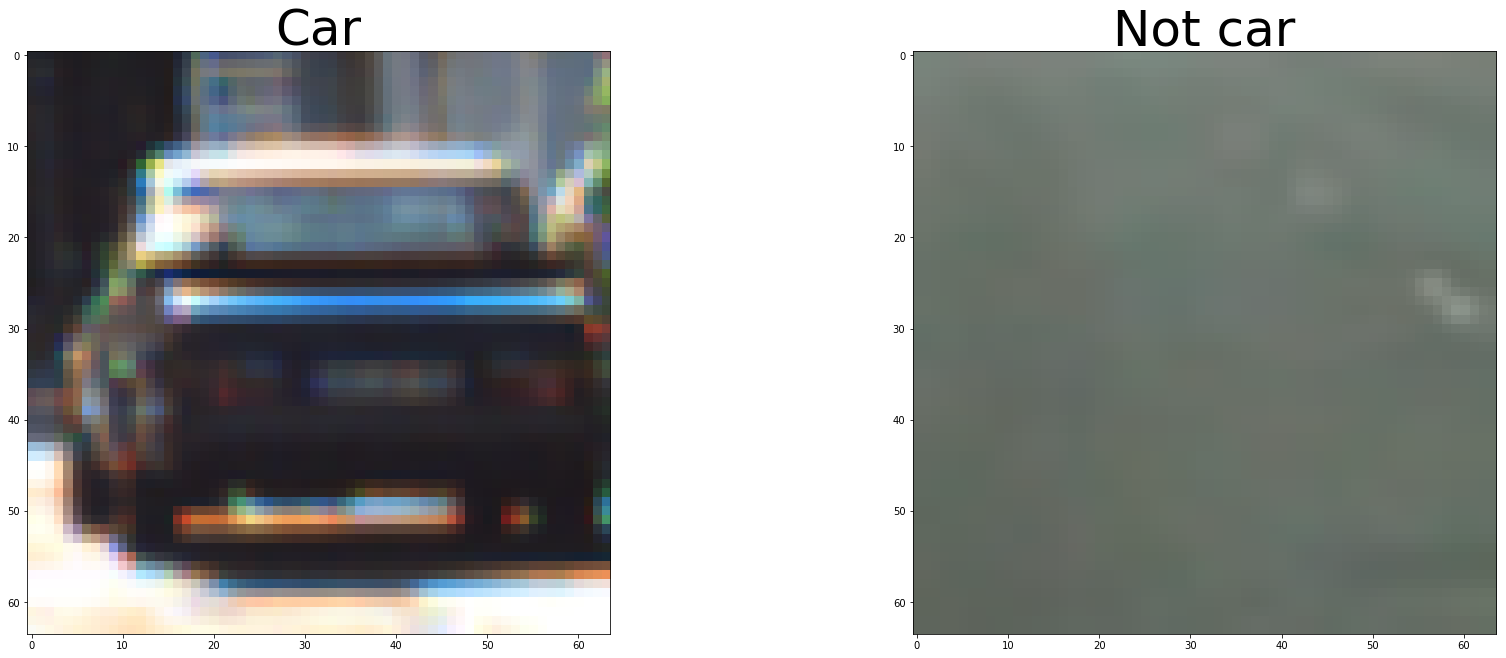

In [101]:
# Reading vehicle and non-vehicle images and gettig a sense of the data
v_images_kitti = glob.glob('training_samples/vehicles/KITTI_extracted/*.png')
nv_images_gti = glob.glob('training_samples/non-vehicles/GTI/image*.png')

# creating a list of images to test the hog features on
v_imgs = v_images_kitti[:10]
nv_imgs = nv_images_gti[:10]

test_img_v = mpimg.imread(v_imgs[0])
test_img_nv = mpimg.imread(nv_imgs[0])
test_img_v_gray = cv2.cvtColor(test_img_v, cv2.COLOR_RGB2GRAY)
plotTwoImageInRow(test_img_v, test_img_nv, 'Car', 'Not car')

In [81]:
def plotThreeImagesInRow(image1, image2, image3, title1='image1', title2='image2', title3='image3'):
    plt.clf() # clear any previous saved data
    
    # creating layout to place three image sided-by-side with their respective title
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap='gray')
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2, cmap='gray')
    ax2.set_title(title2, fontsize=50)
    ax3.imshow(image3, cmap='gray')
    ax3.set_title(title3, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
def plotTwoImageInRow(image1, image2, title1='image1', title2='image2'):
    plt.clf()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap='gray')
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2, cmap='gray')
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
#def plotFeaturesHistorgram():

In [82]:
# function for rescaling the images to a smaller resolution
def bin_spatial(img, size=(32, 32)):
    
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# function to calculate the color histogram features for the given image
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## 1. Histogram of Oriented Gradients (HOG)

**1.a : Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.**

Following cells describe the method that extracts the HOG feature using the **hog()** method. The following values are set after experimenting with few values. I have chosen these values based on how closely they resemble the features in the original image. 

The first set of parameters captures the image features but at a top level. The second set of features captures the details in the image more granually. I will be experimenting with the classifier to see which of the two or something in between produces more accurate result keeping time delays less.

Final values for the parameter for the hog values can only be set after seeing how it made the classifier perform though.

In [83]:
# Method to extract HOG features from the given image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

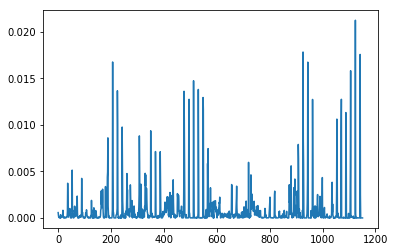

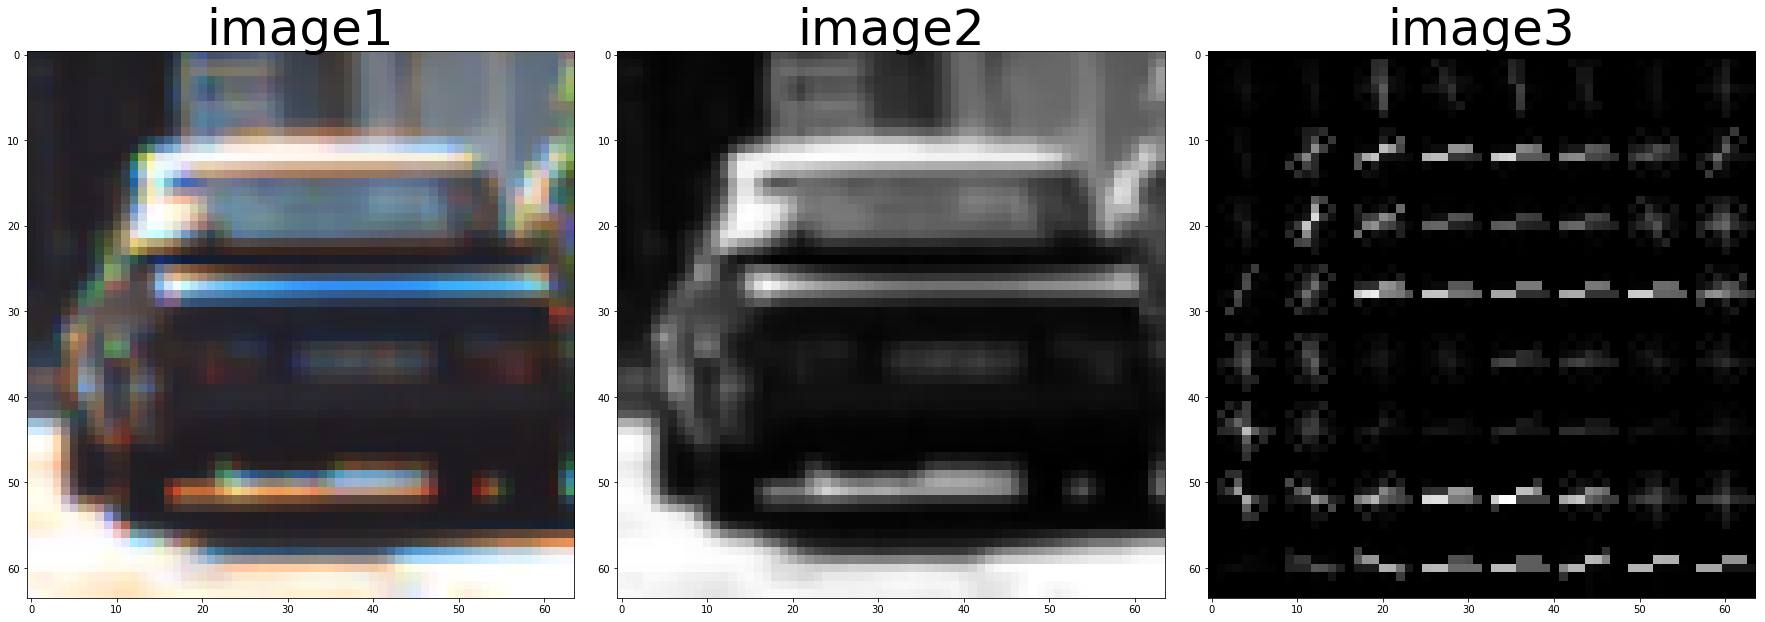

In [84]:
# testing with different parameter for extracting the hog features
hog_feature_1,hog_vis_1 = get_hog_features(test_img_v_gray, orient=18, pix_per_cell=8, cell_per_block=8, vis=True, feature_vec=True)
plt.plot(hog_feature_1)
plt.show()
plotThreeImagesInRow(test_img_v, test_img_v_gray, hog_vis_1)

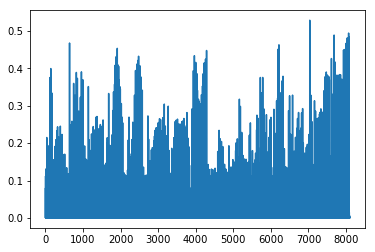

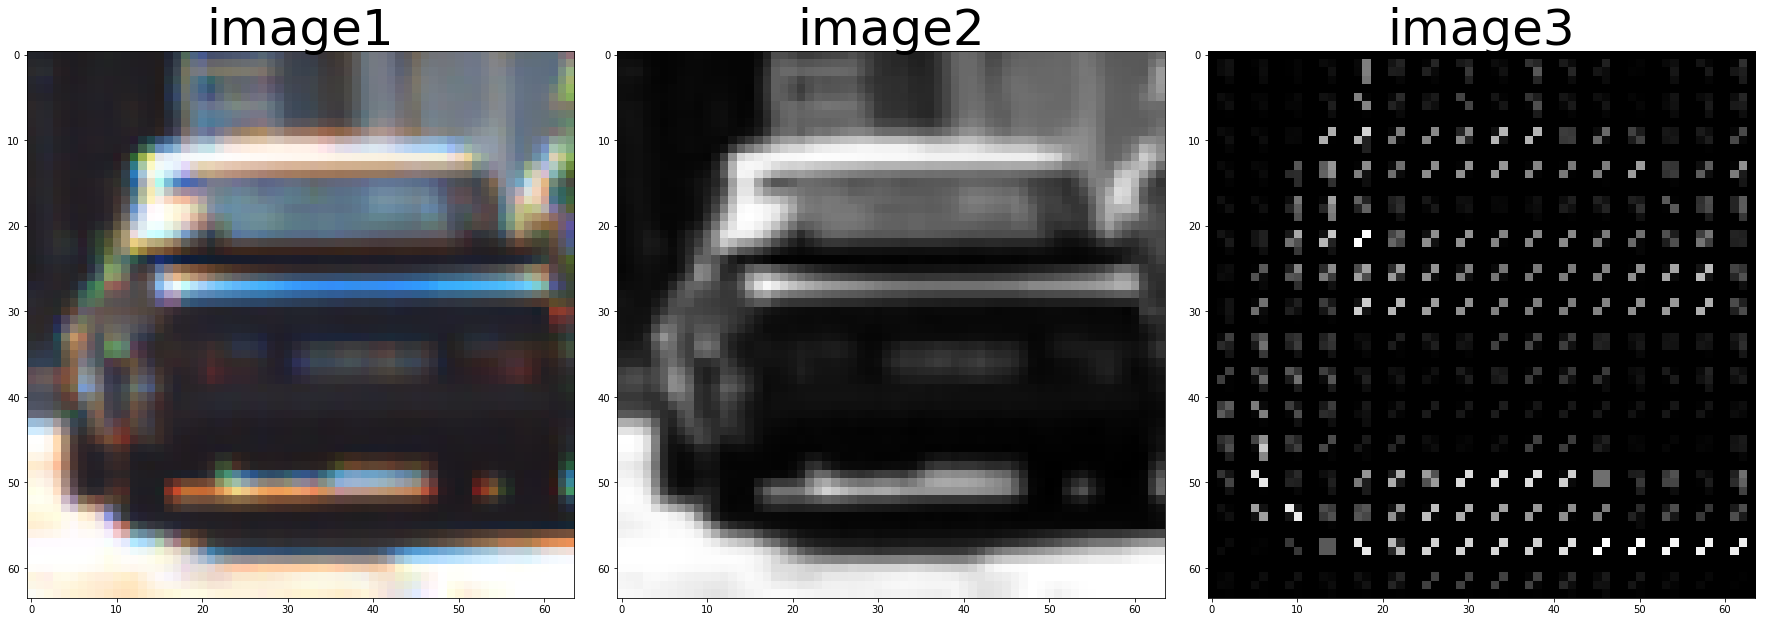

In [85]:
# Testing with more granular parameters
hog_feature_1,hog_vis_1 = get_hog_features(test_img_v_gray, orient=9, pix_per_cell=4, cell_per_block=2, vis=True, feature_vec=True)
plt.plot(hog_feature_1)
plt.show()
plotThreeImagesInRow(test_img_v, test_img_v_gray, hog_vis_1)

**1.b : Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them)**

In the following cells I will be writing the classifier and again testing them with different features combinations to increase the performance of the classifier.

I have used the SVM classifier. Following are the steps that goes into building and training the classifier:

1. **Extracting features : **I have used a combination of spatial, color histogram and HOG features for this classification. When tested for each of the features individually, I got 0.97 accuracy with only spatial features, 1.0 for histogram, 0.99 for HOG and 0.99 for all combined into one.
2. **Normalizing the features : **As suggested in the lessons, when combining different features to train the classifier there is always a possiblity that one feature might turn out to be more dominant than the other. That is why after I extracted the features for the car and non-car images, I am using **StandardScalar** to normalize my feature set.
3. **Train/Test splitting of data : **"I then created a sample of only 500 images from the list above and then divided that into training the testing set. I have kept the testing test as 20% of the total data.
3. **Create, train and test the classifier : **For classification I have created a SVM classifier and train and tested it out with different parameter yielding different accuracies. My final values for them in listed in the following cells

In [107]:
# fucntion to extract and concatenate features from an image
def extract_single_img_features(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, feature_type='all'):
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # extracting features based on the type provided
    if feature_type is 'bin':
        all_features = bin_spatial(feature_image, size=(32,32))
    elif feature_type is 'hist':
        all_features = color_hist(feature_image)
    elif feature_type is 'hog':
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        all_features = hog_features
    else:
        spatial_features = bin_spatial(feature_image, size=(32,32))
        hist_features = color_hist(feature_image)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                            orient, pix_per_cell, cell_per_block, 
                                            vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        all_features = np.concatenate((spatial_features, hist_features, hog_features))
        plt.plot(all_features)
        plt.show()
        
    return all_features

In [111]:
# This is an abstracted methods that I will be using to get the features on demand from the list of image created above.
# if feature_type == 'bin', to return spatial features
# if feature_type == 'hist', to return color histogram features
# if feature_type == 'hog', to return HOG features
# if feature_type == 'all', to return a sum of all features by concatenating each of them into a single feature
def extract_features_from_image_list(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, feature_type='all'):

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        image = mpimg.imread(file)
        # Append the new feature vector to the features list
        features.append(extract_single_img_features(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, feature_type='all'))
    # Return list of feature vectors
    return features

In [112]:
# Creating a small sample of images to test different parameter for training the classifier
sample_size = 500
car_imgs = v_images_kitti[:sample_size]
non_car_imgs = nv_images_gti[:sample_size]

In [114]:
# parameters for extracting the features
colorspace = 'HSV'
orient = 9
pix_per_cell = 8  # 8 gives out accuracy of 0.99 and 4 gives out accuracy of 1.0
cell_per_block = 2
hog_channel = 'ALL'

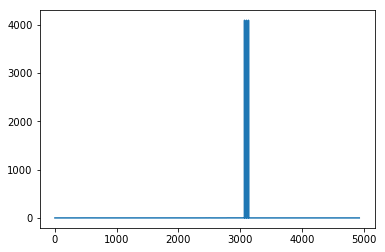

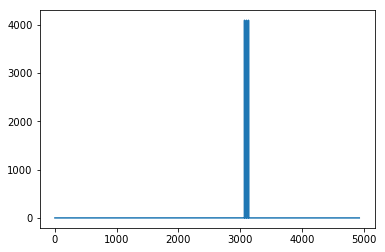

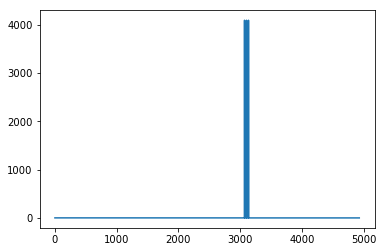

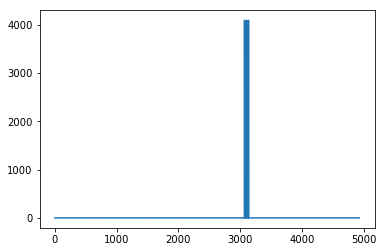

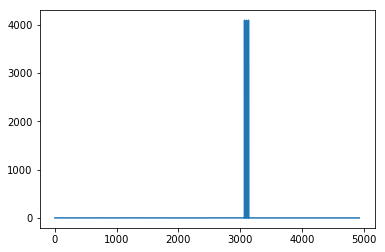

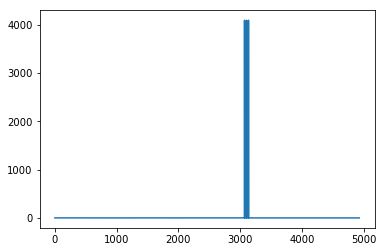

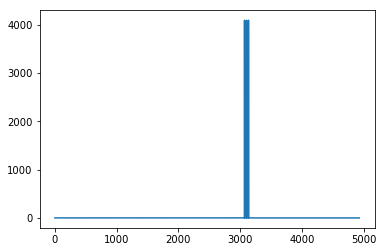

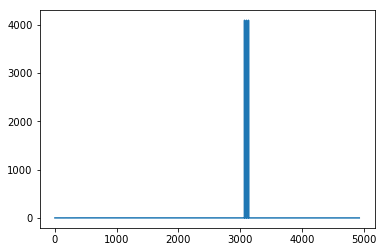

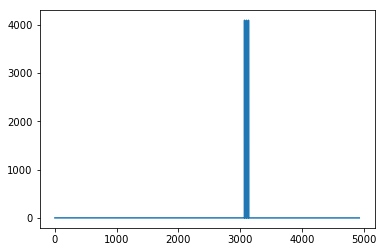

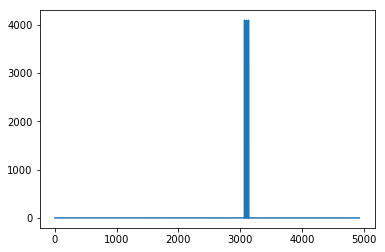

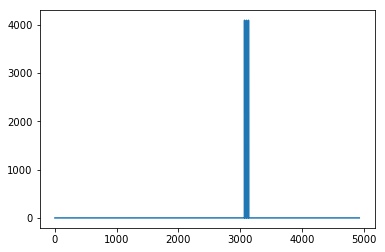

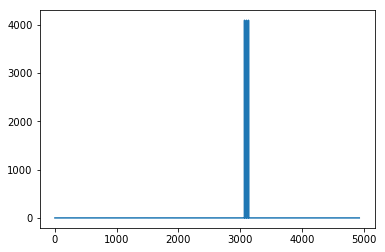

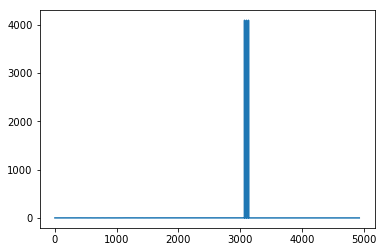

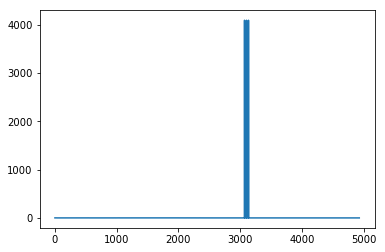

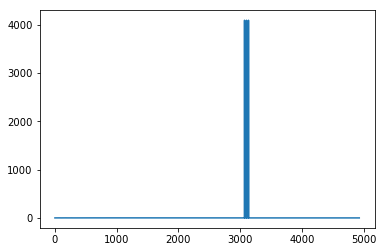

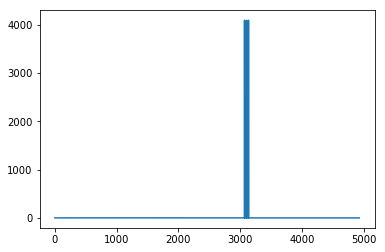

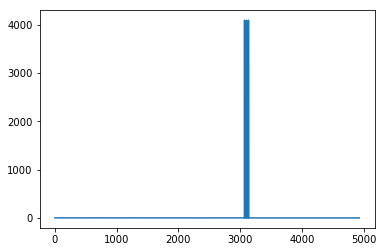

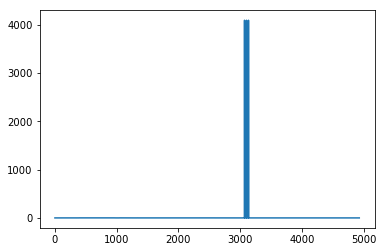

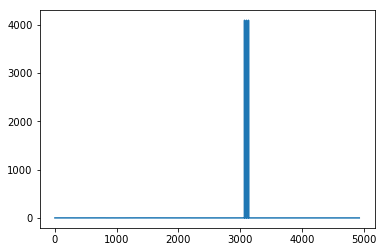

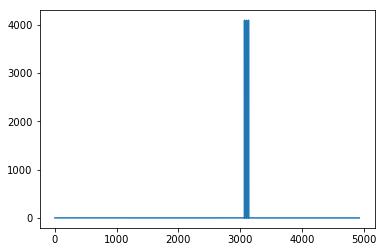

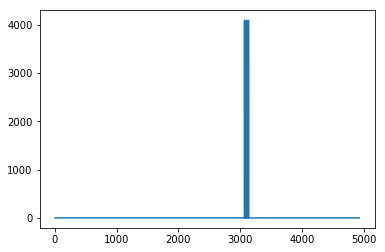

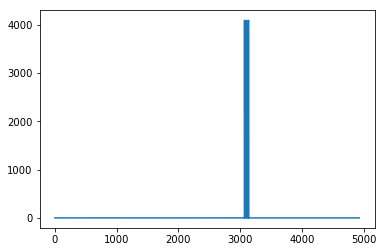

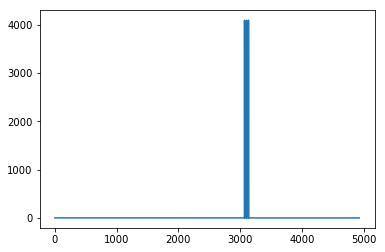

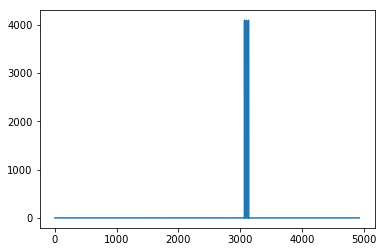

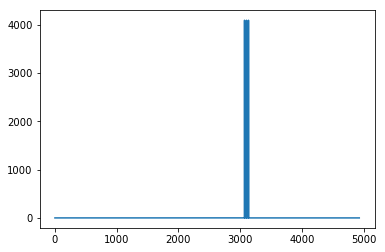

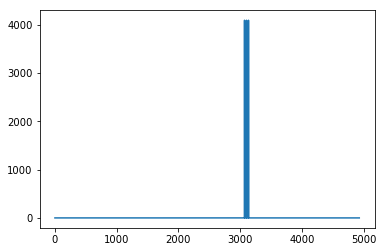

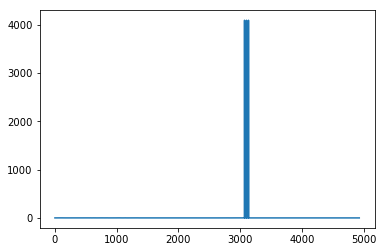

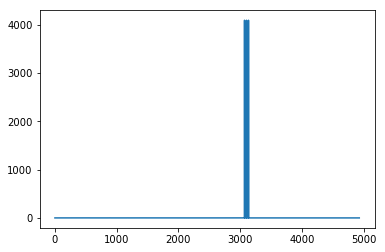

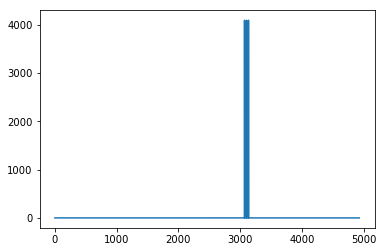

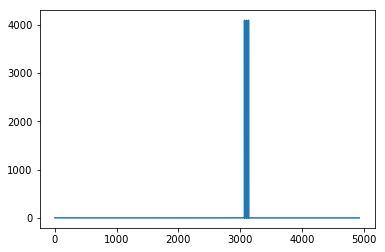

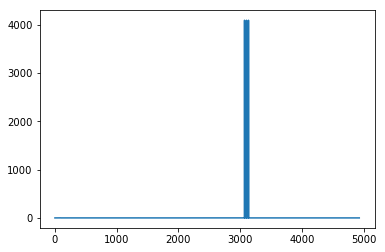

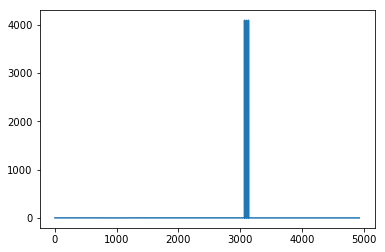

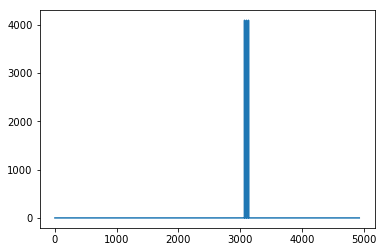

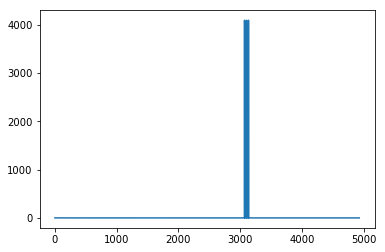

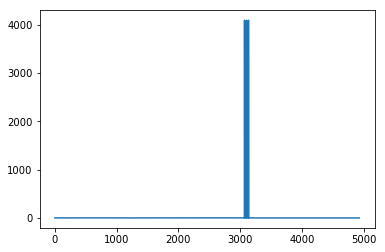

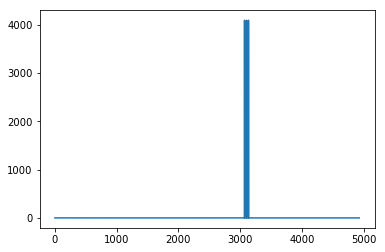

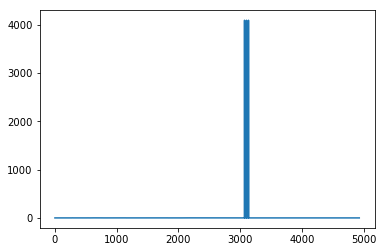

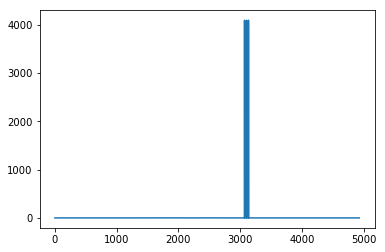

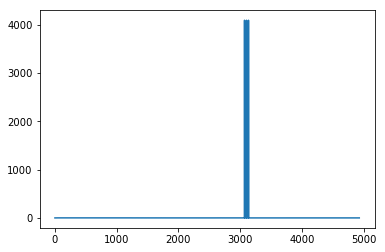

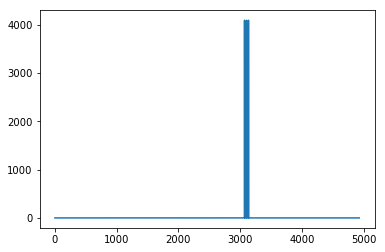

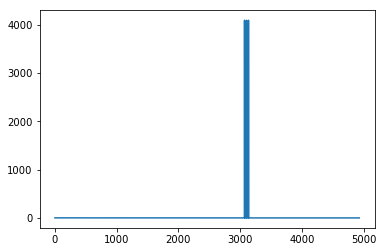

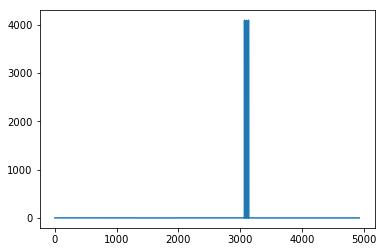

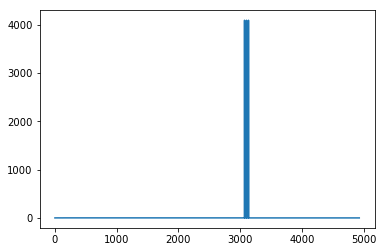

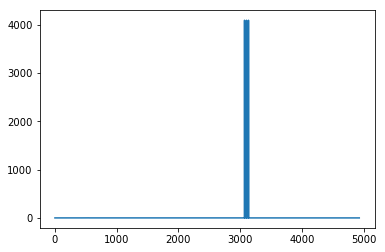

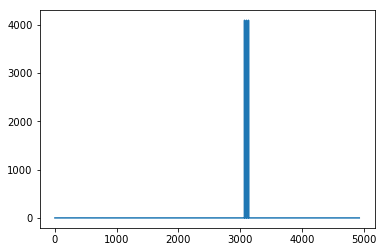

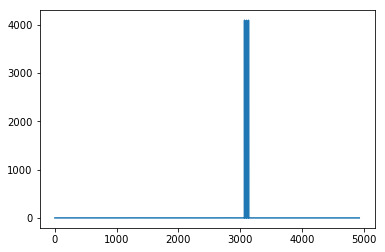

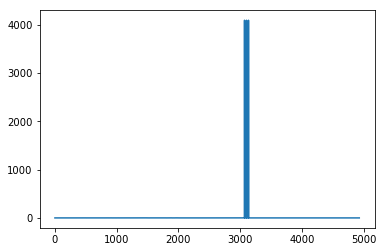

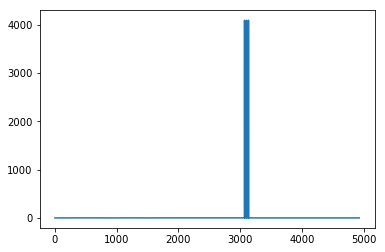

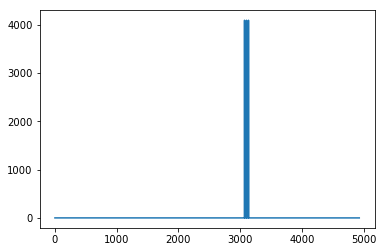

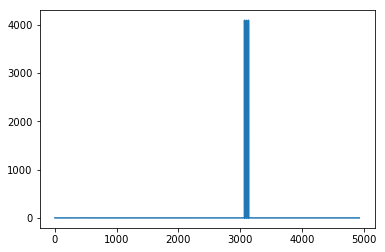

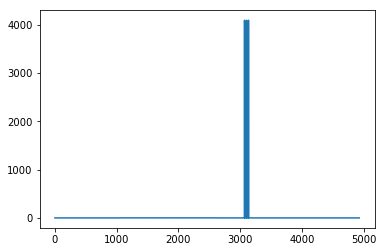

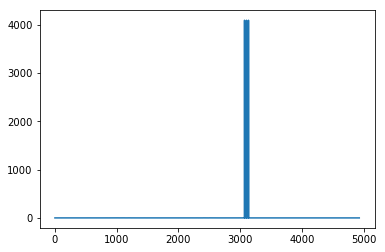

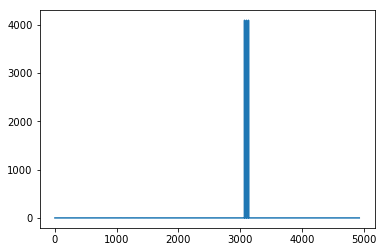

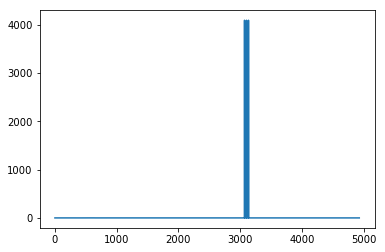

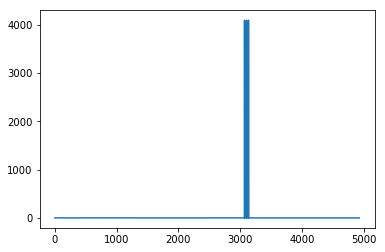

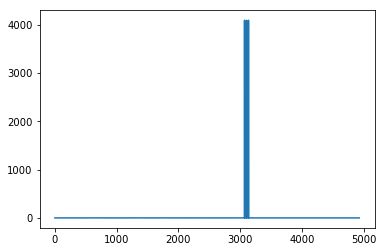

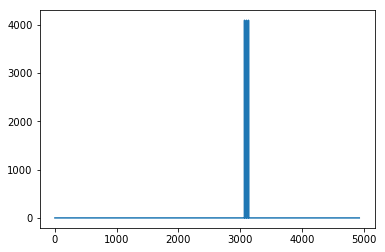

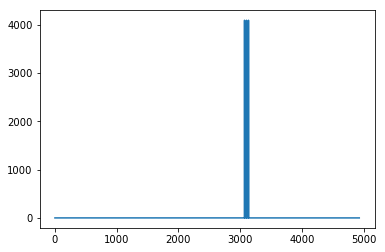

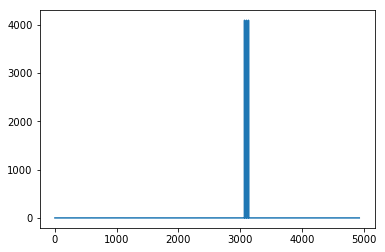

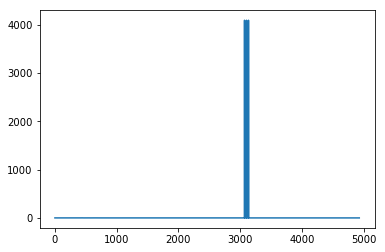

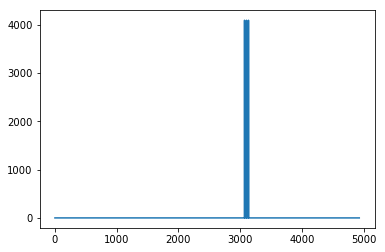

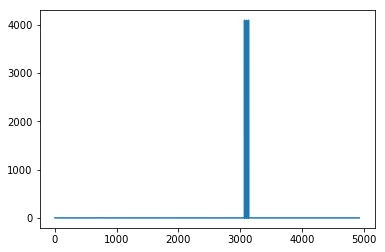

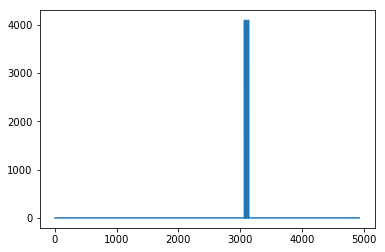

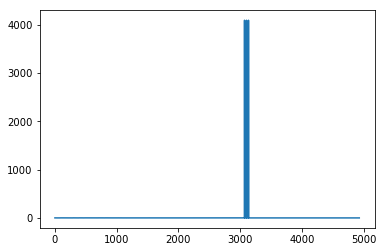

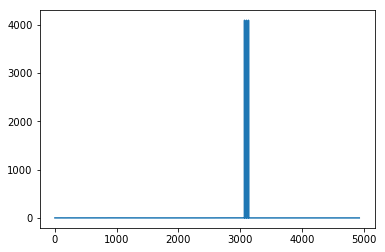

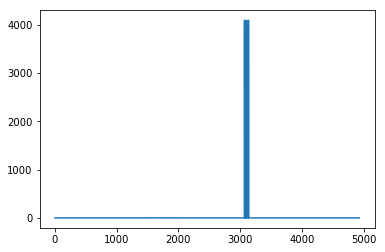

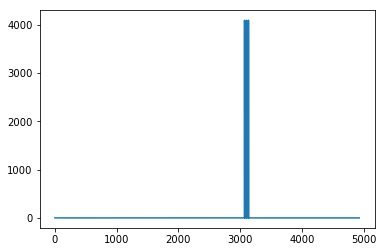

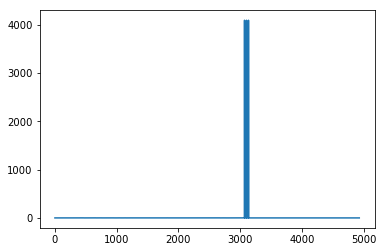

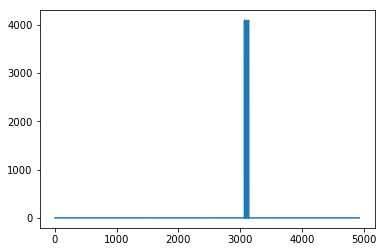

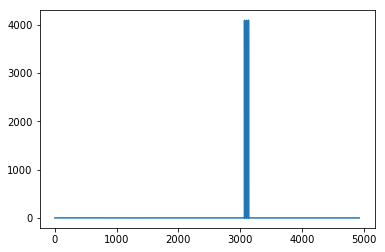

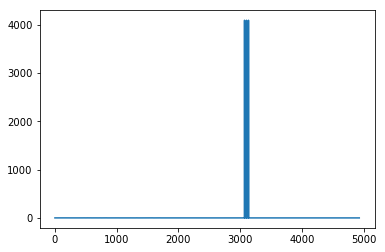

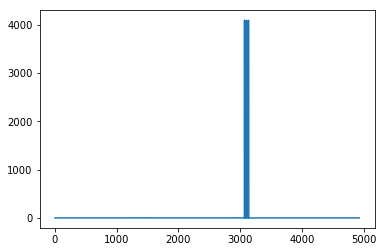

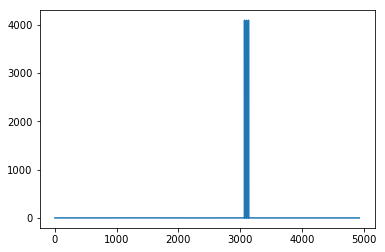

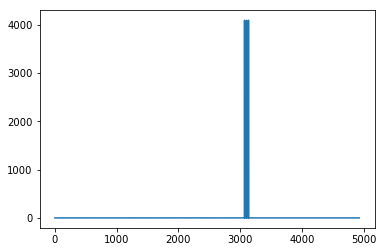

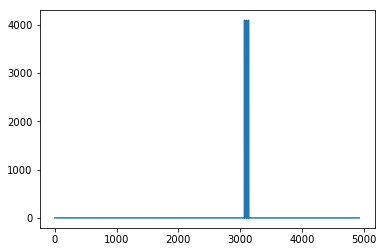

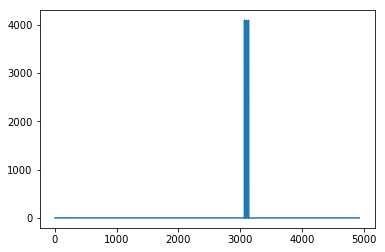

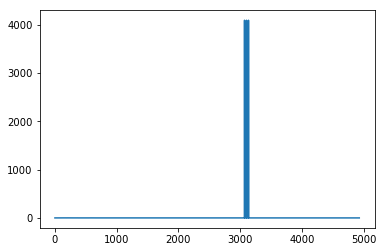

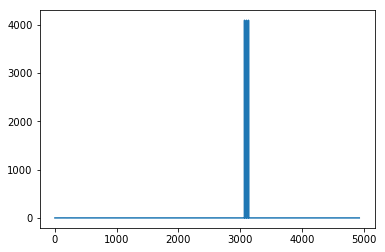

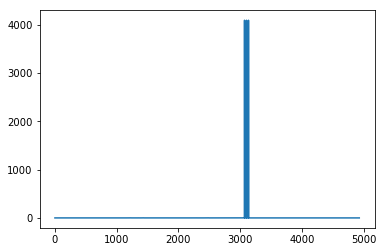

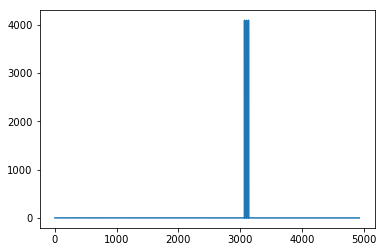

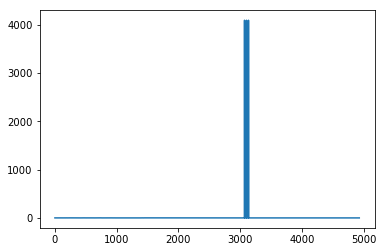

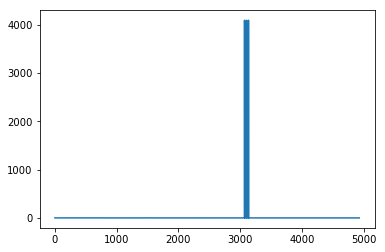

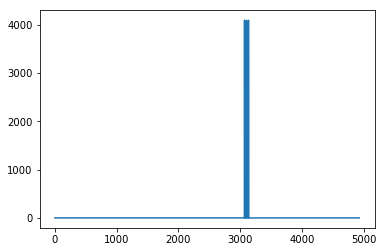

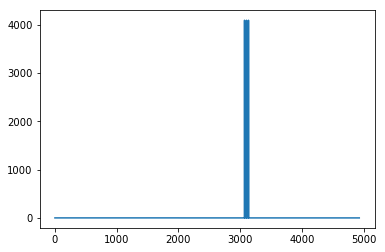

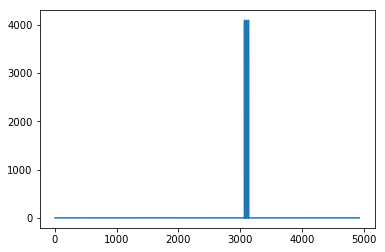

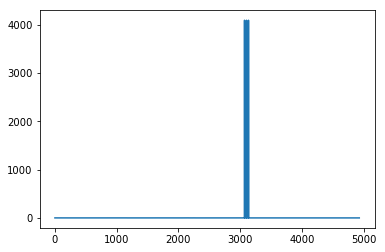

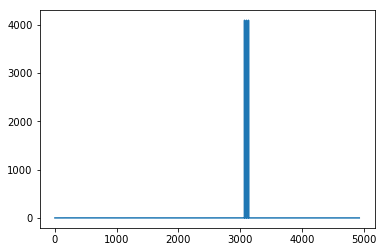

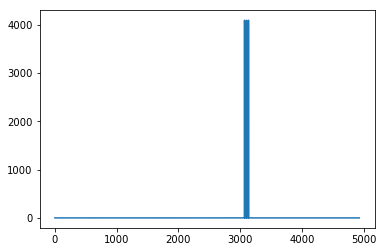

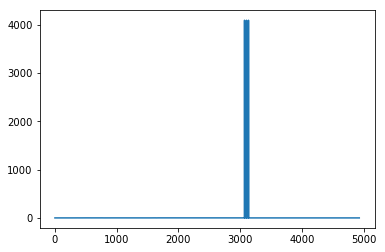

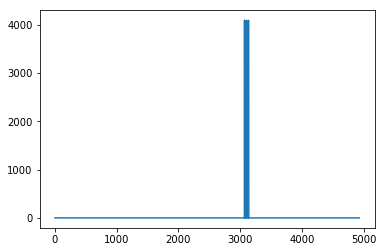

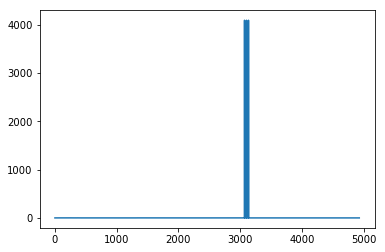

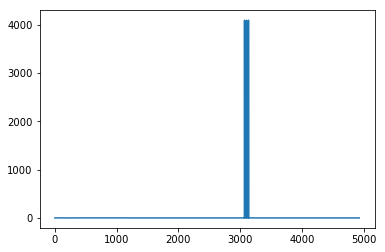

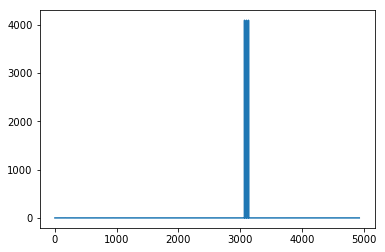

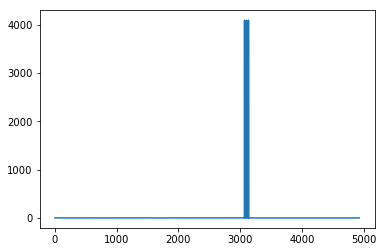

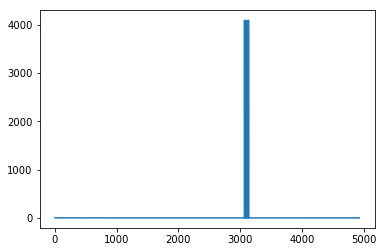

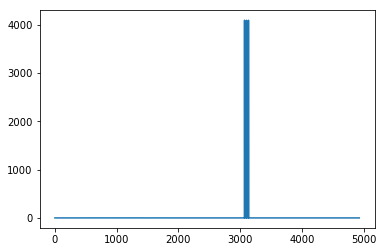

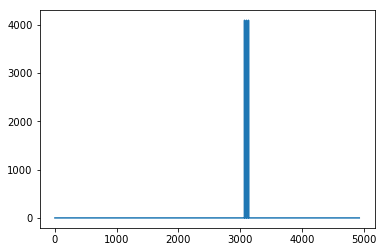

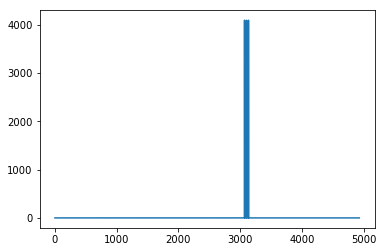

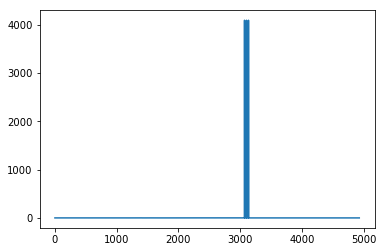

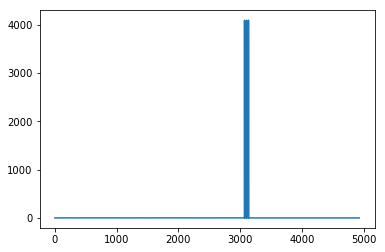

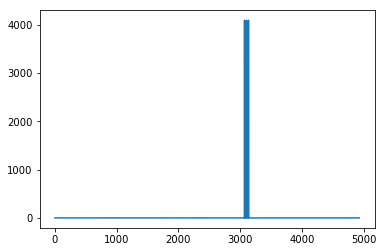

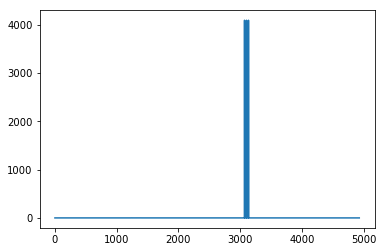

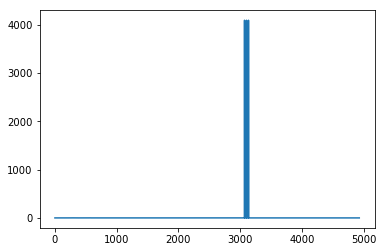

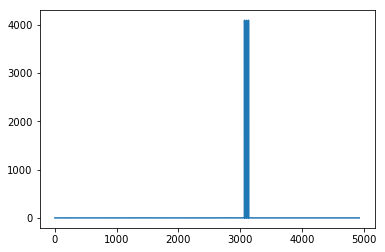

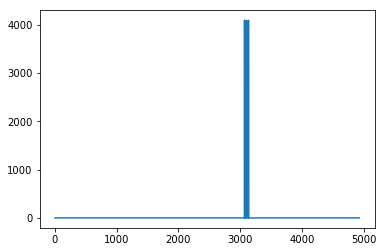

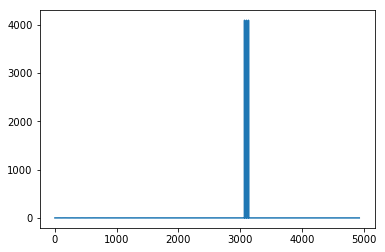

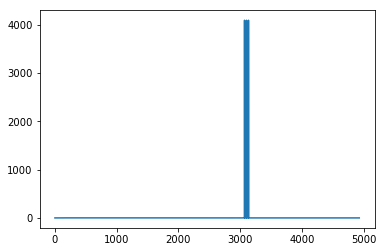

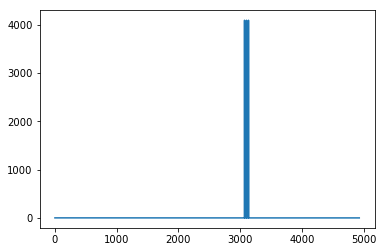

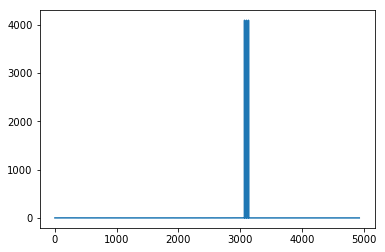

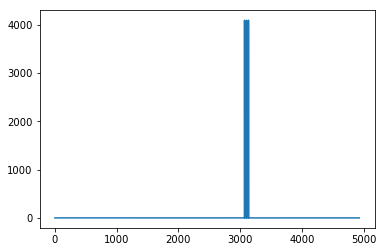

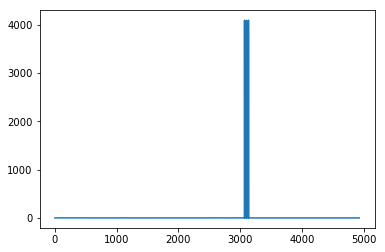

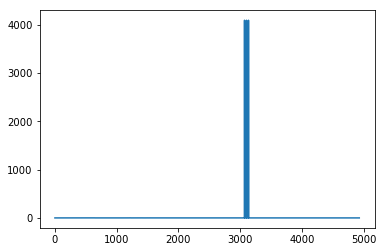

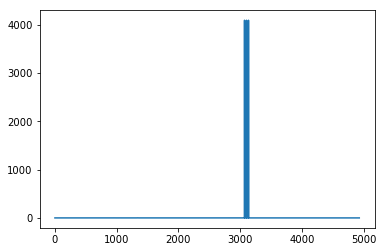

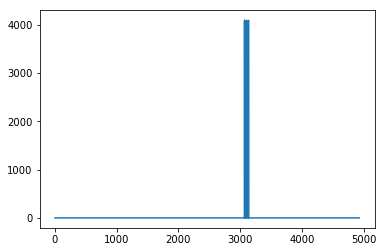

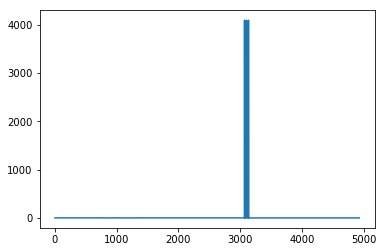

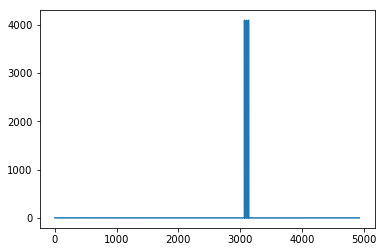

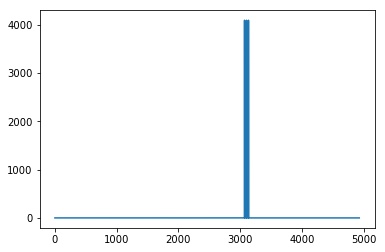

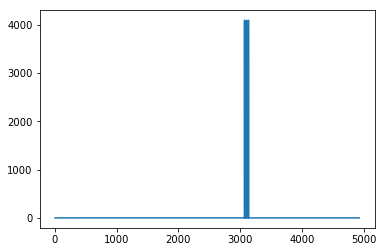

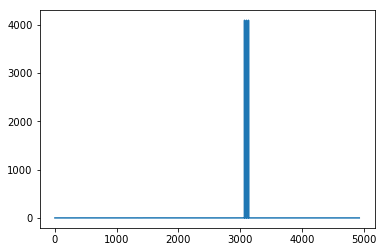

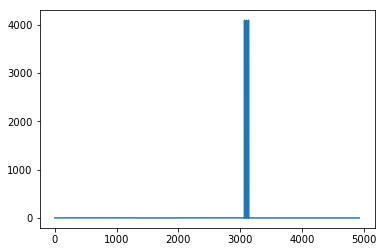

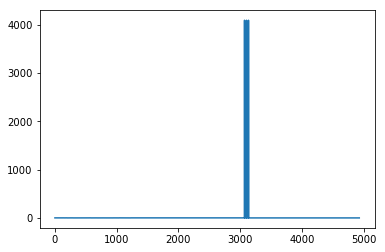

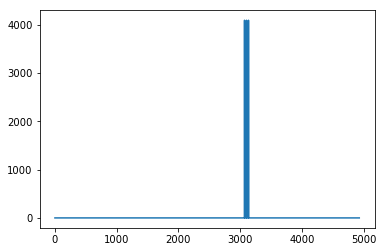

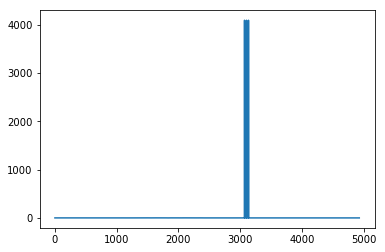

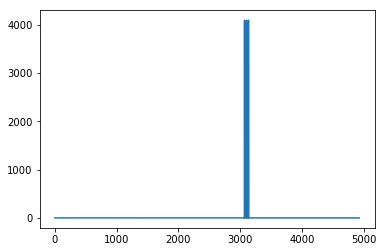

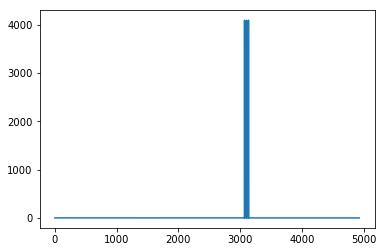

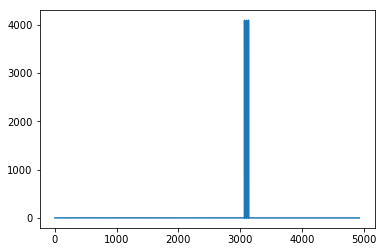

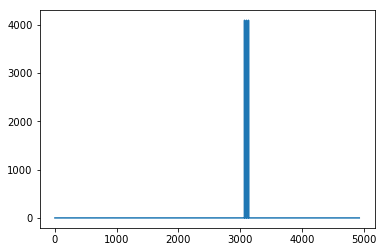

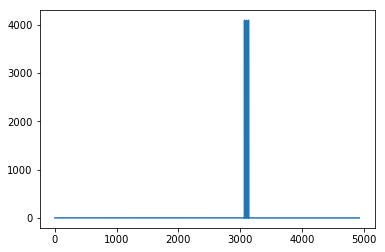

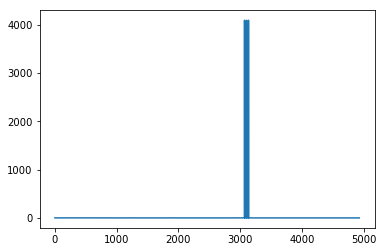

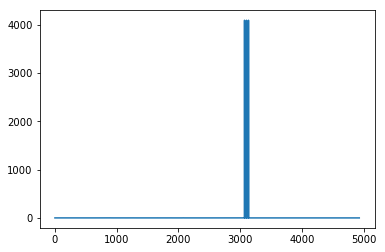

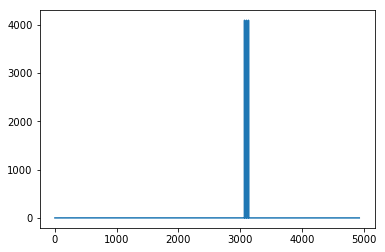

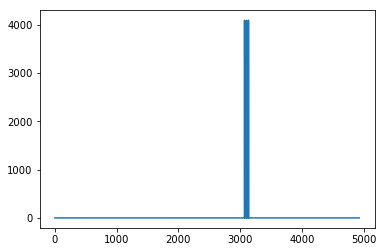

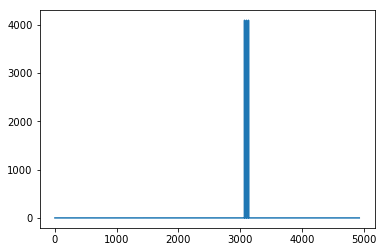

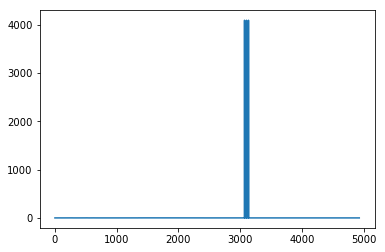

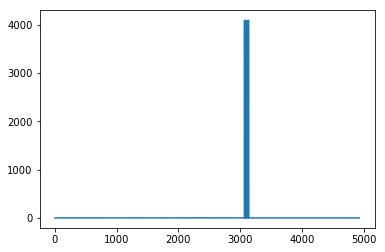

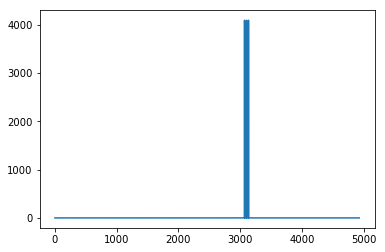

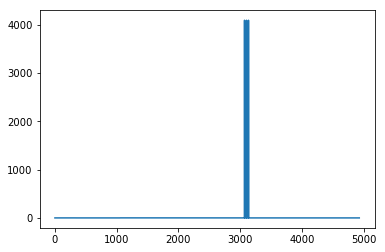

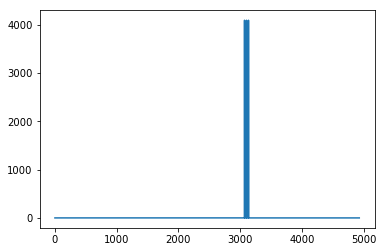

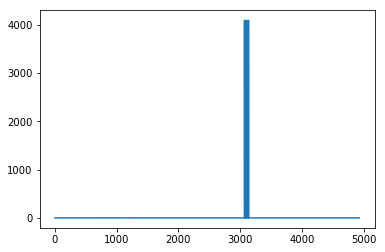

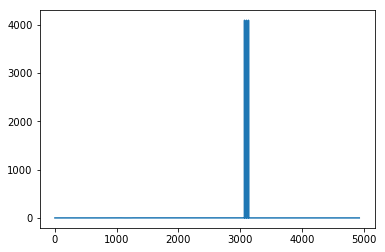

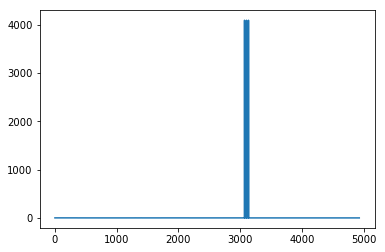

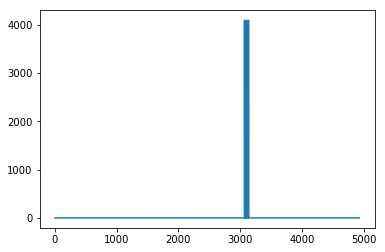

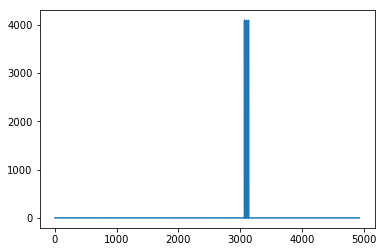

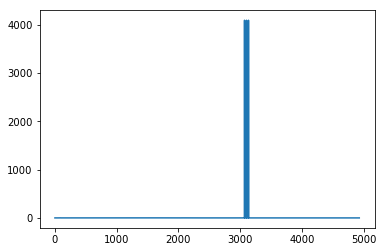

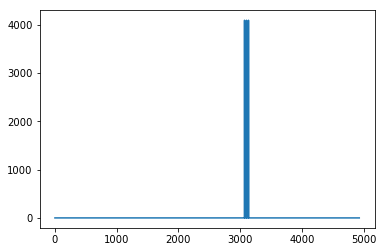

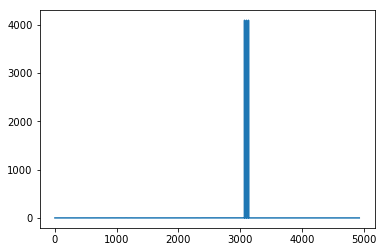

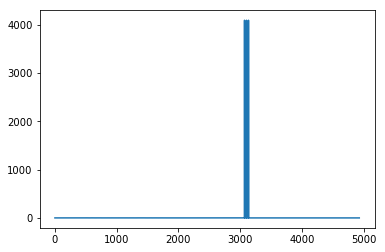

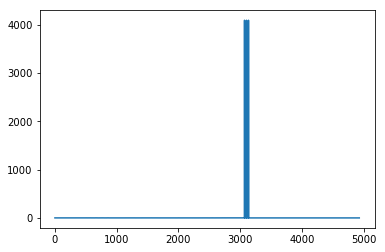

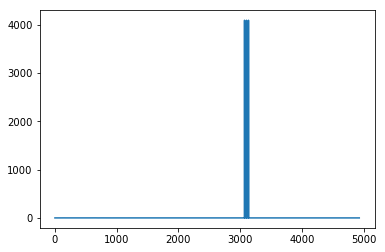

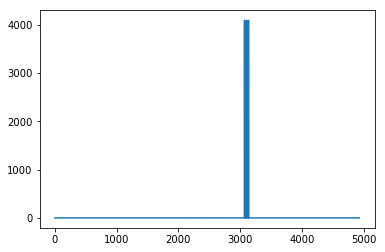

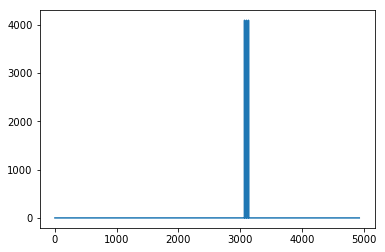

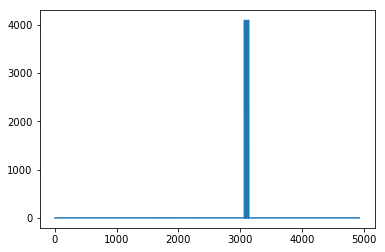

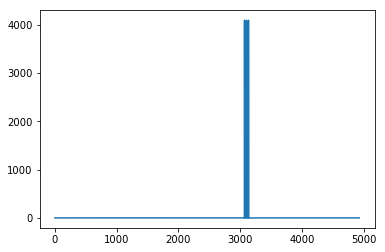

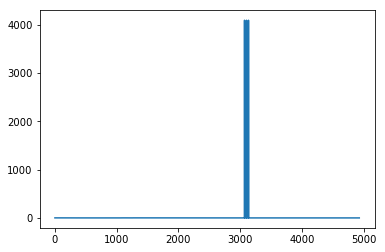

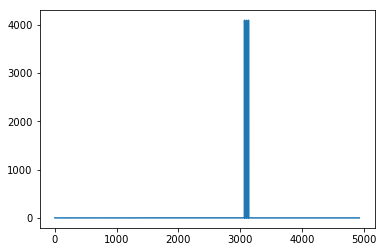

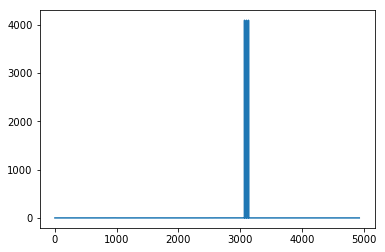

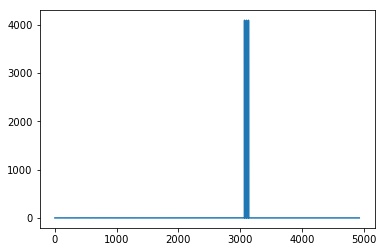

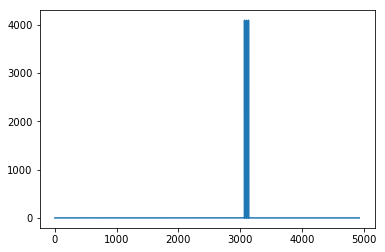

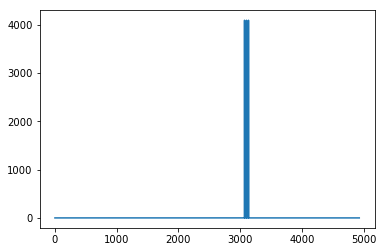

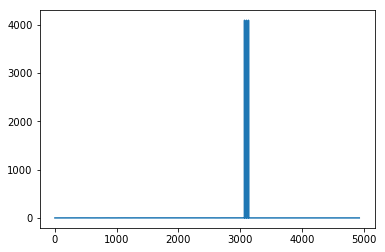

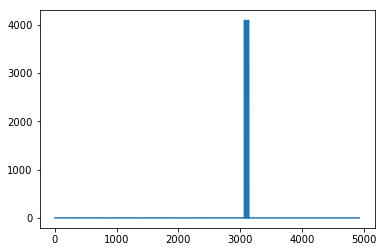

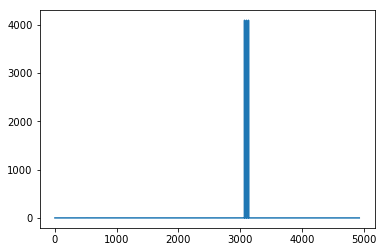

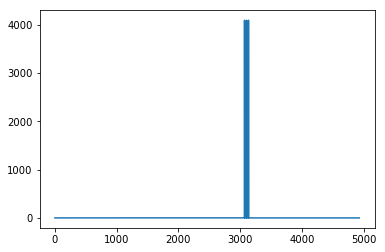

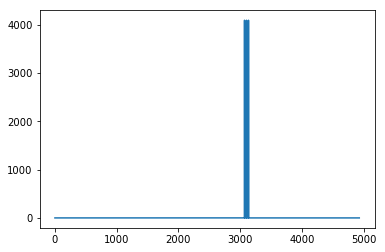

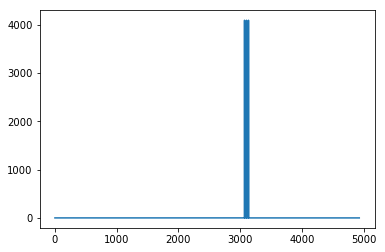

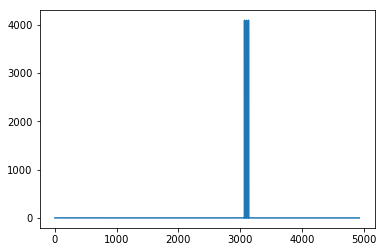

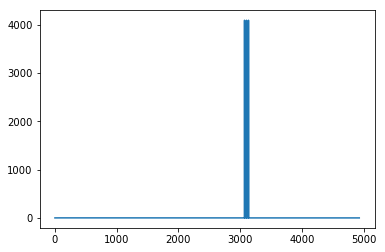

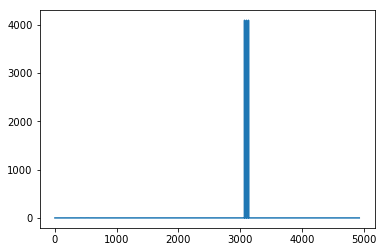

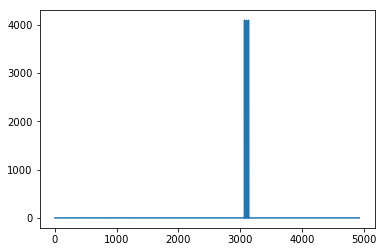

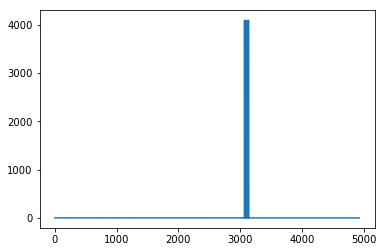

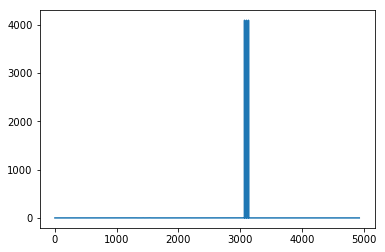

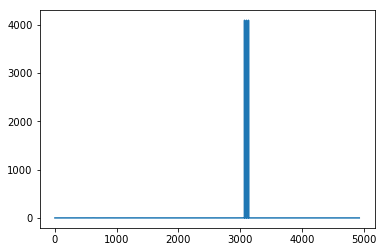

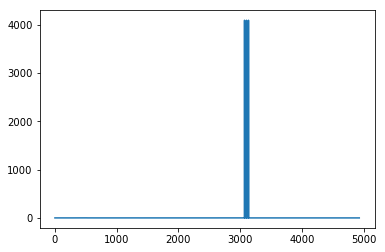

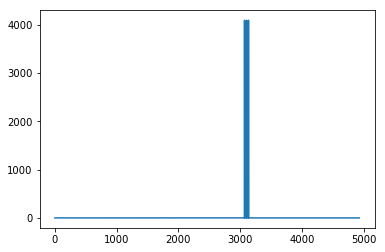

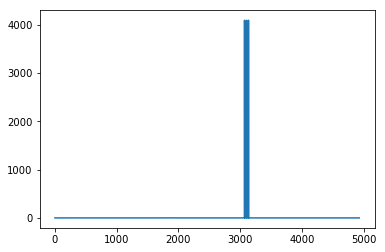

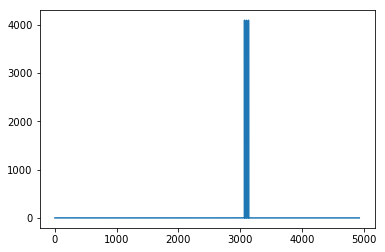

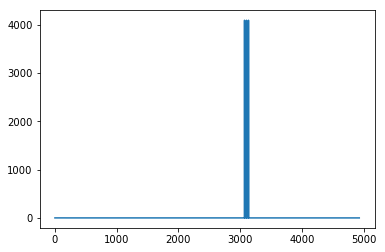

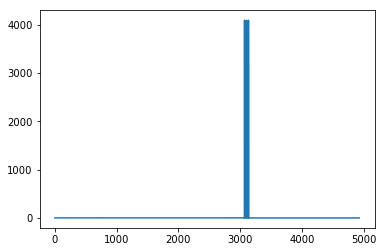

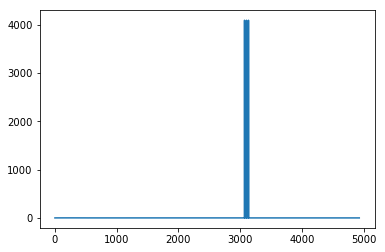

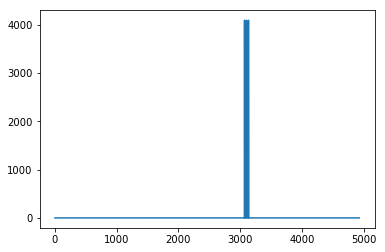

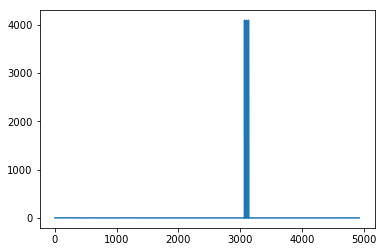

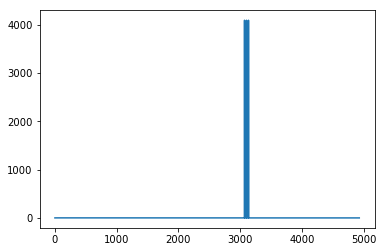

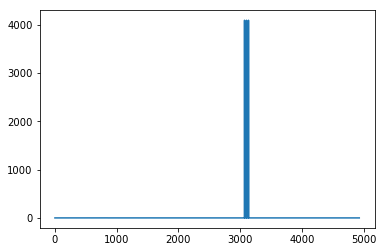

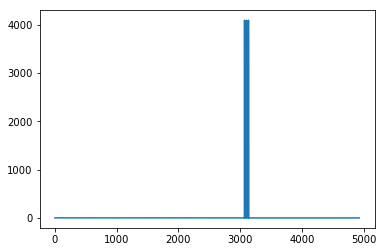

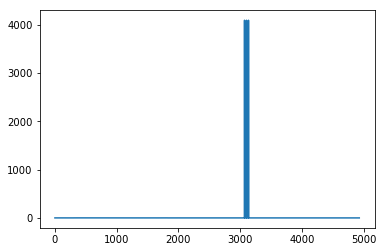

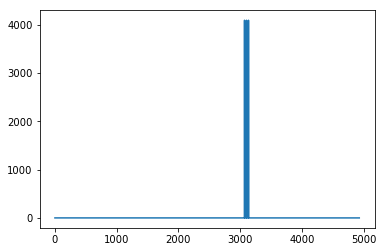

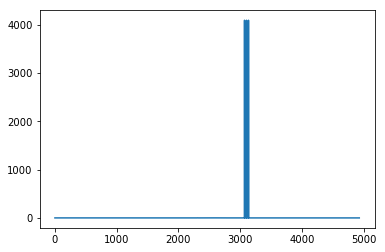

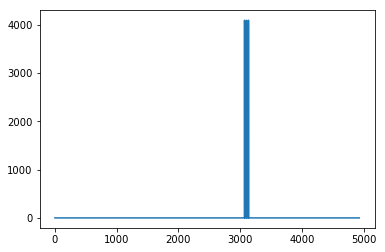

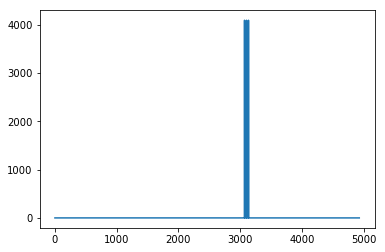

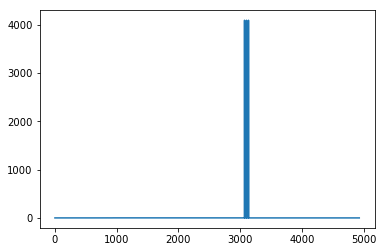

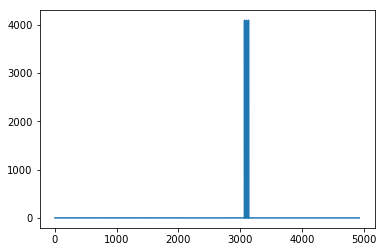

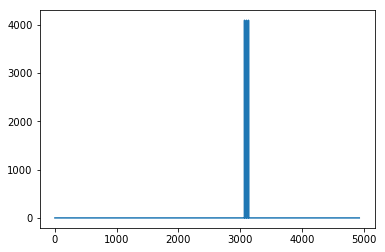

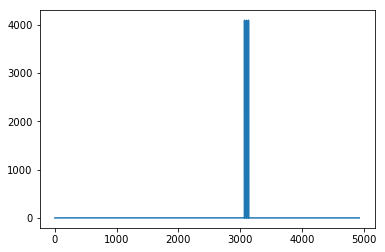

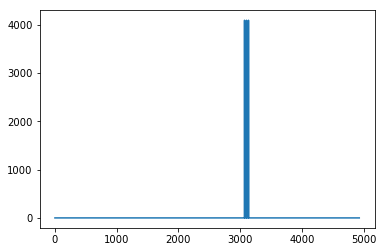

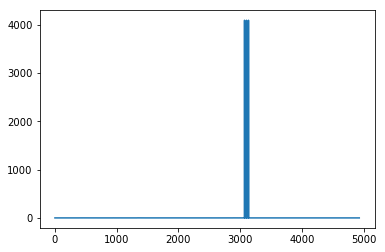

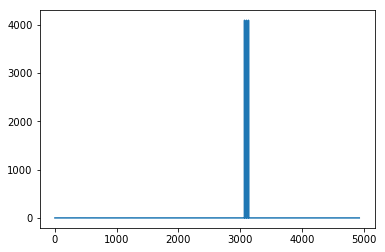

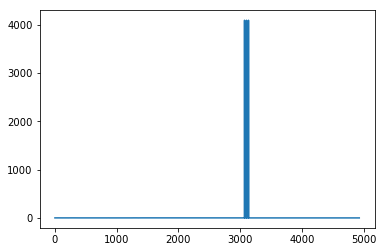

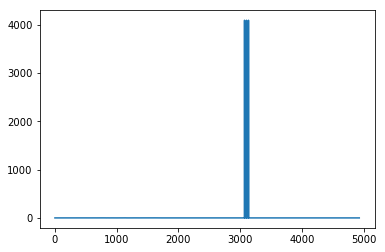

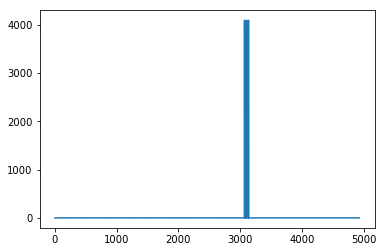

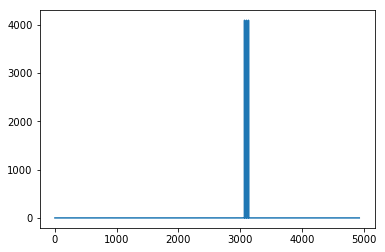

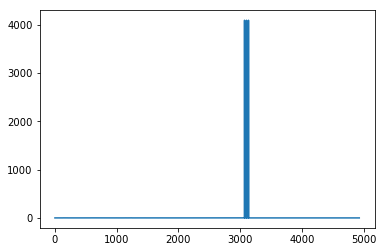

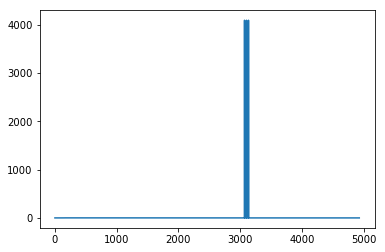

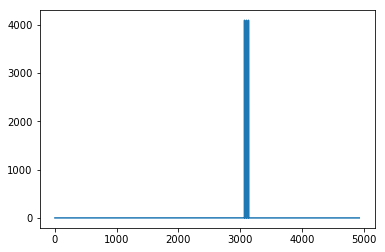

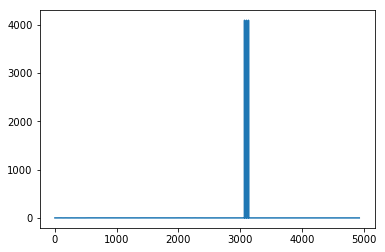

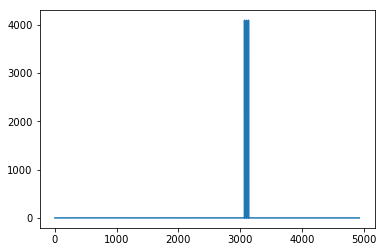

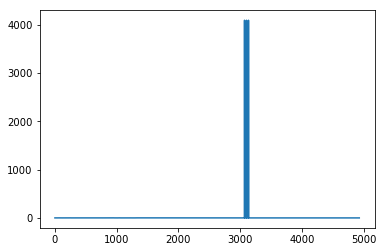

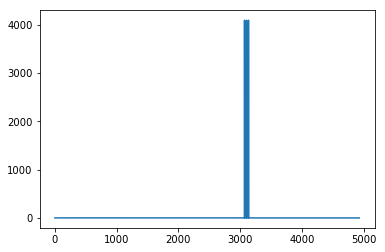

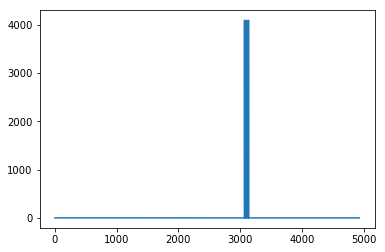

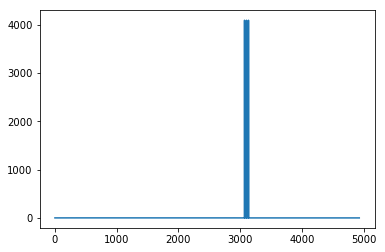

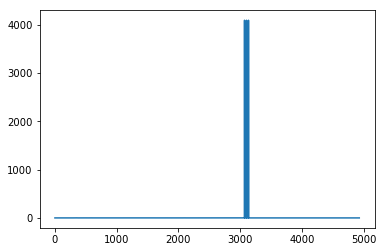

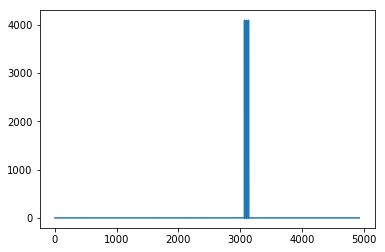

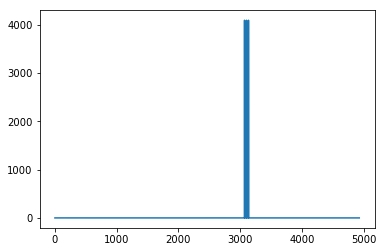

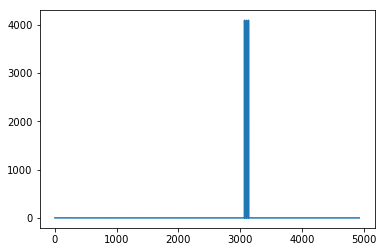

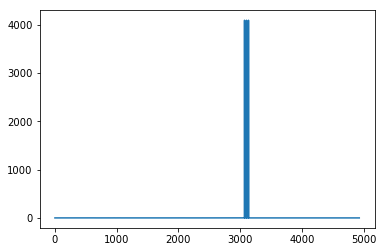

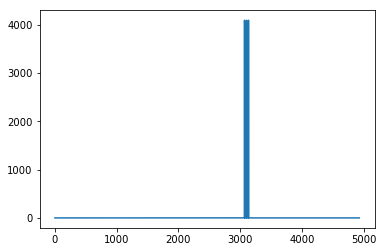

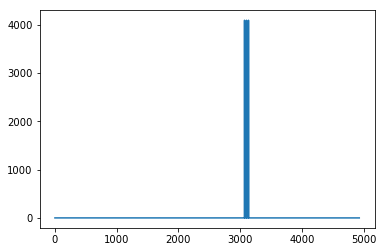

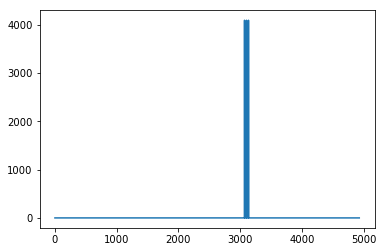

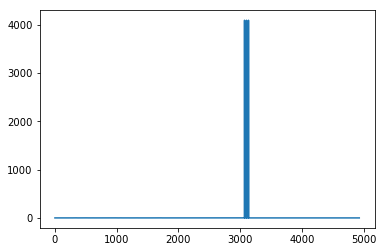

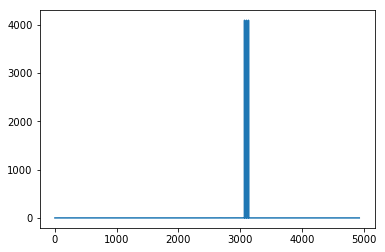

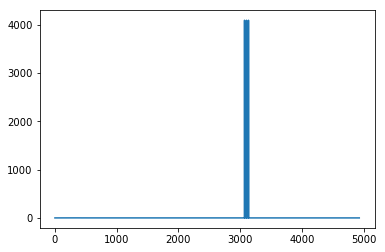

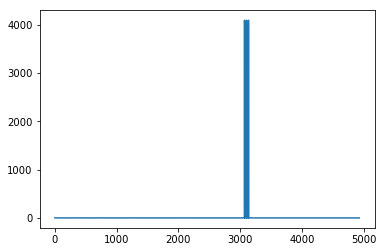

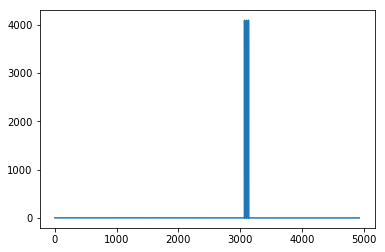

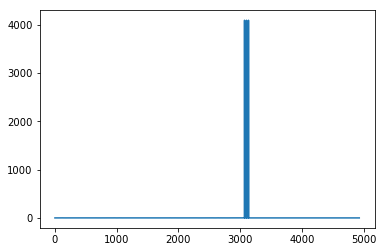

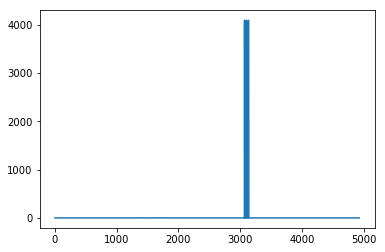

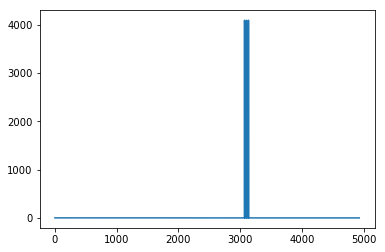

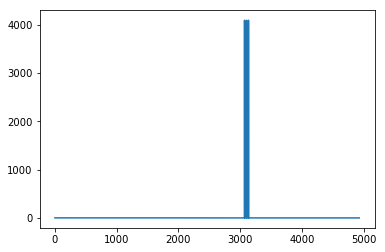

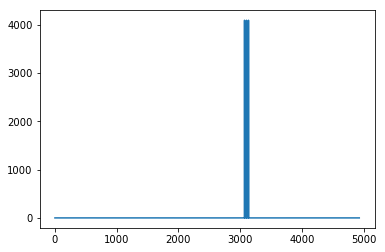

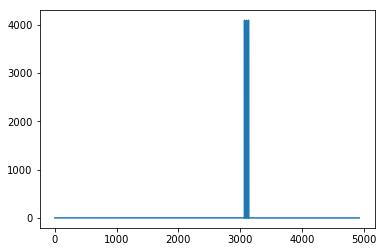

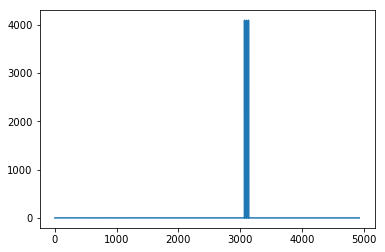

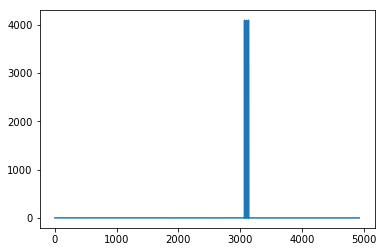

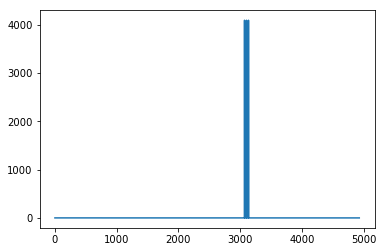

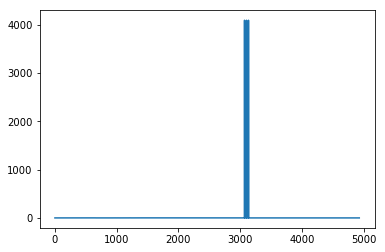

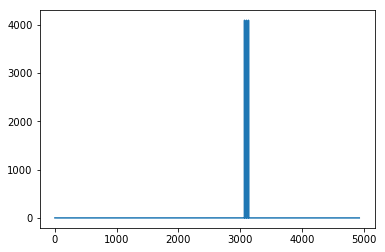

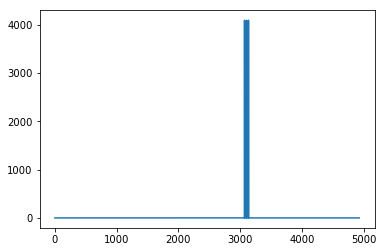

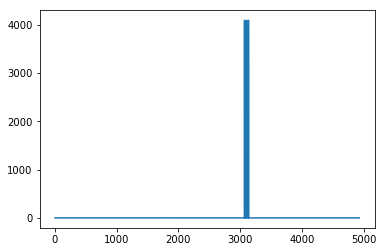

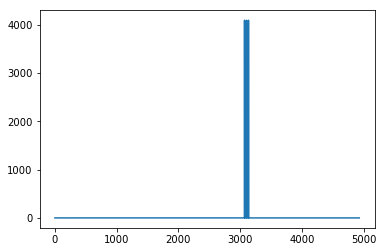

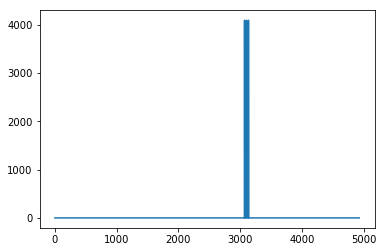

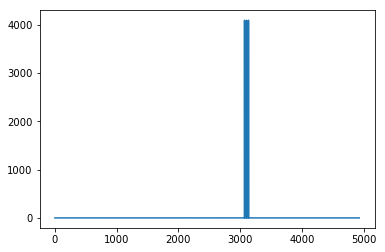

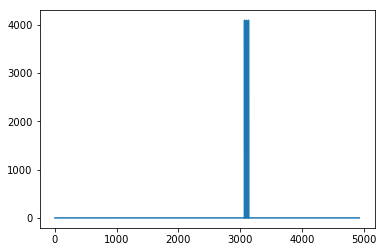

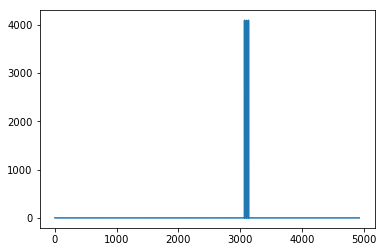

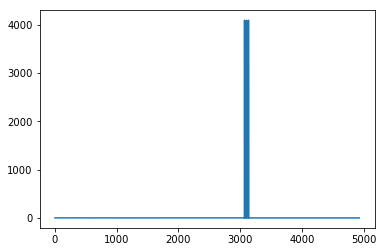

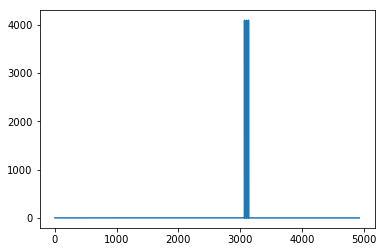

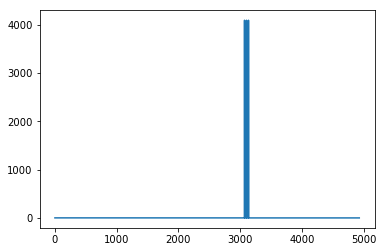

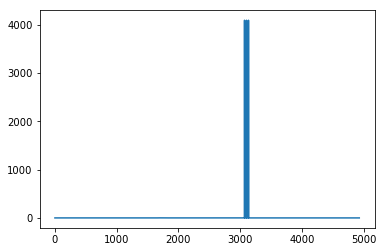

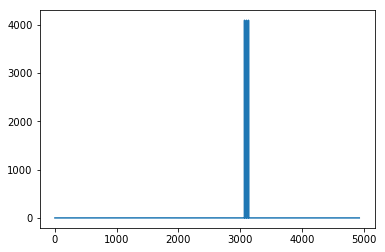

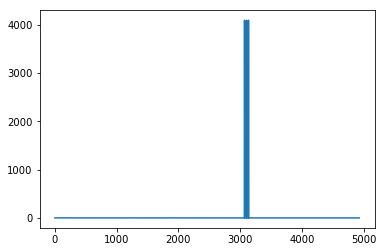

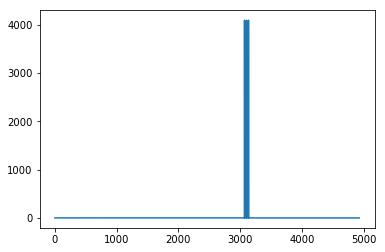

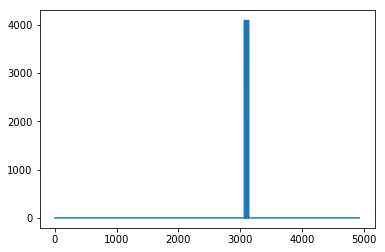

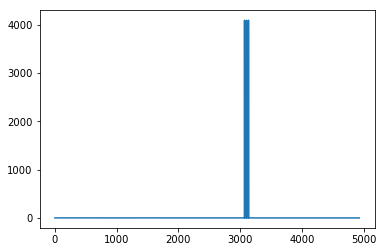

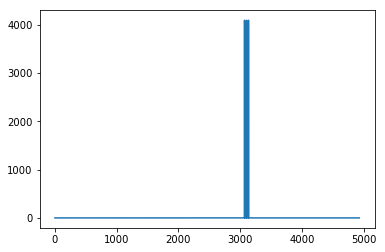

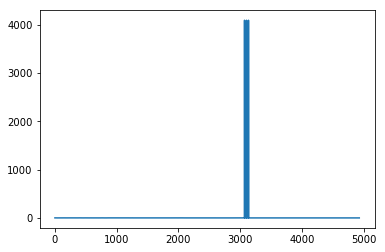

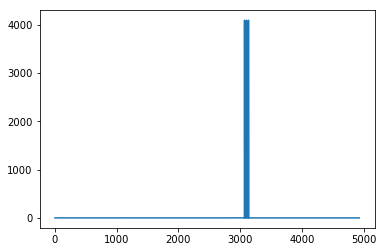

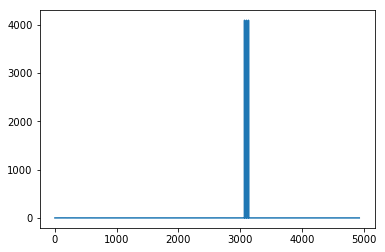

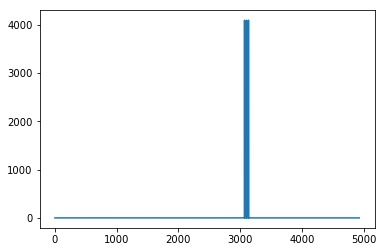

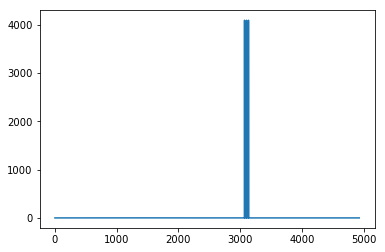

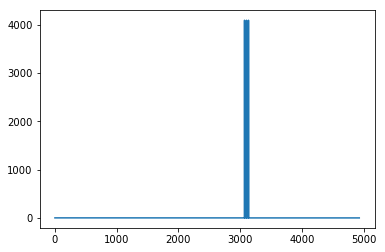

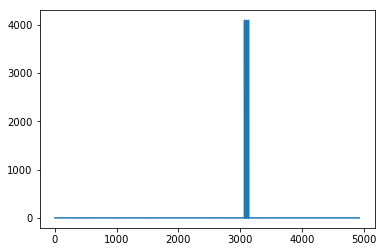

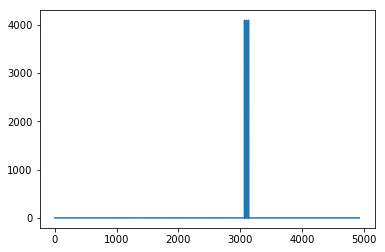

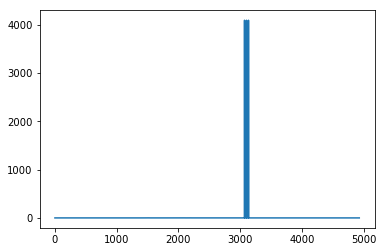

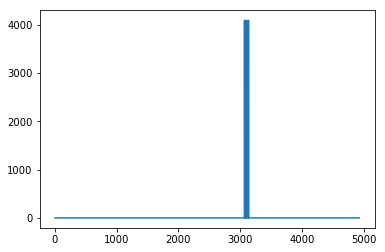

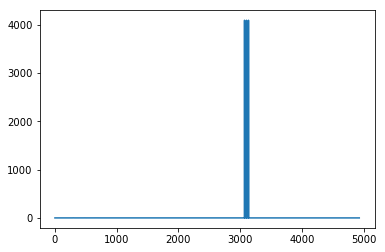

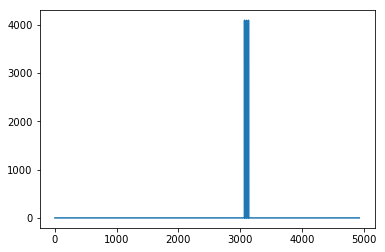

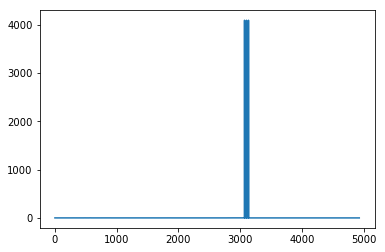

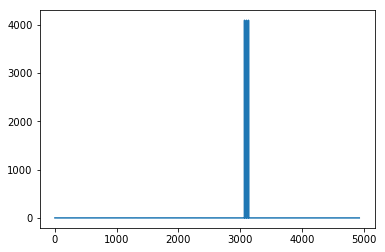

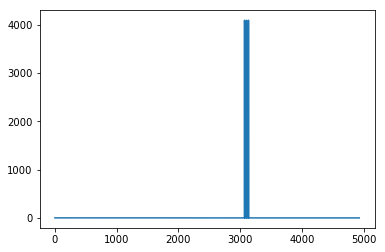

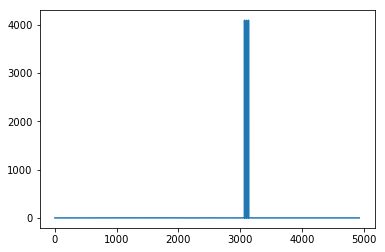

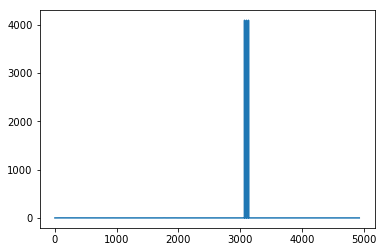

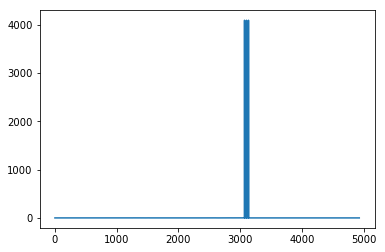

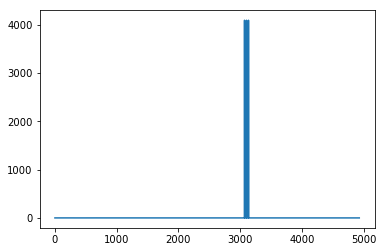

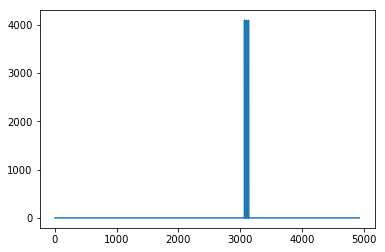

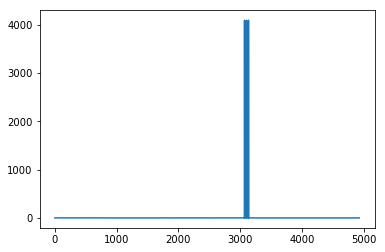

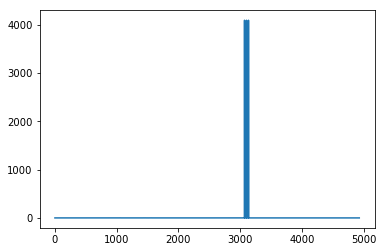

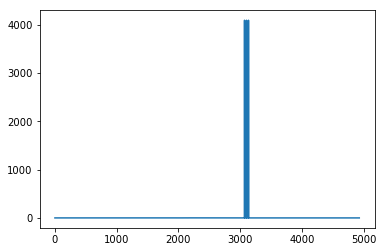

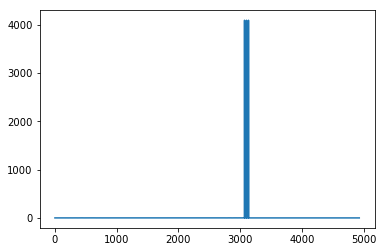

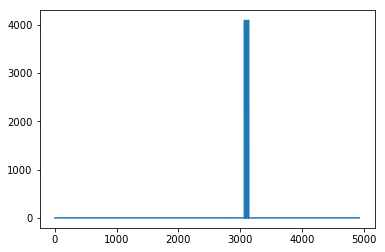

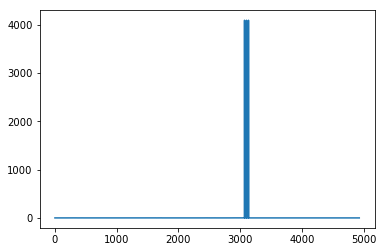

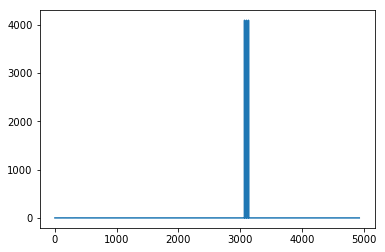

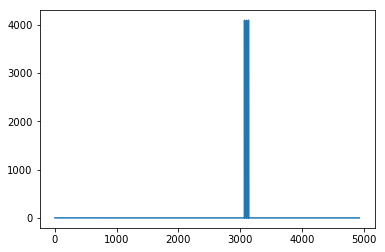

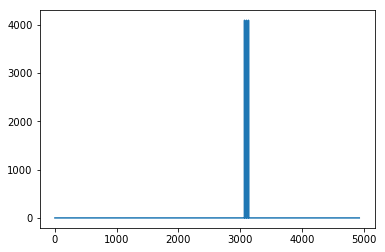

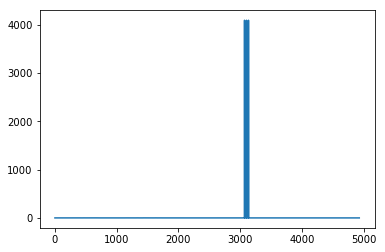

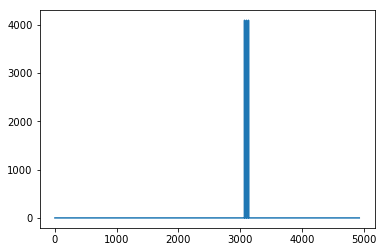

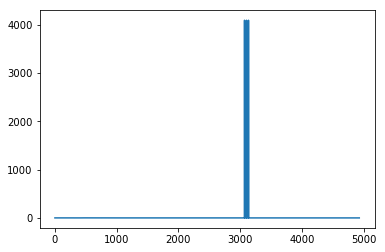

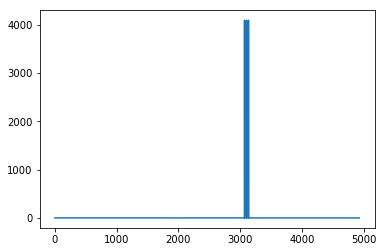

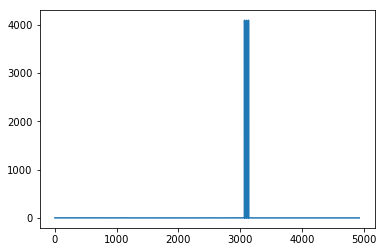

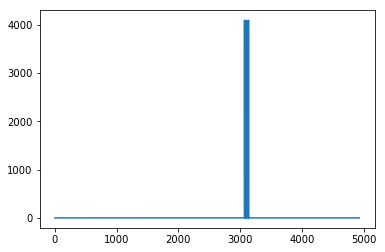

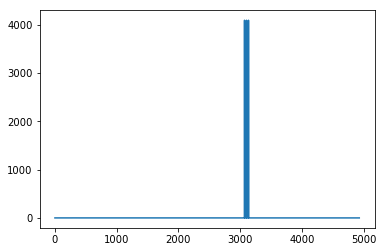

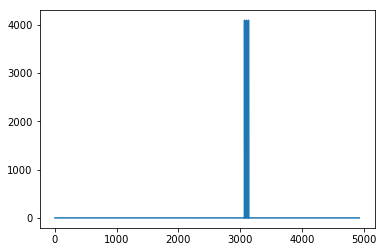

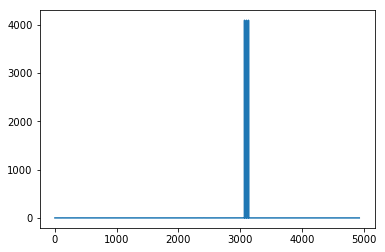

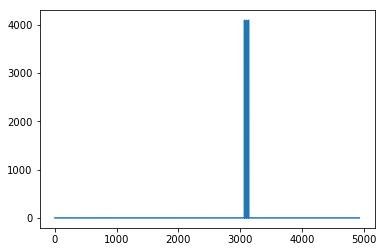

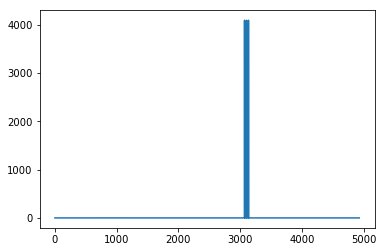

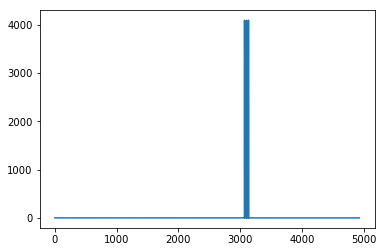

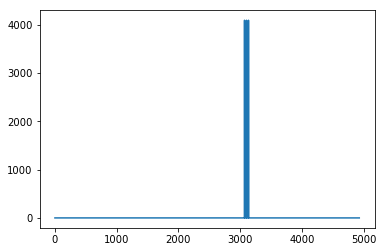

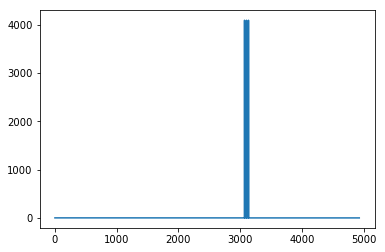

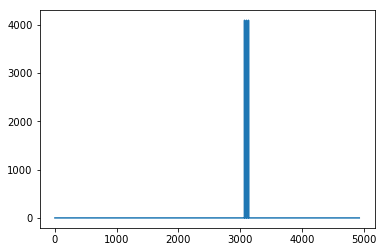

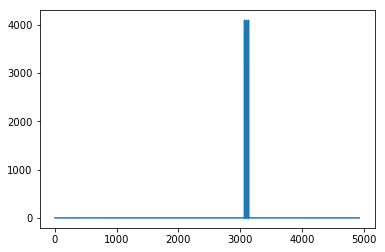

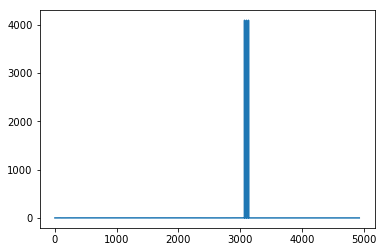

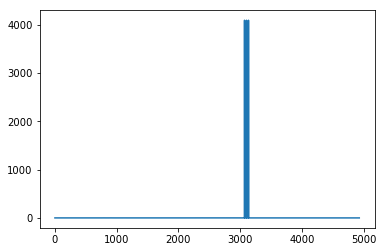

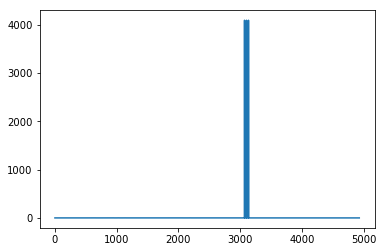

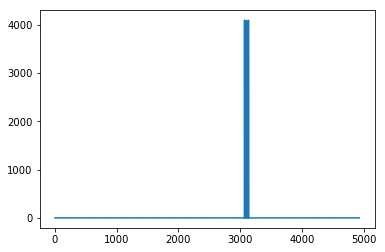

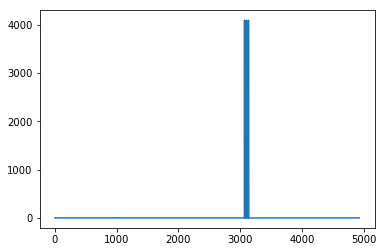

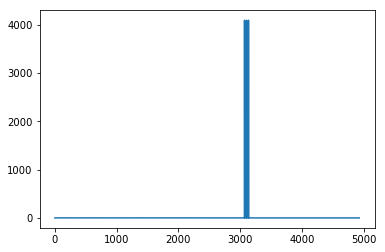

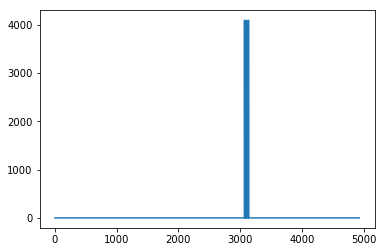

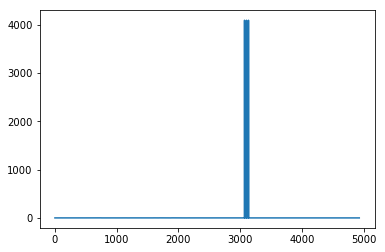

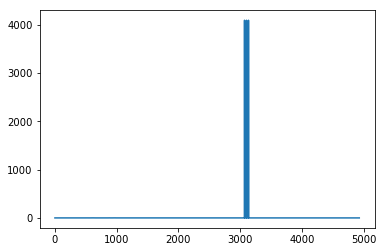

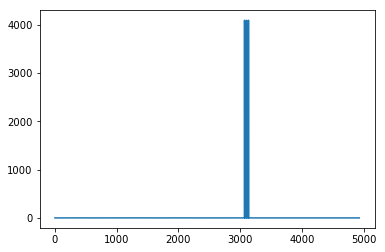

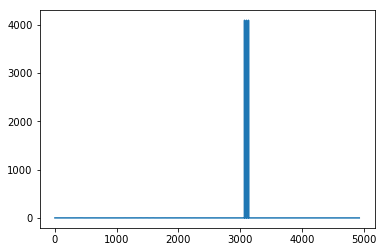

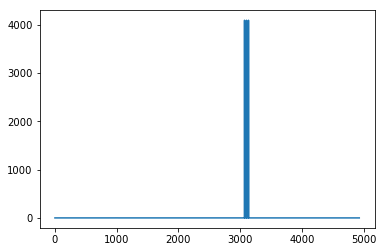

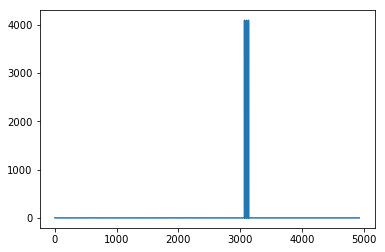

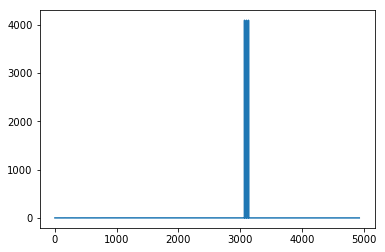

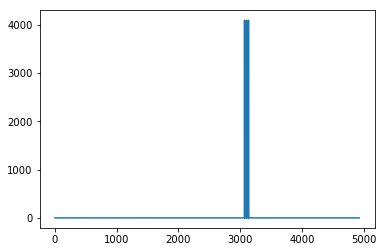

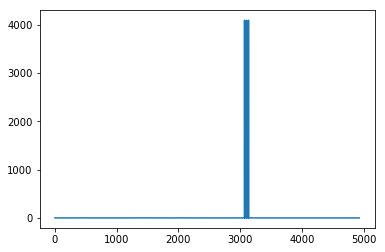

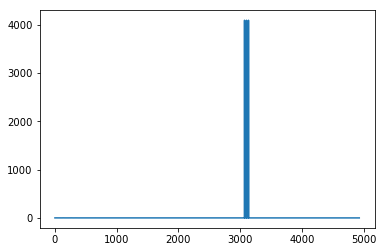

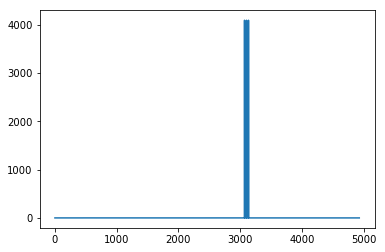

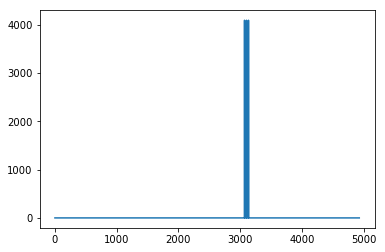

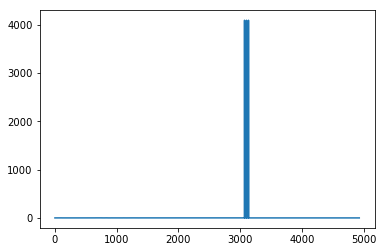

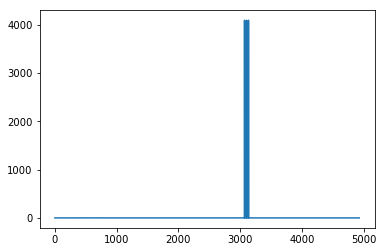

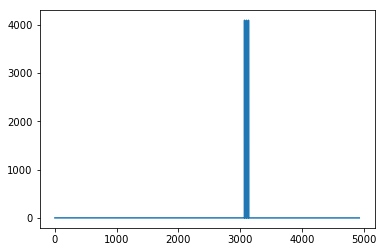

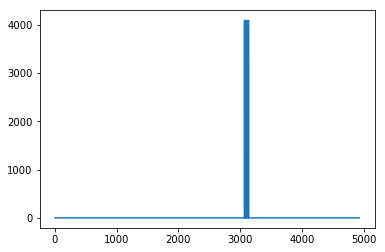

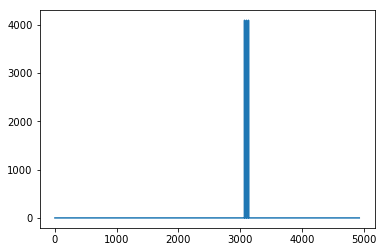

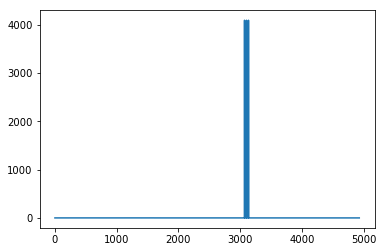

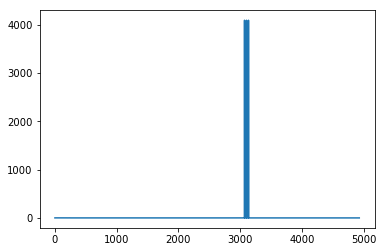

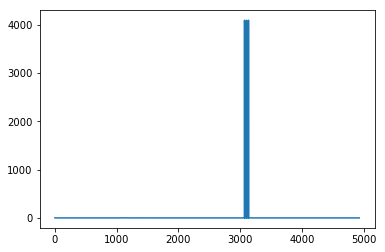

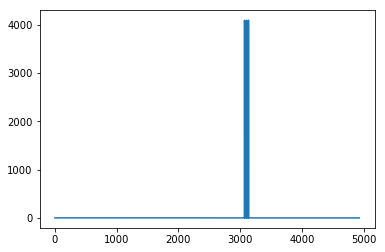

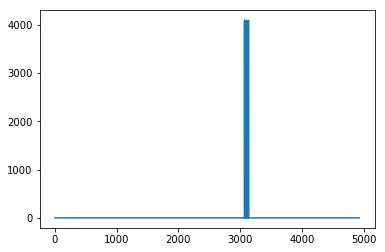

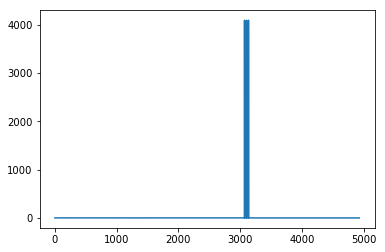

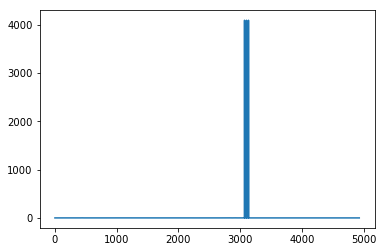

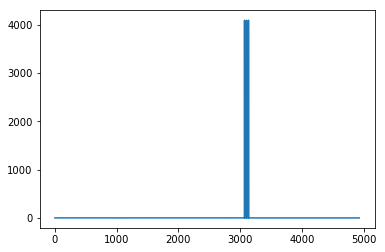

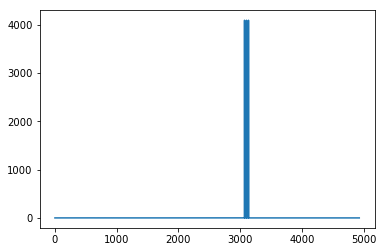

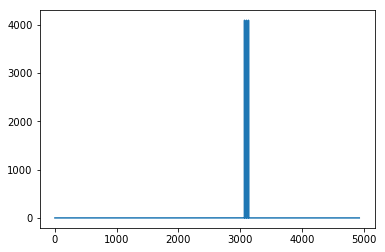

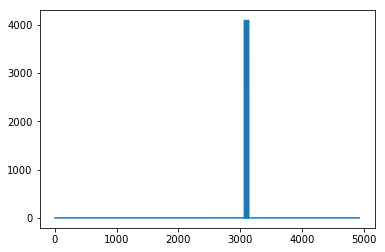

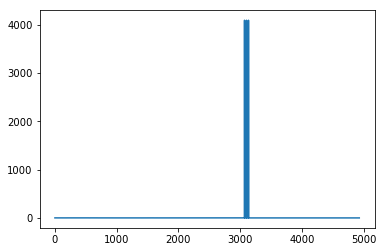

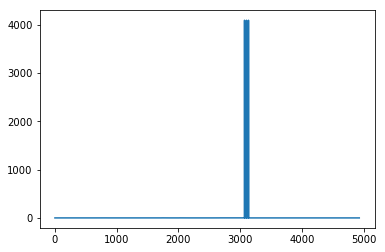

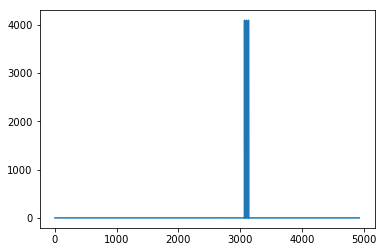

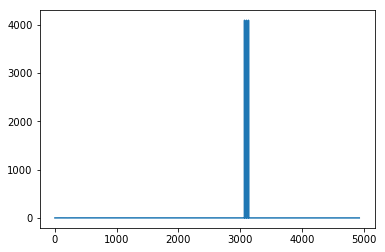

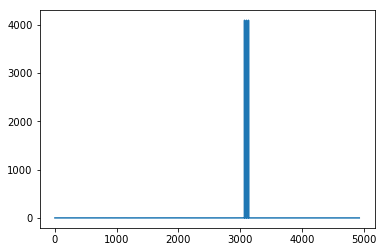

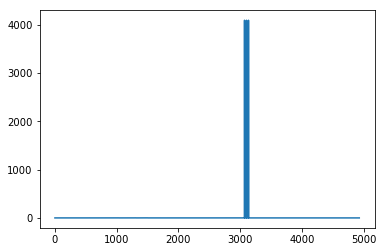

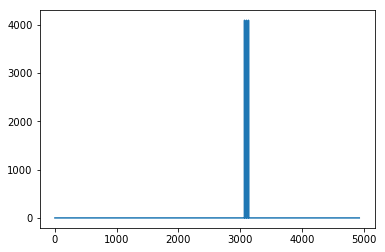

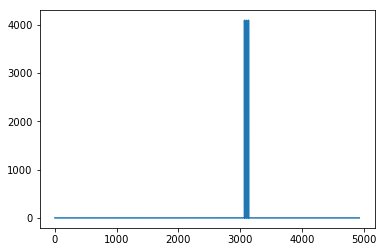

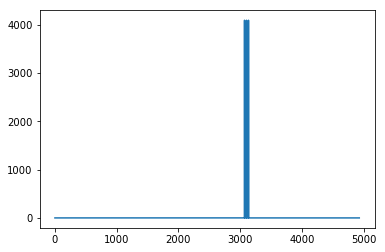

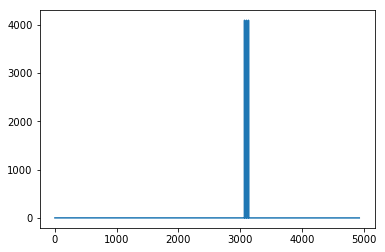

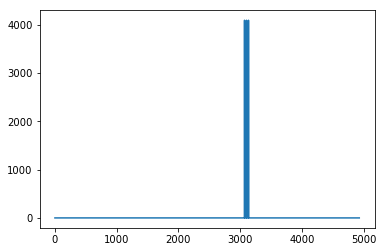

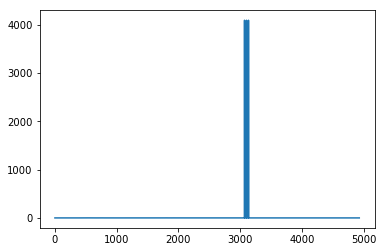

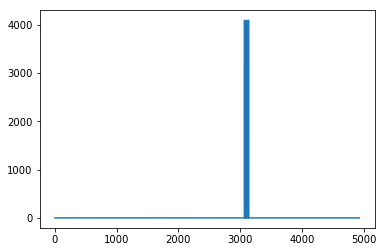

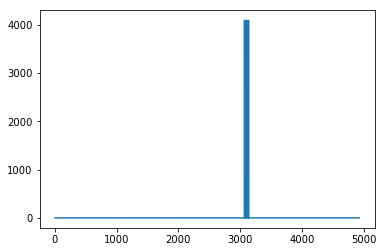

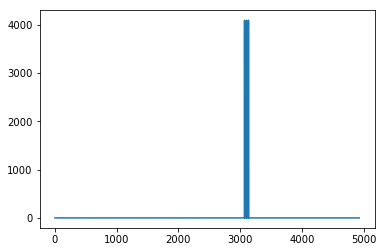

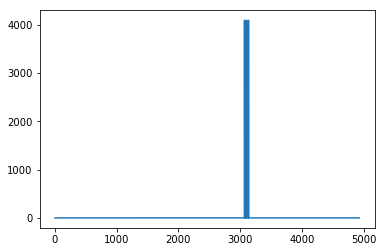

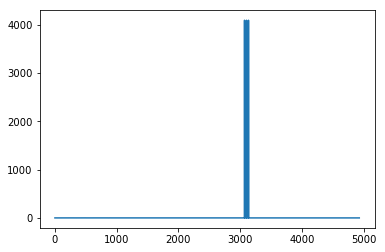

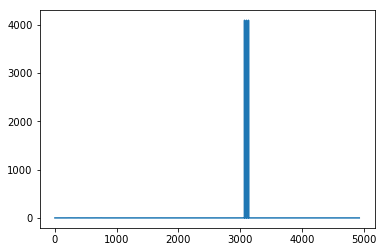

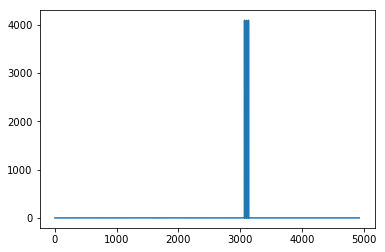

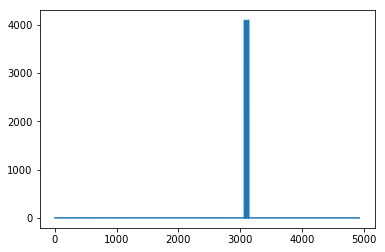

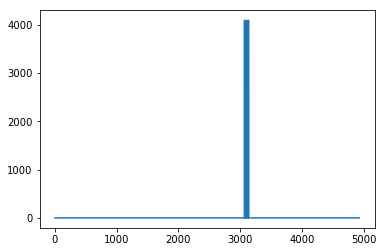

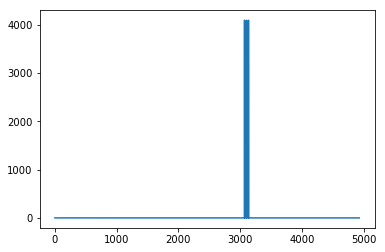

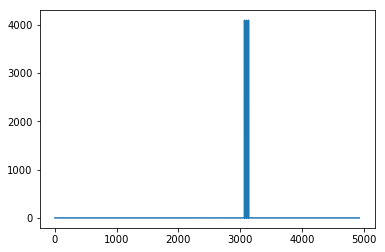

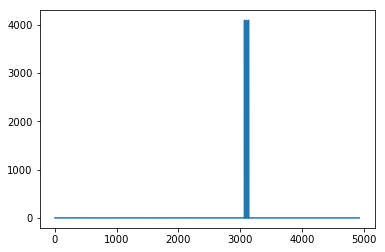

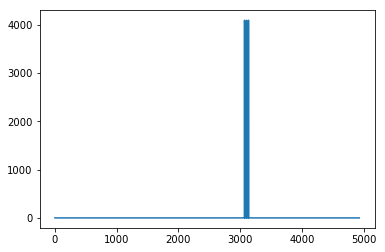

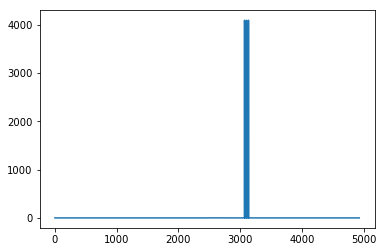

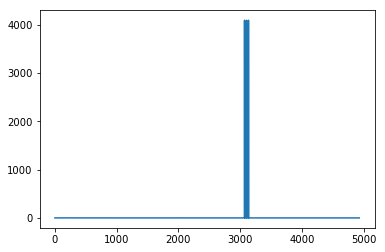

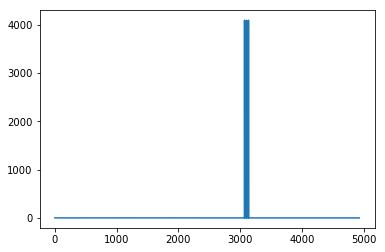

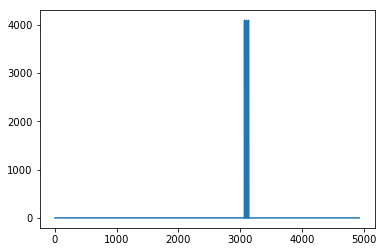

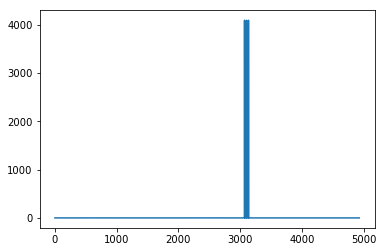

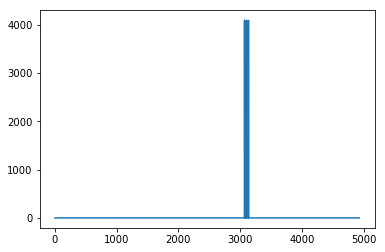

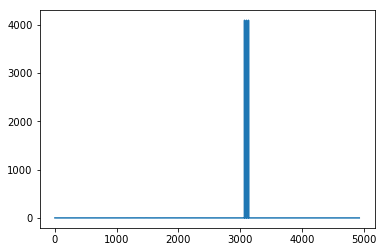

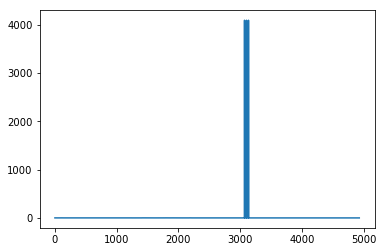

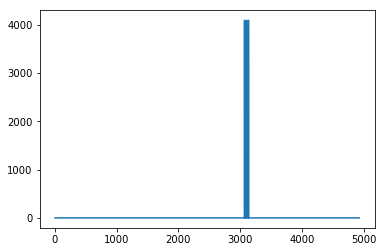

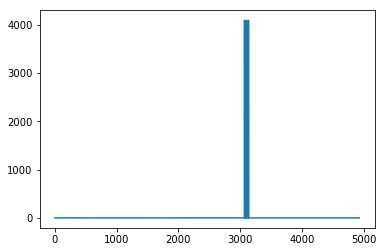

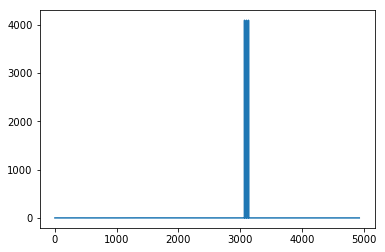

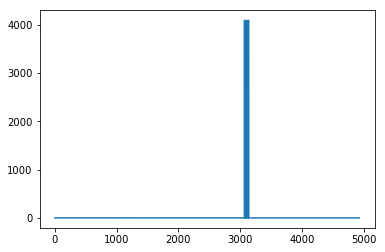

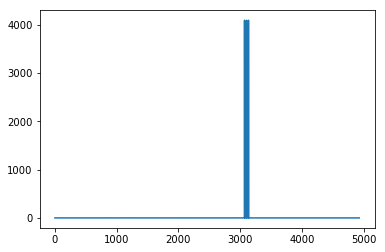

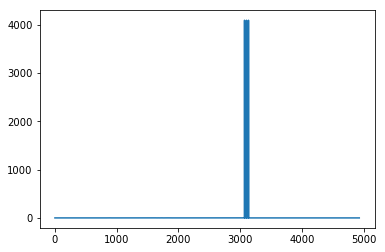

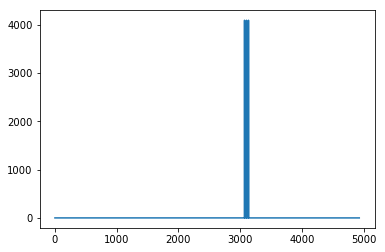

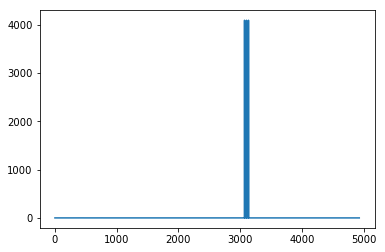

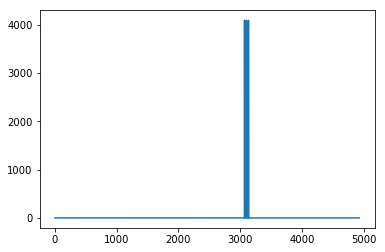

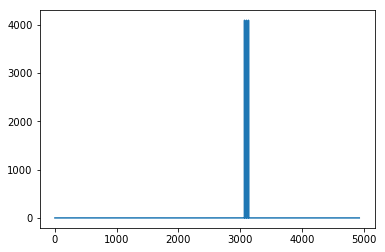

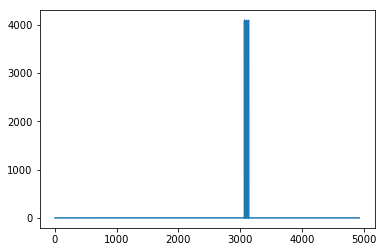

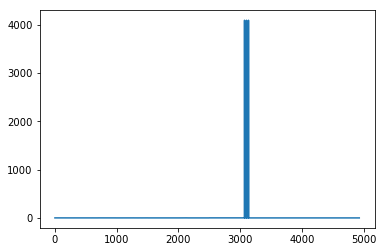

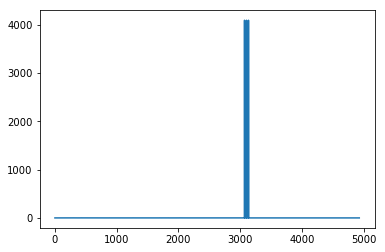

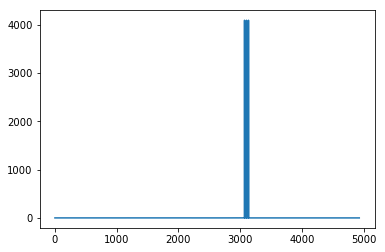

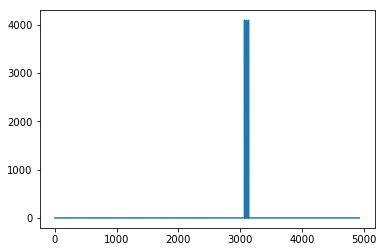

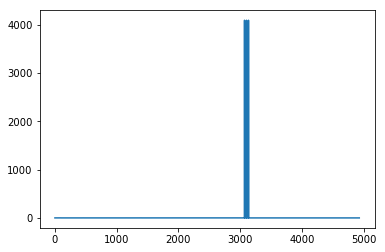

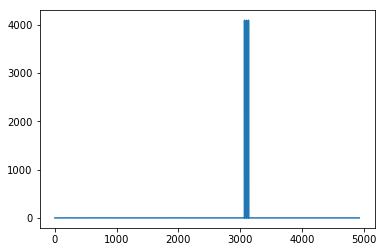

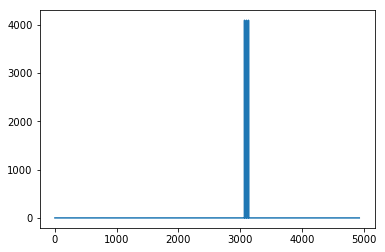

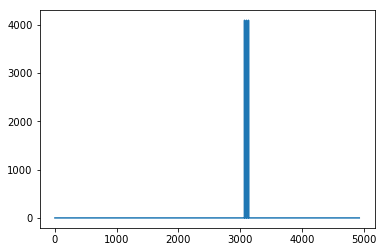

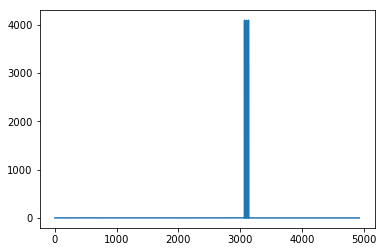

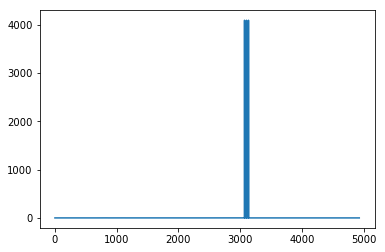

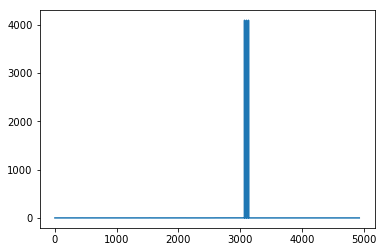

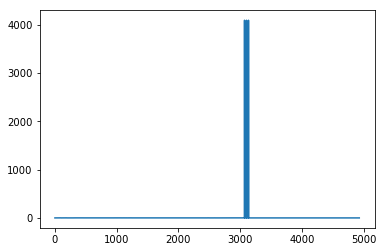

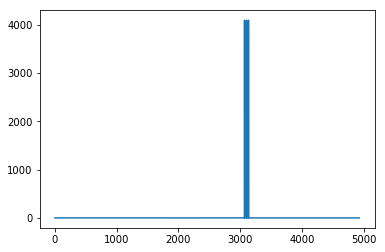

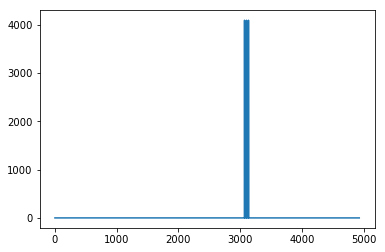

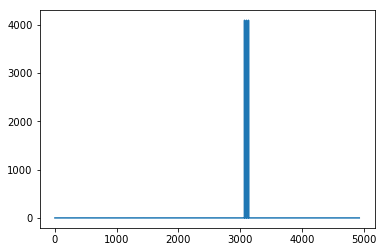

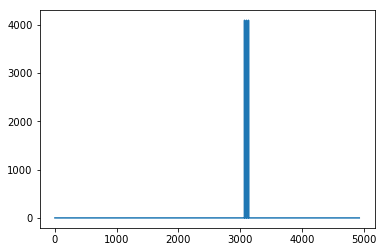

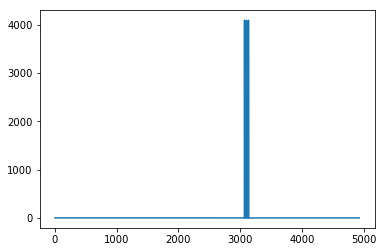

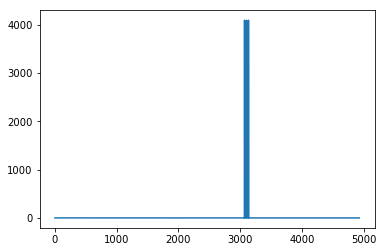

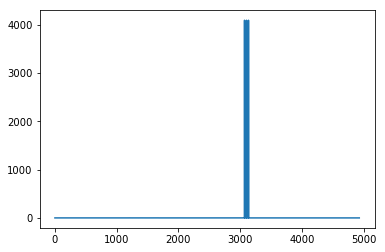

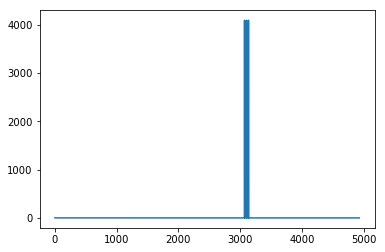

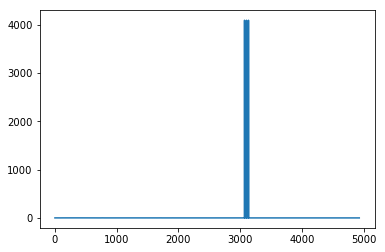

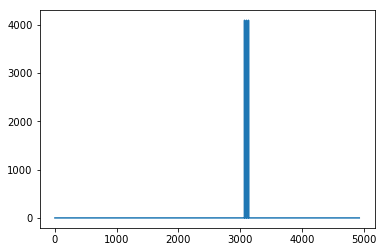

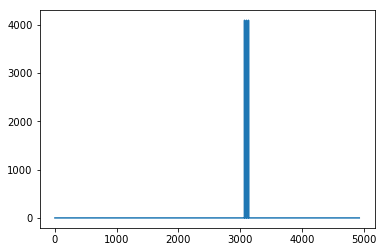

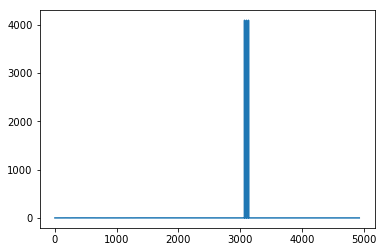

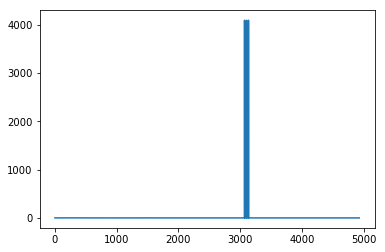

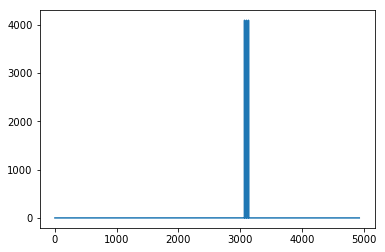

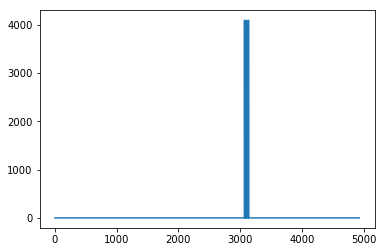

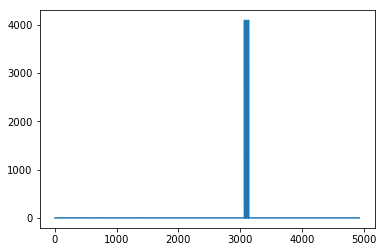

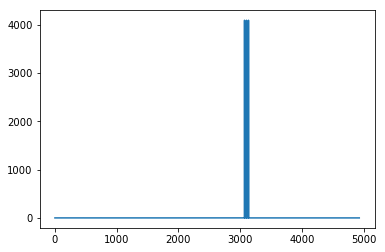

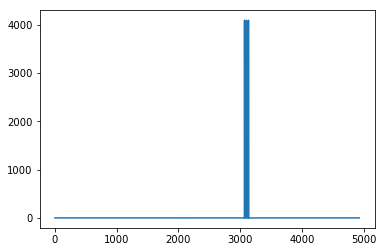

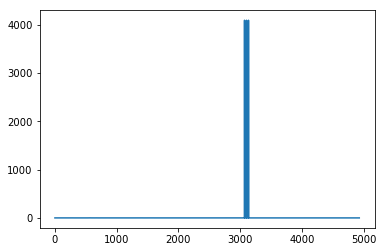

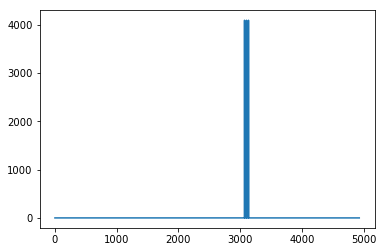

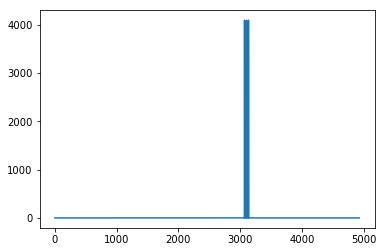

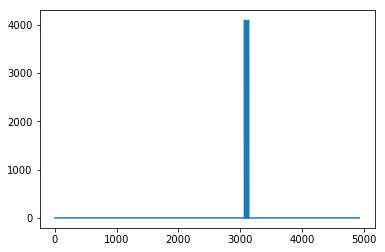

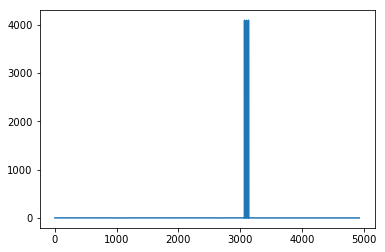

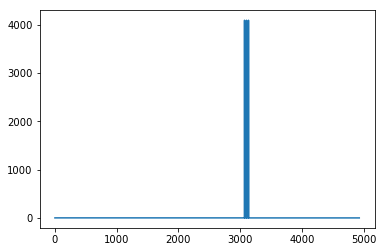

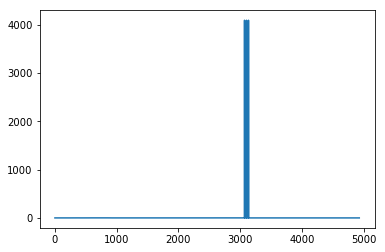

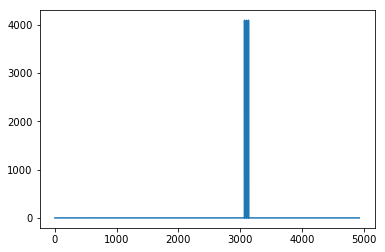

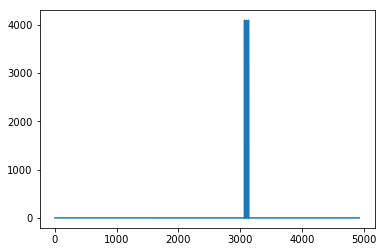

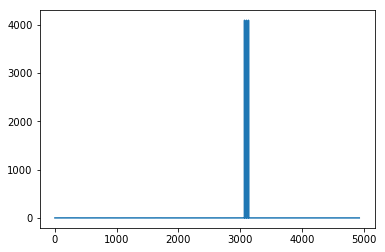

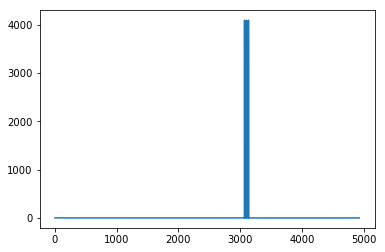

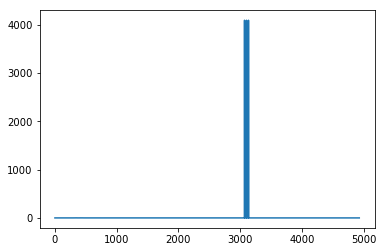

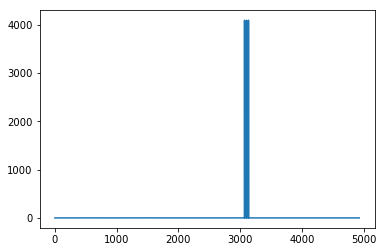

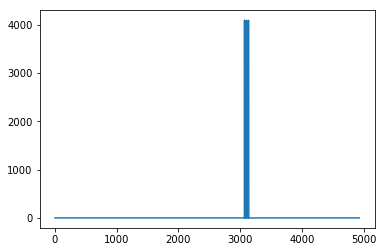

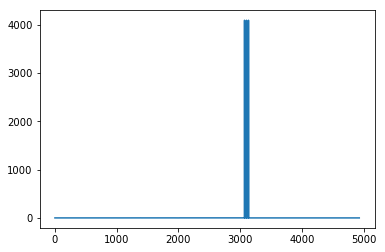

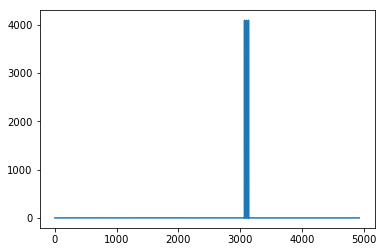

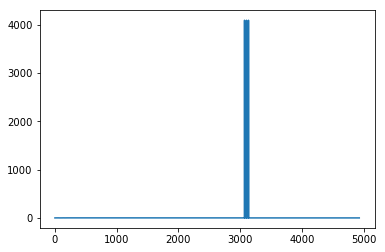

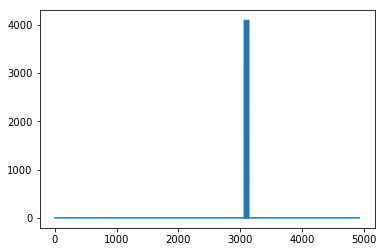

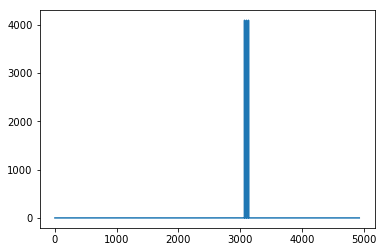

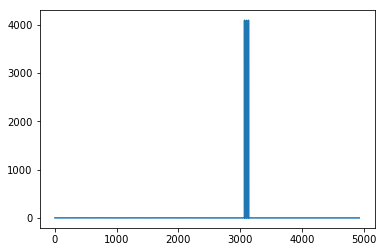

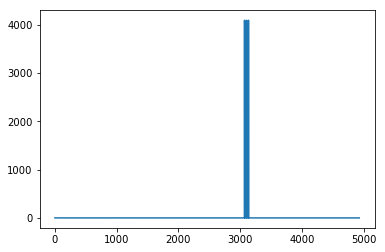

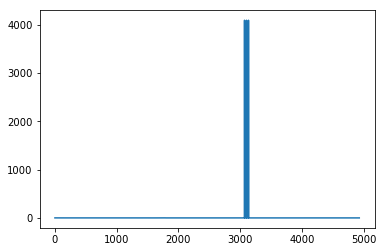

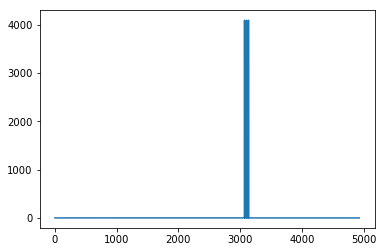

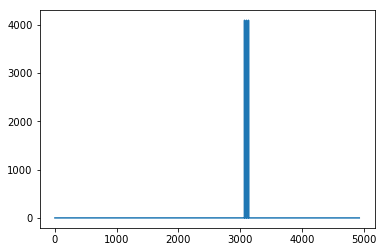

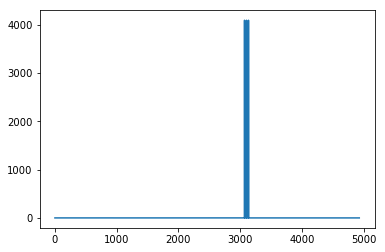

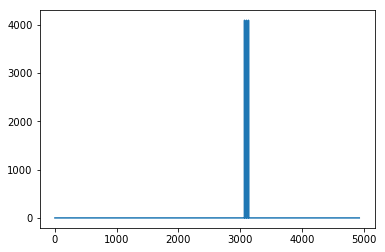

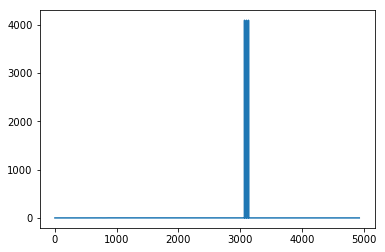

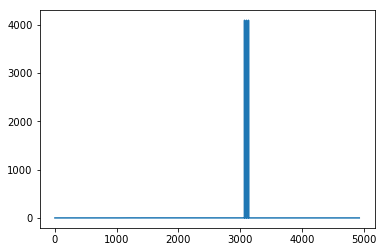

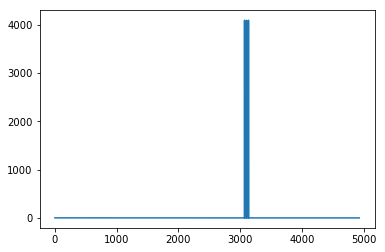

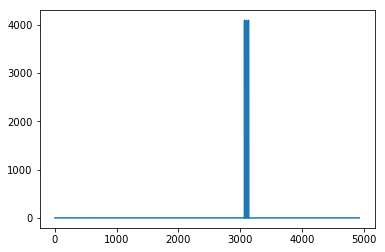

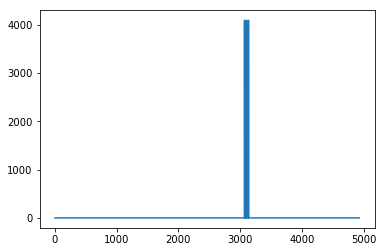

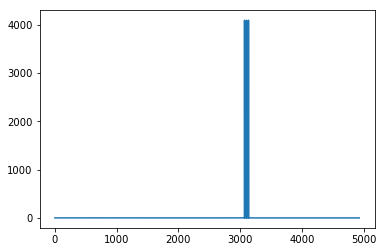

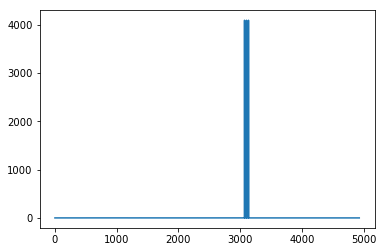

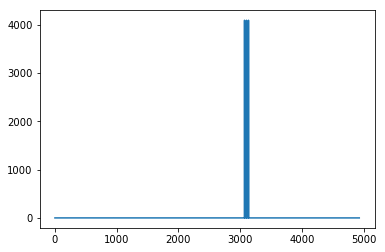

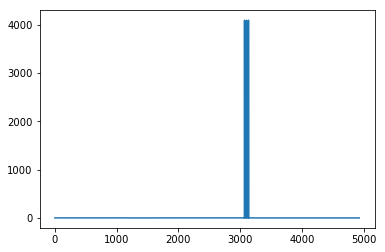

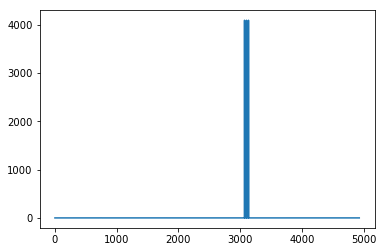

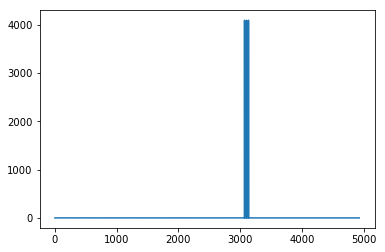

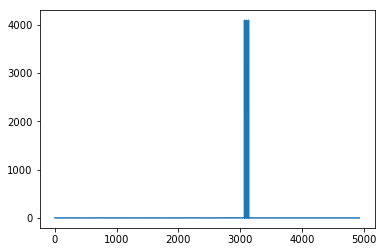

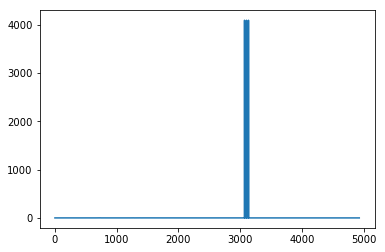

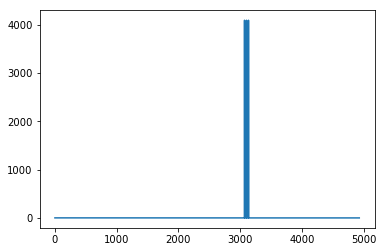

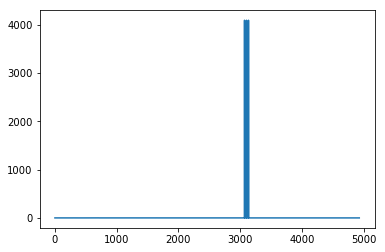

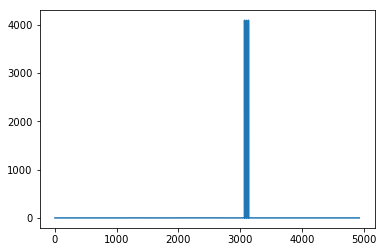

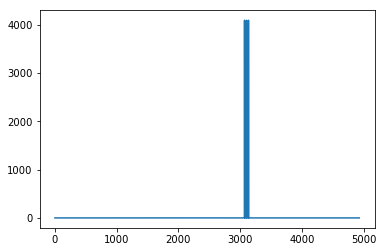

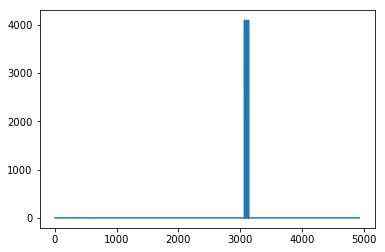

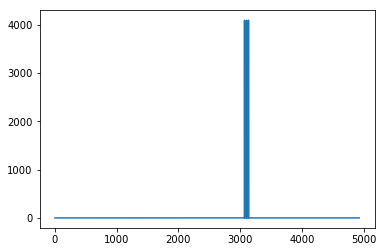

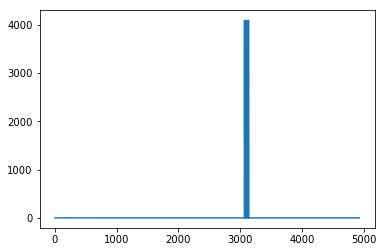

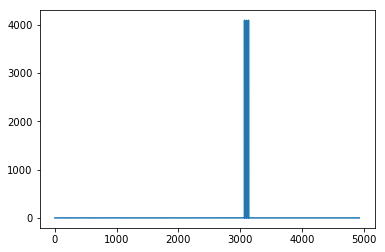

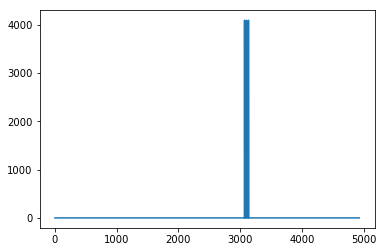

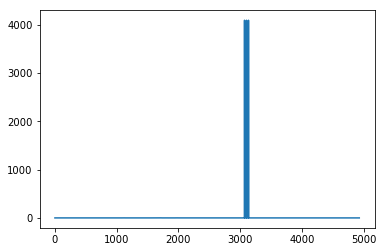

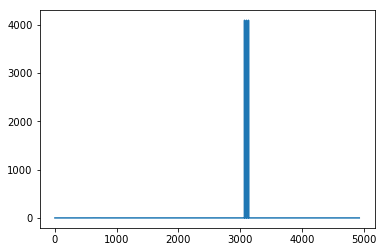

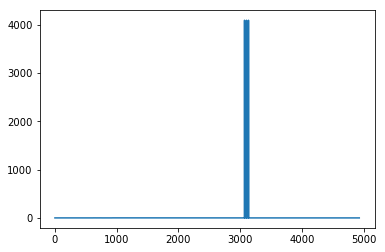

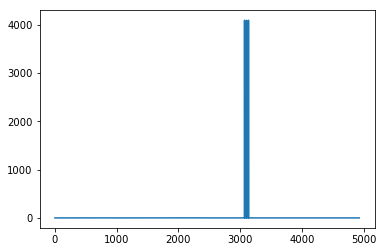

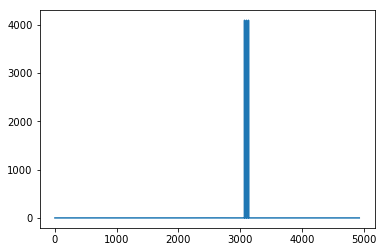

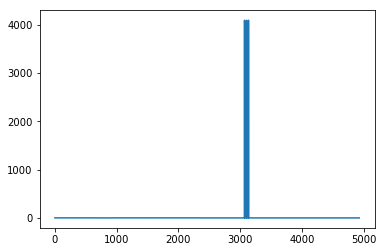

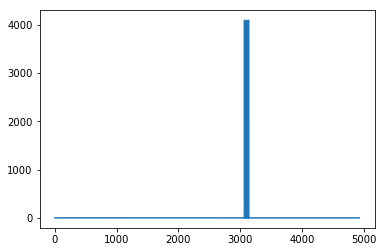

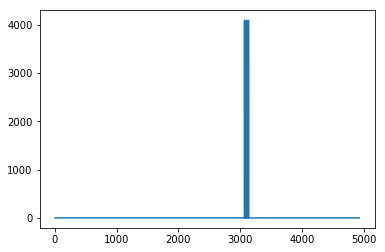

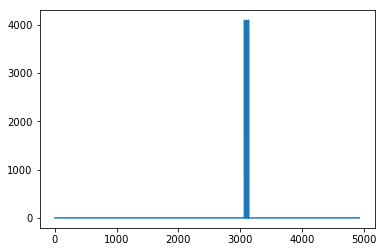

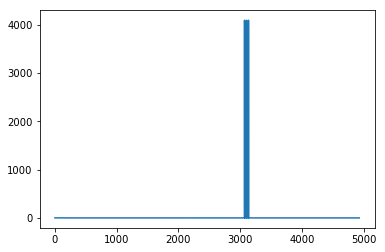

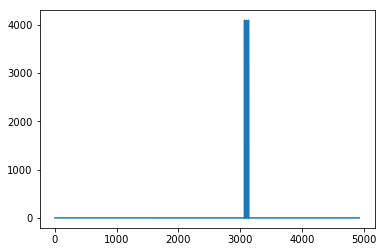

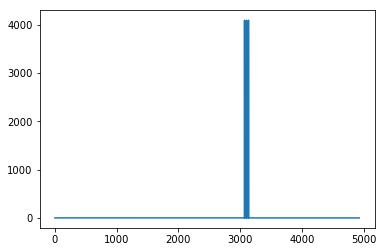

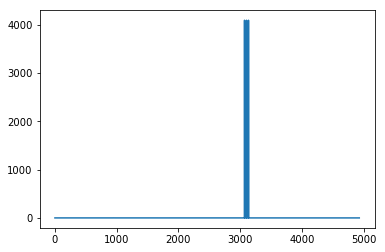

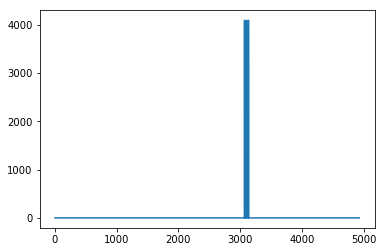

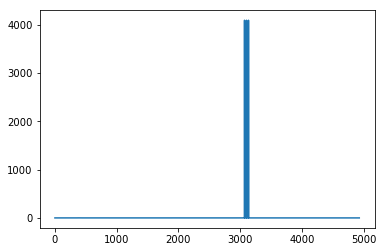

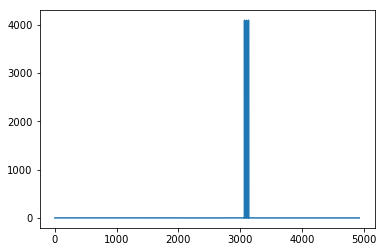

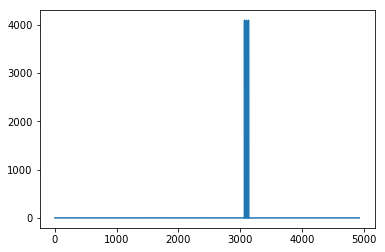

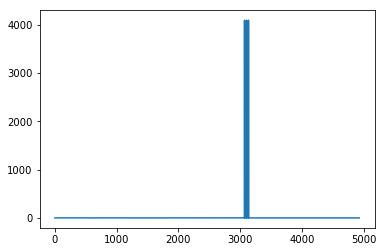

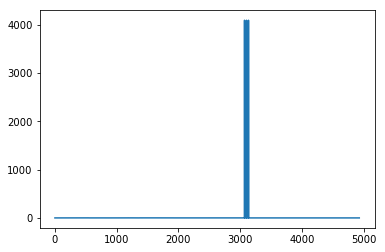

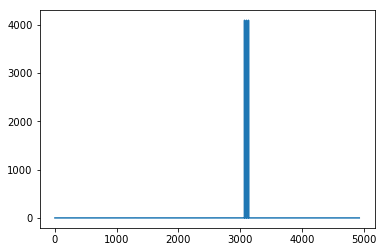

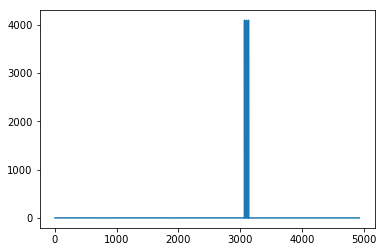

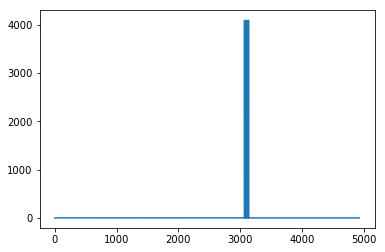

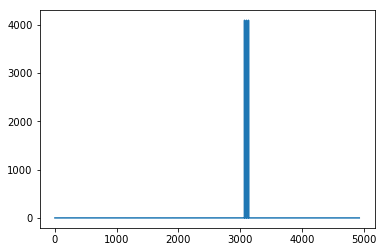

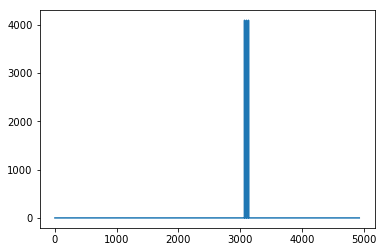

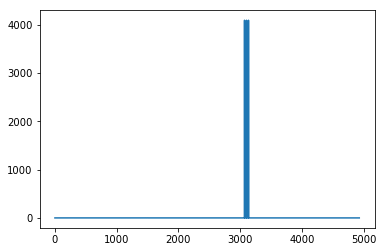

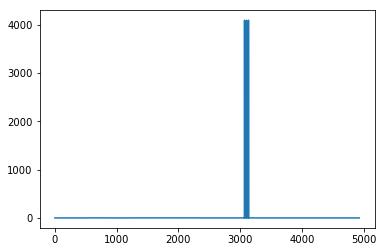

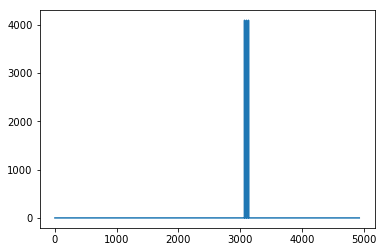

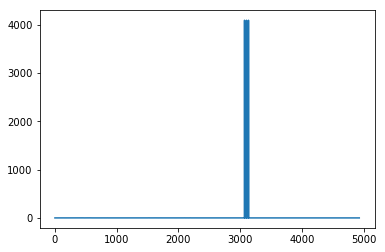

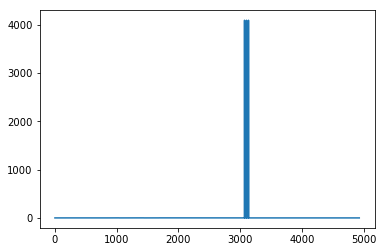

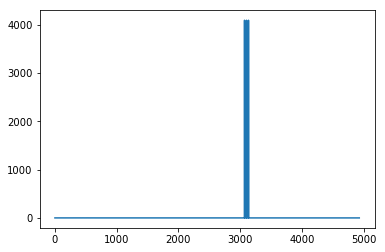

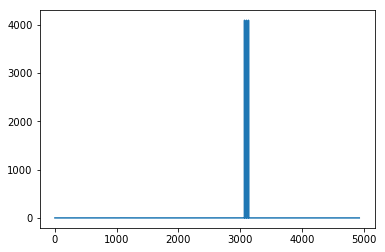

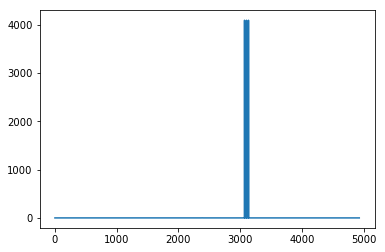

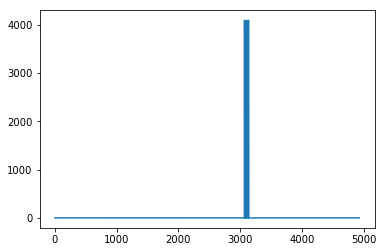

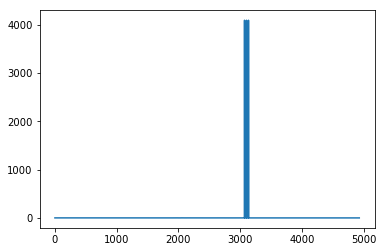

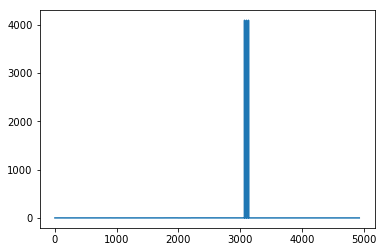

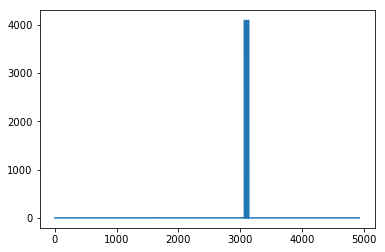

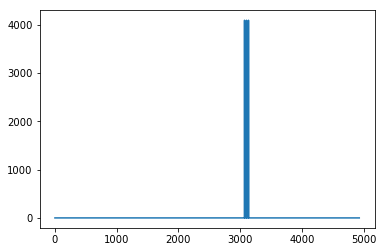

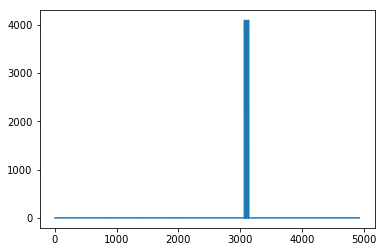

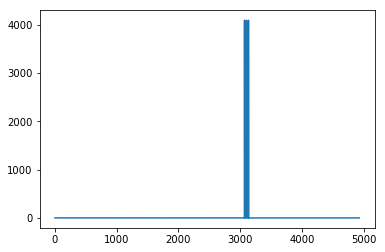

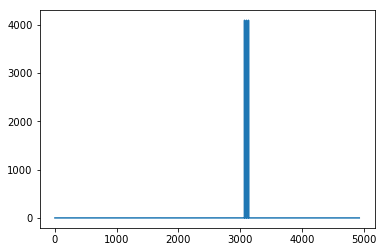

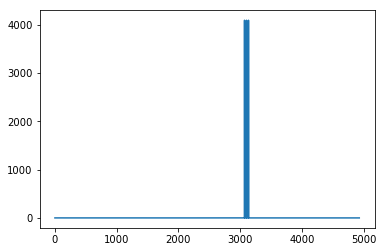

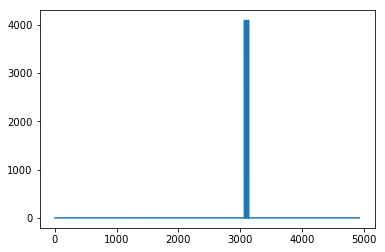

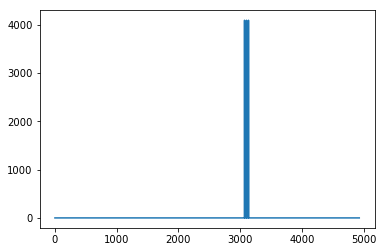

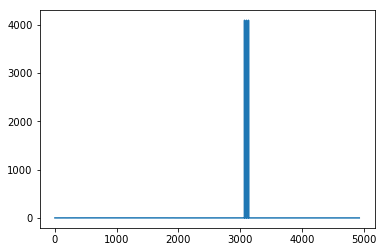

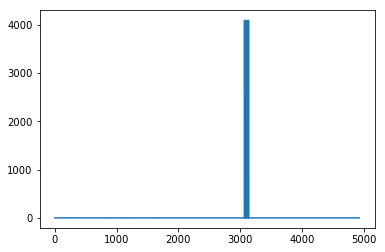

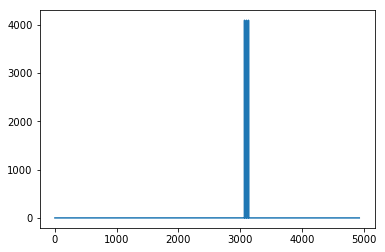

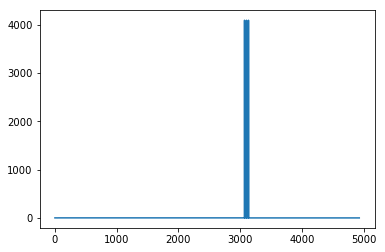

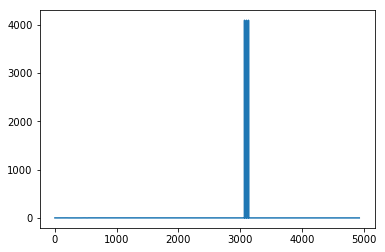

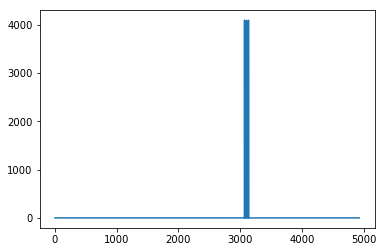

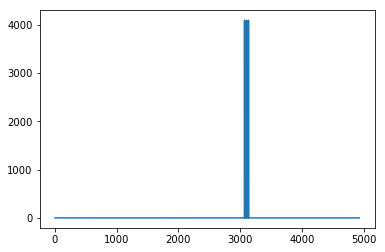

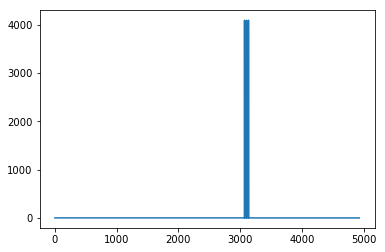

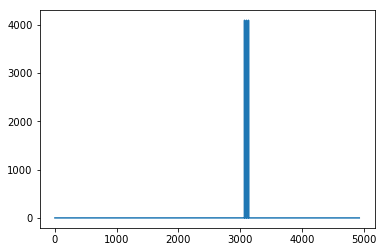

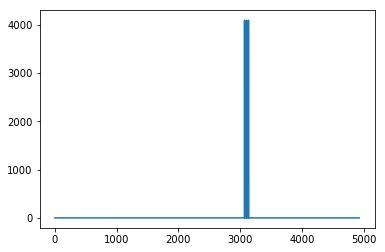

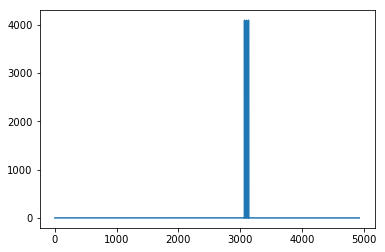

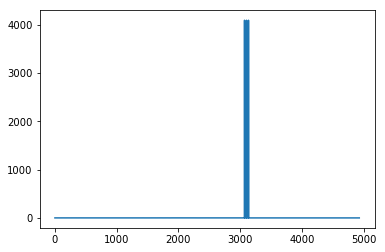

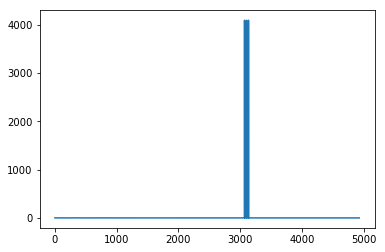

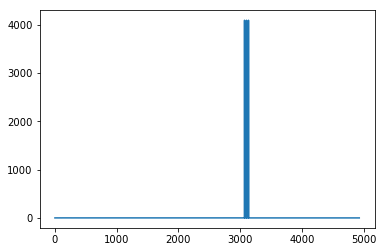

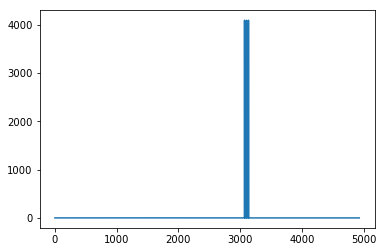

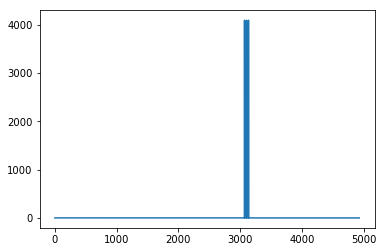

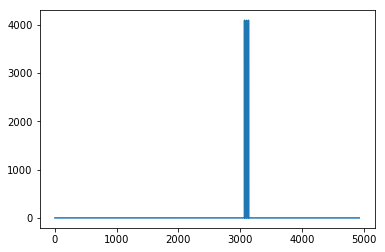

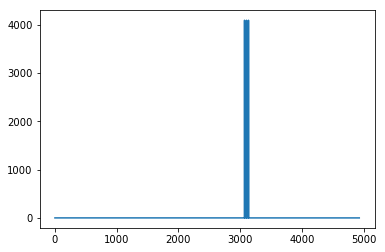

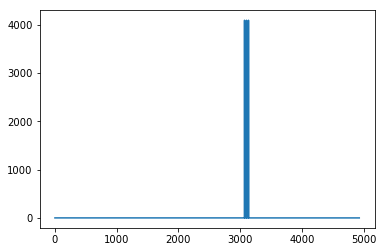

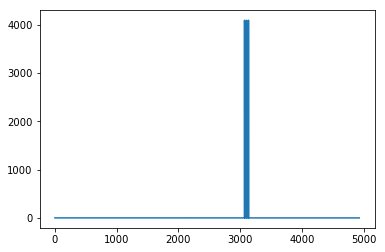

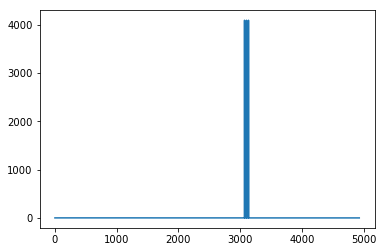

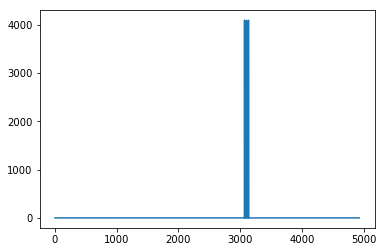

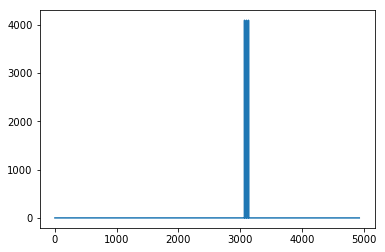

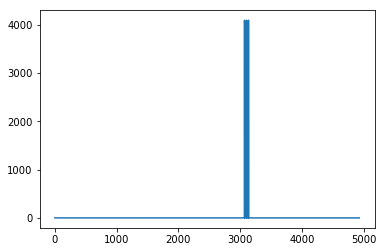

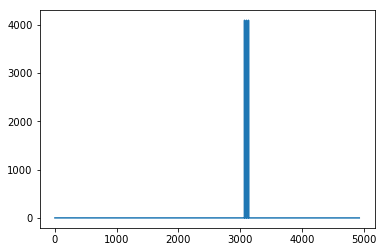

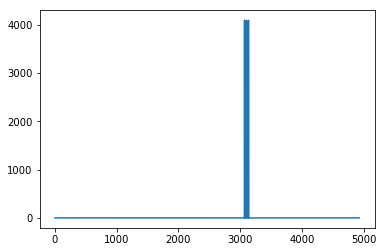

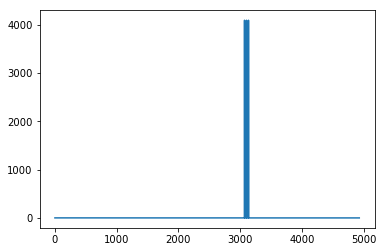

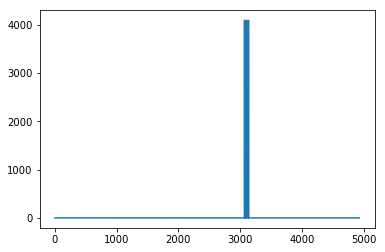

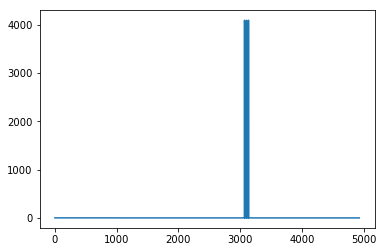

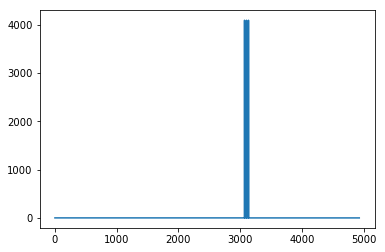

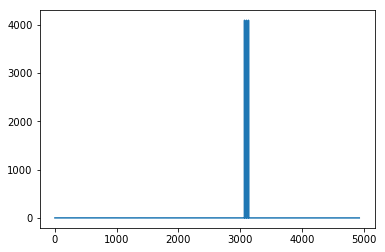

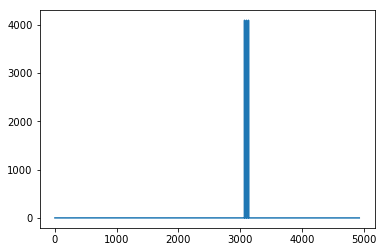

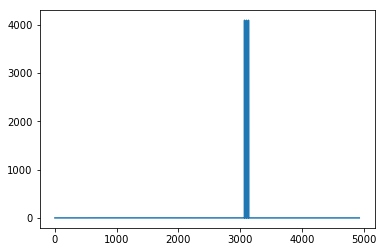

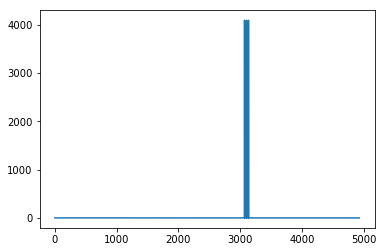

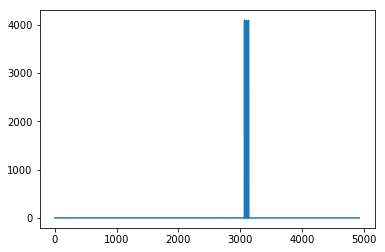

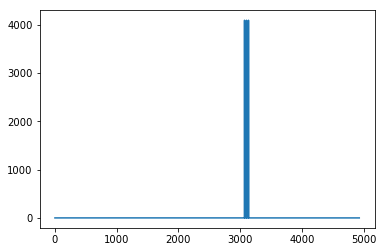

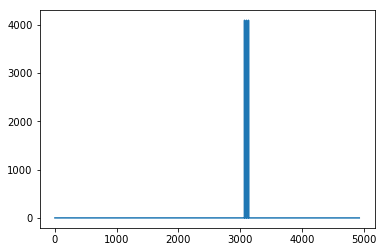

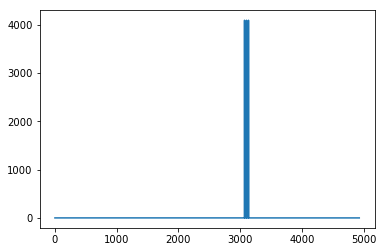

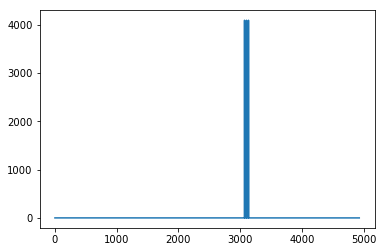

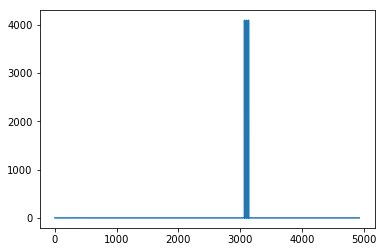

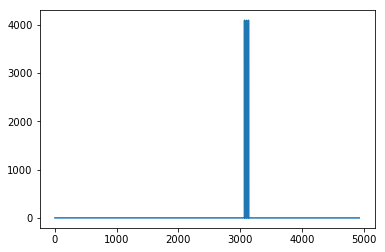

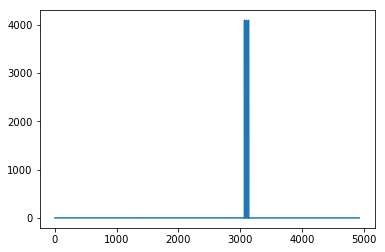

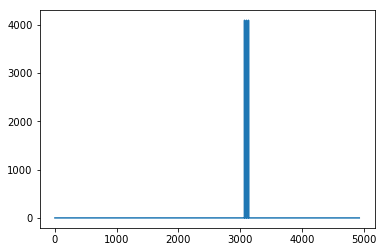

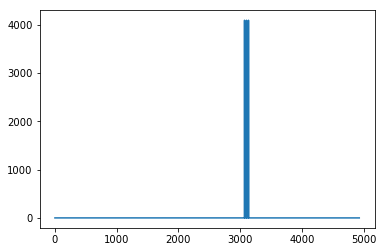

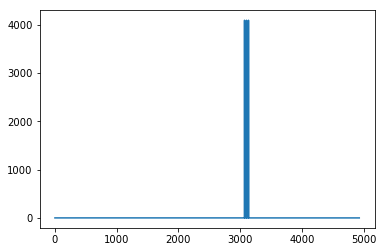

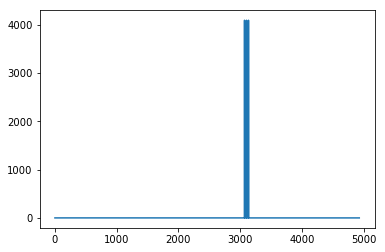

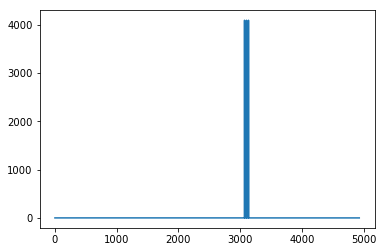

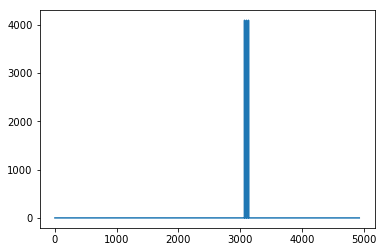

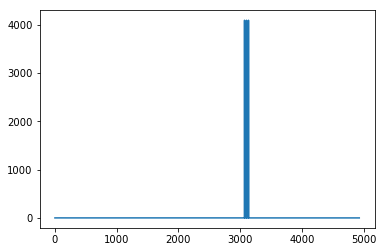

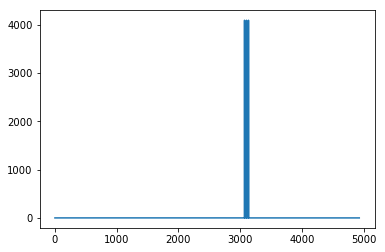

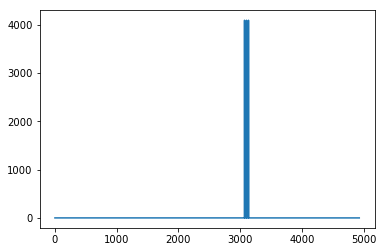

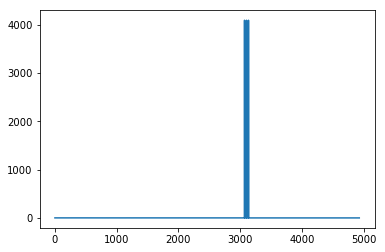

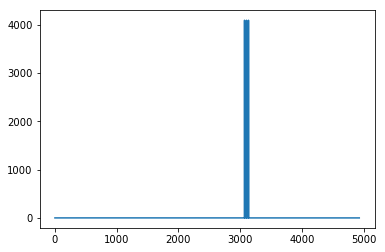

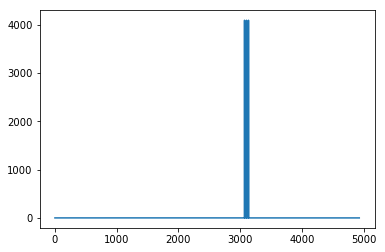

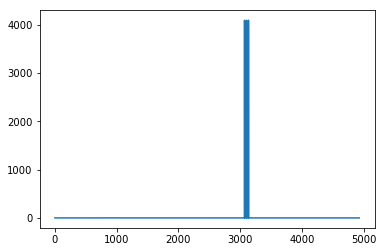

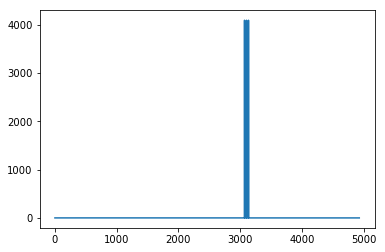

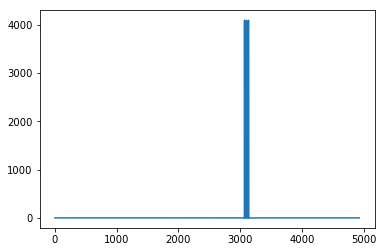

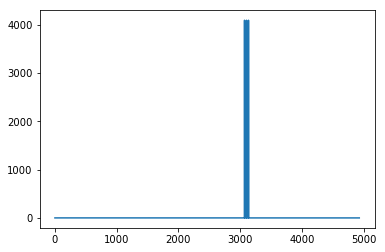

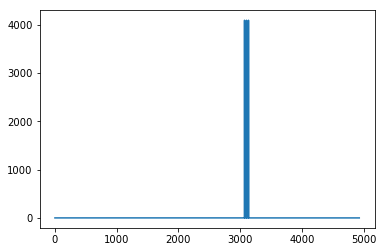

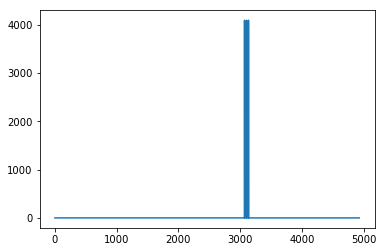

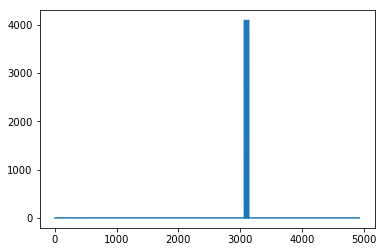

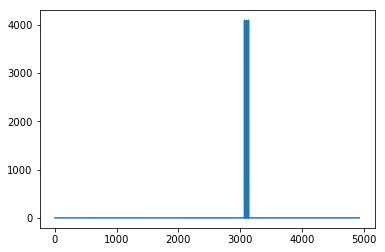

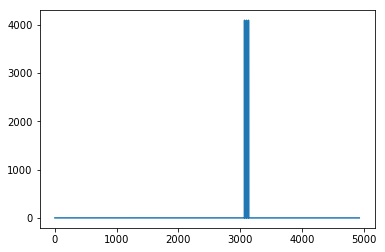

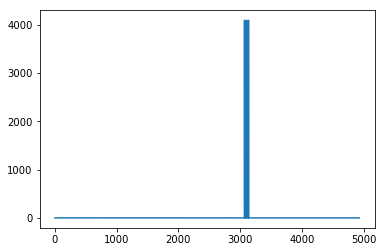

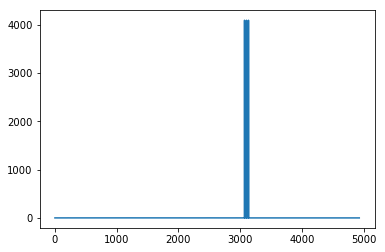

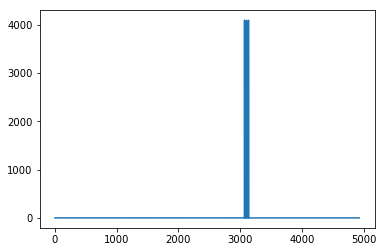

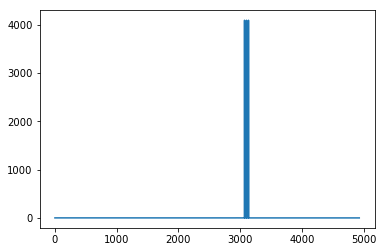

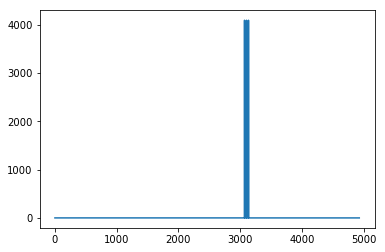

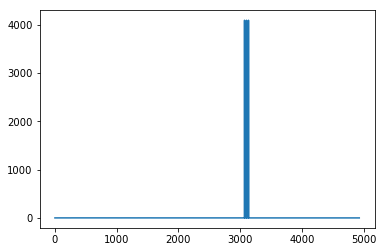

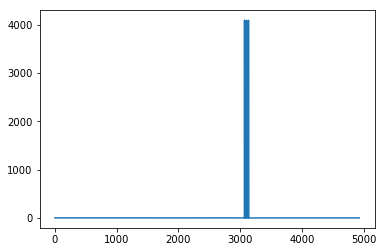

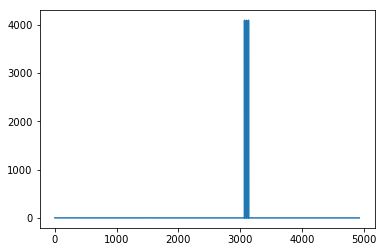

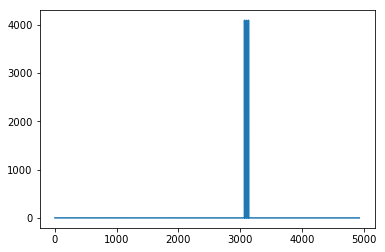

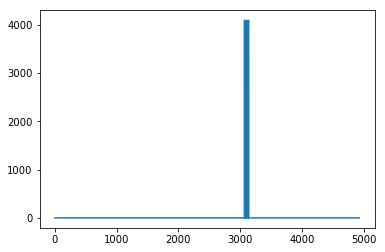

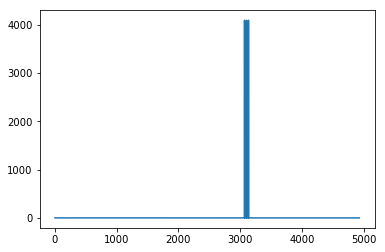

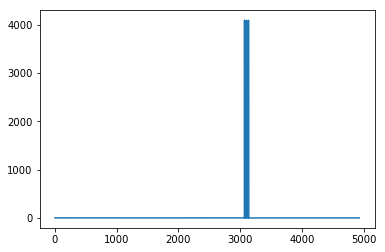

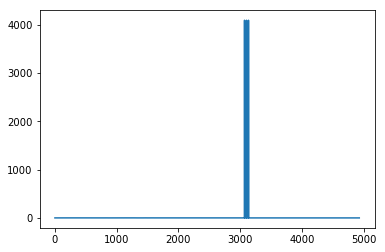

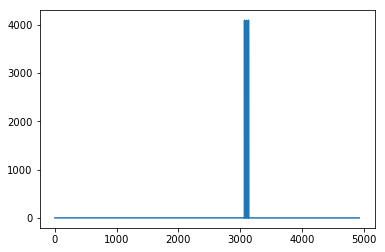

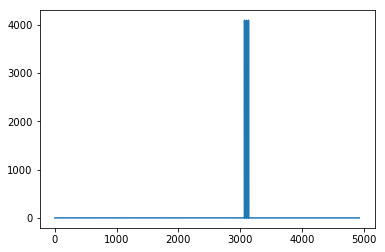

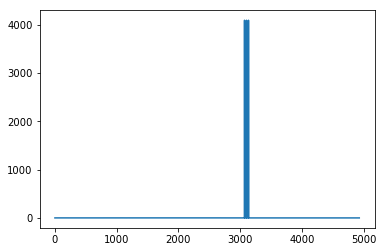

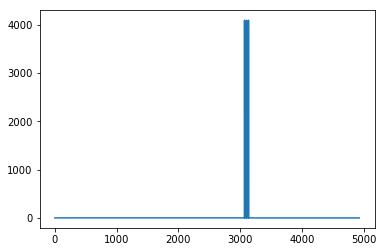

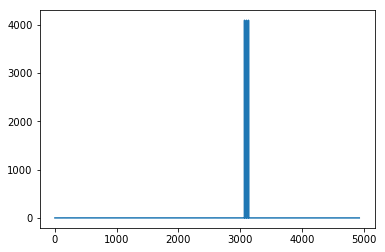

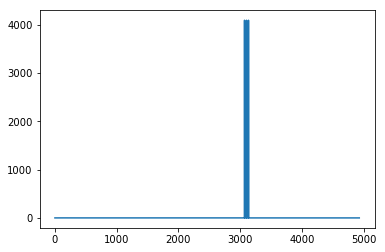

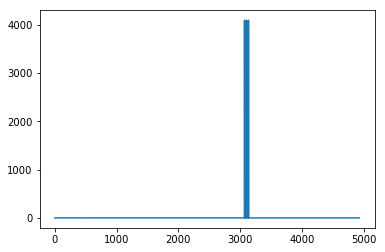

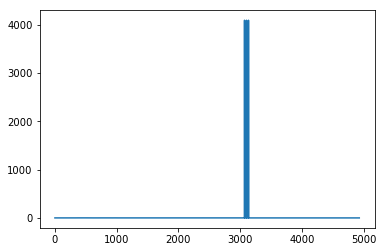

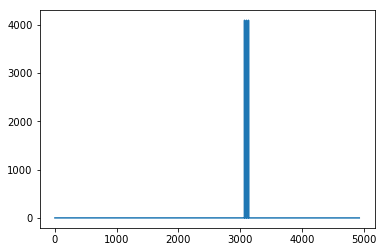

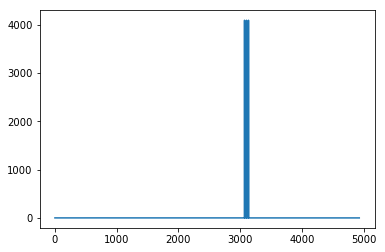

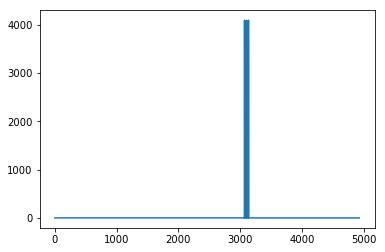

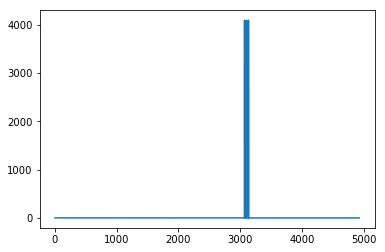

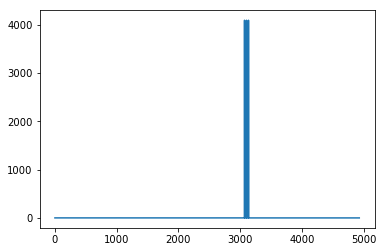

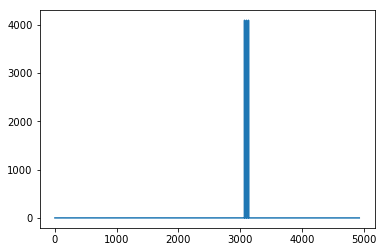

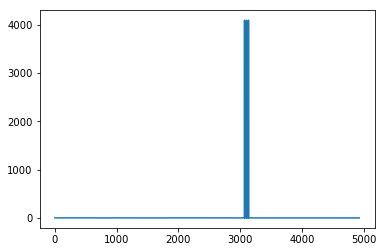

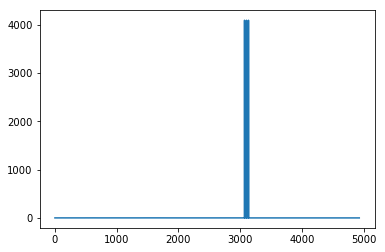

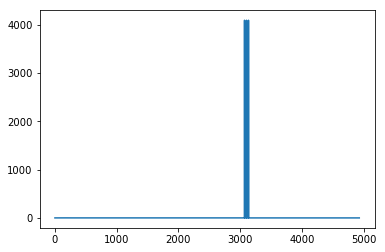

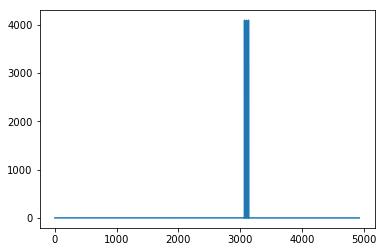

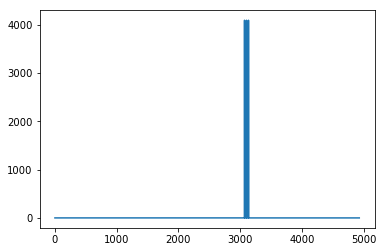

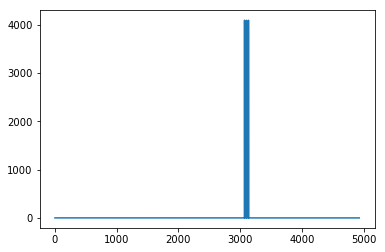

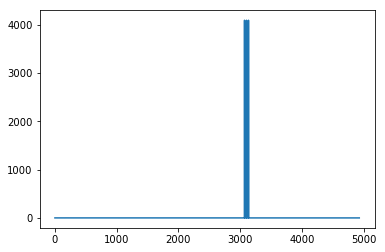

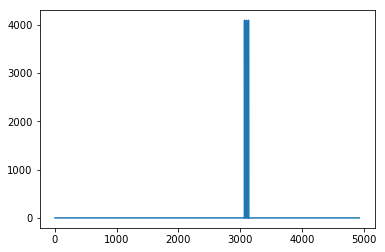

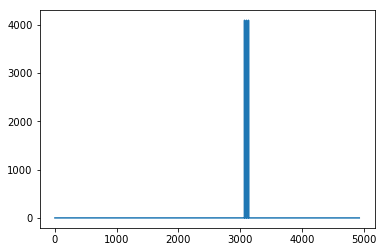

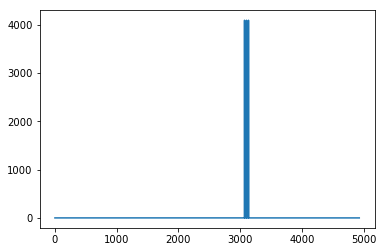

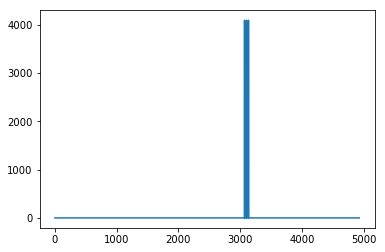

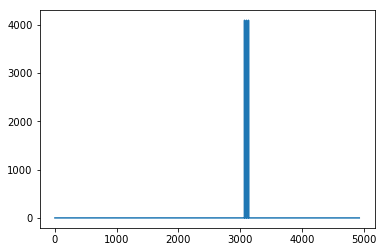

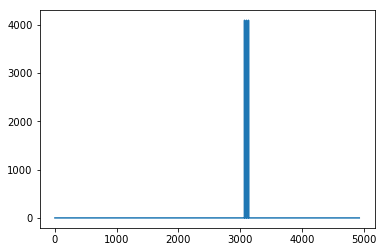

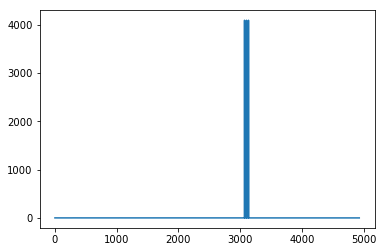

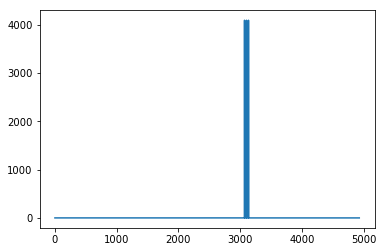

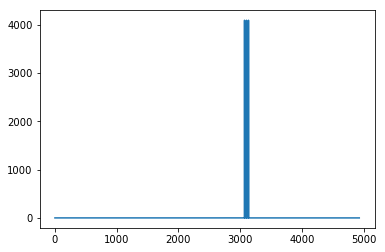

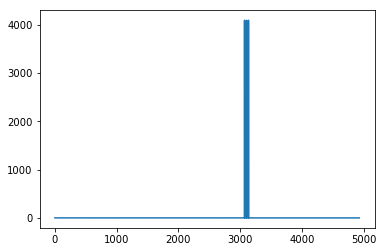

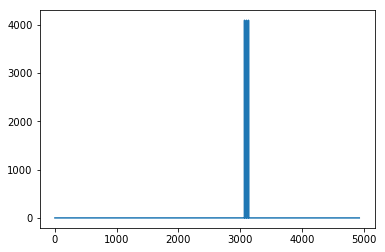

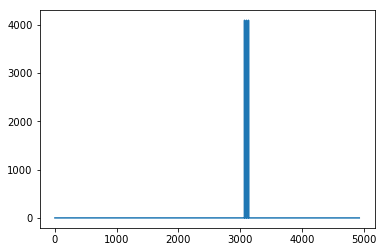

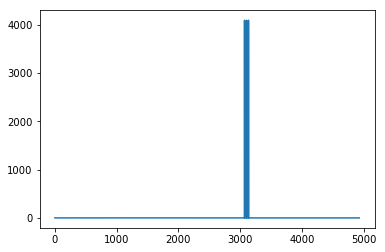

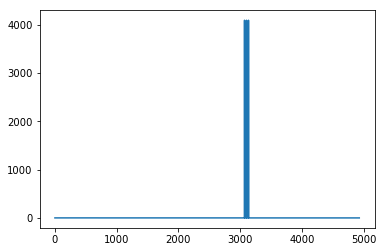

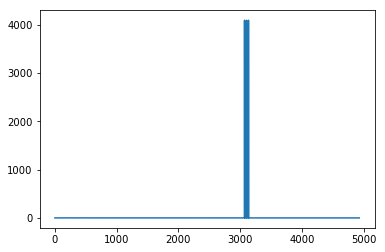

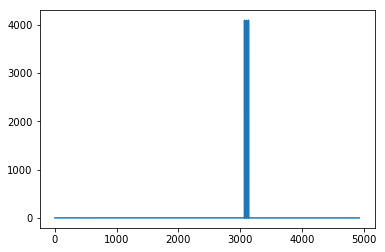

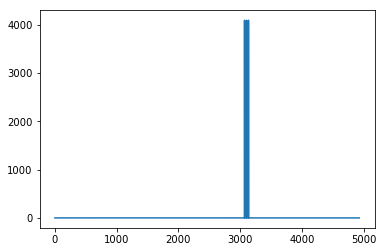

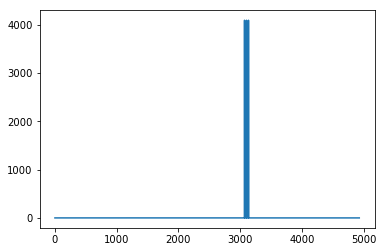

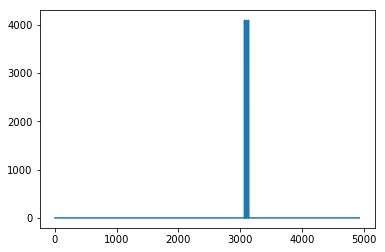

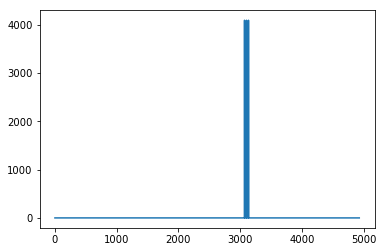

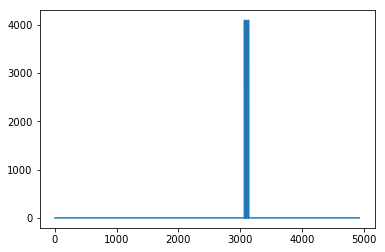

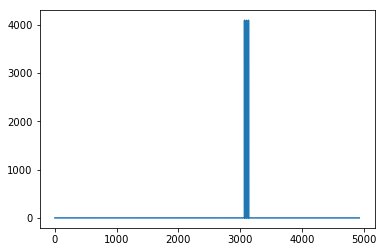

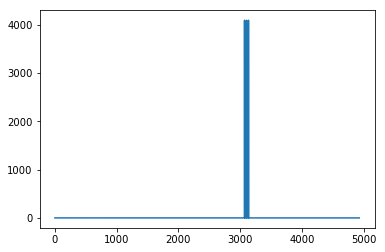

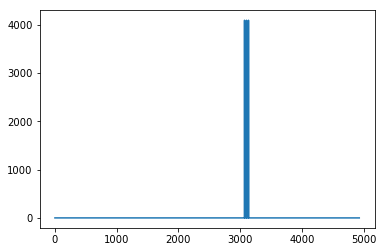

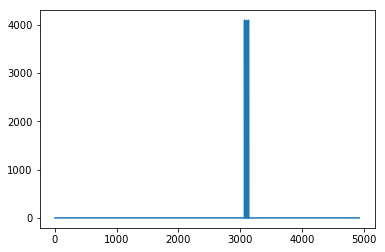

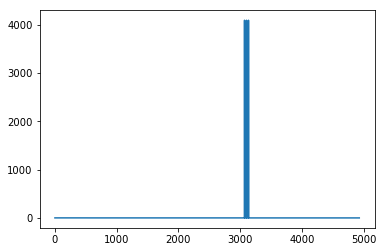

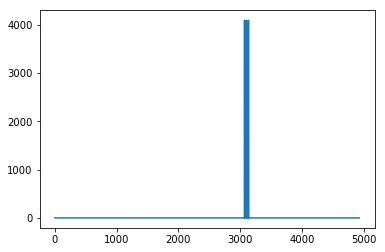

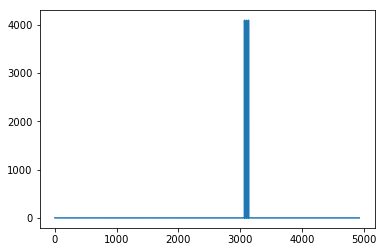

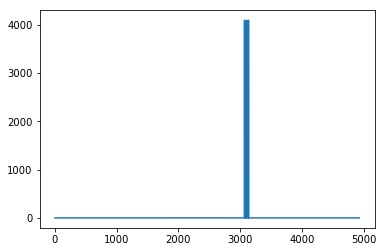

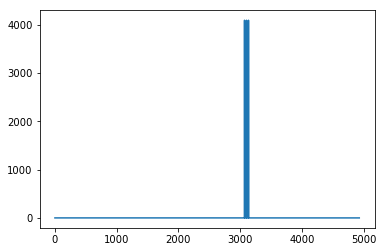

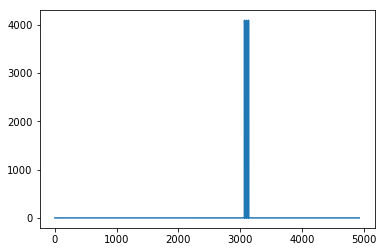

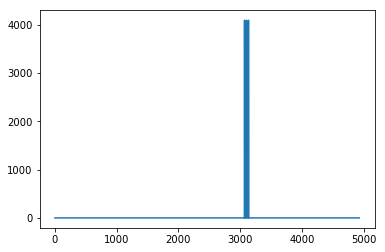

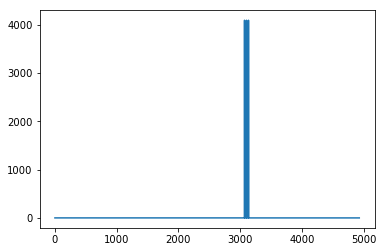

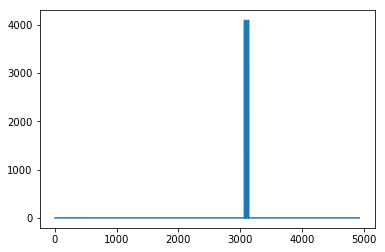

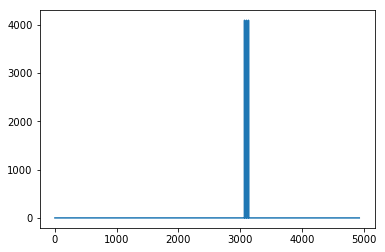

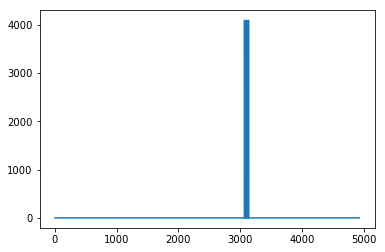

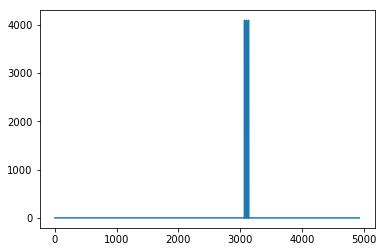

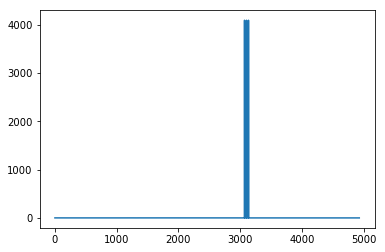

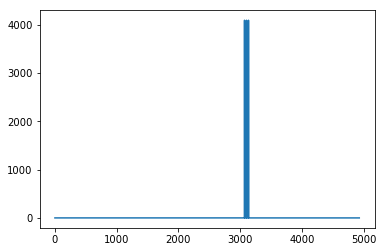

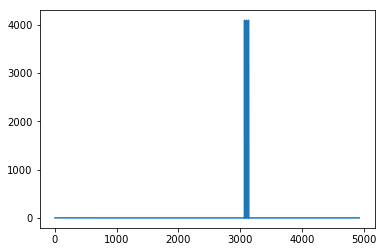

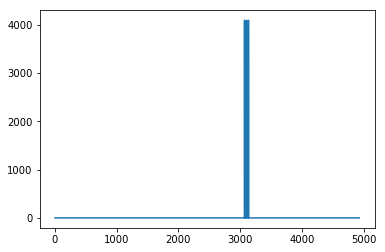

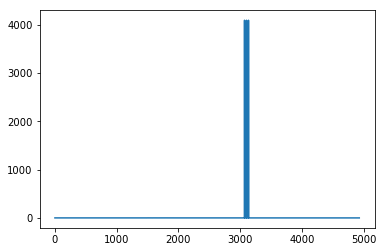

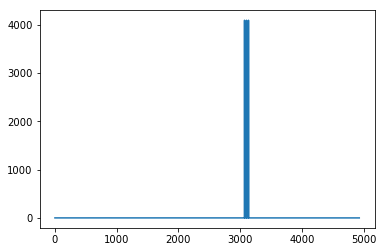

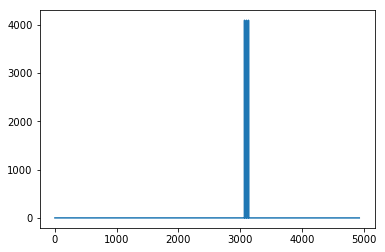

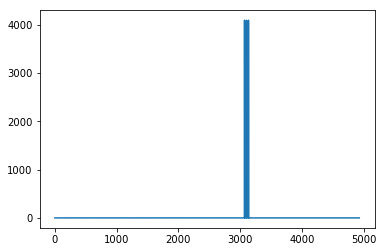

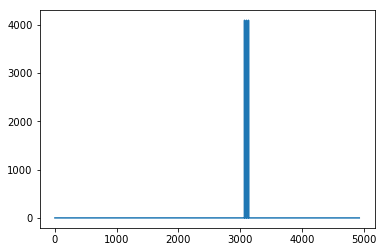

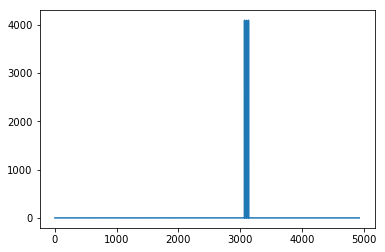

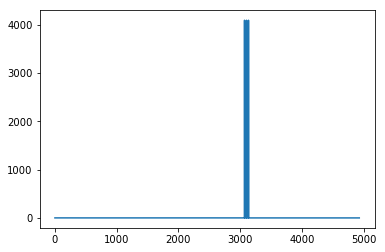

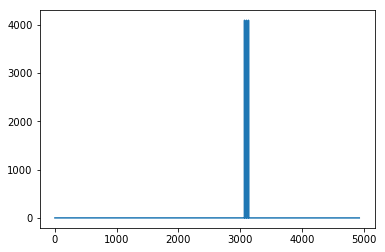

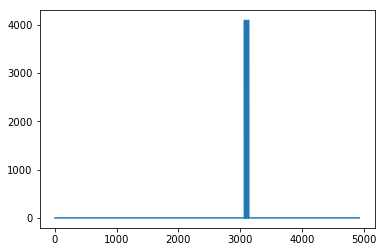

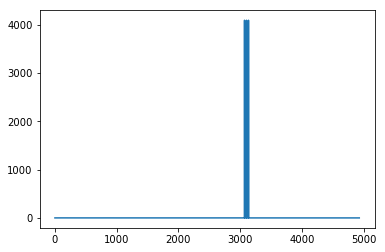

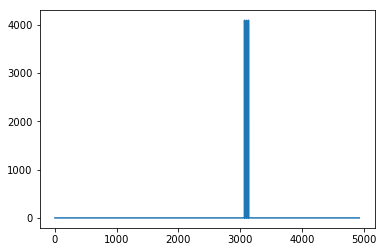

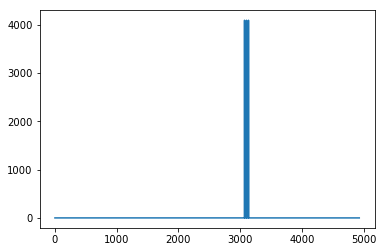

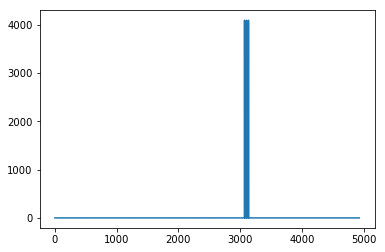

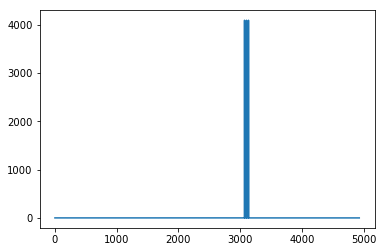

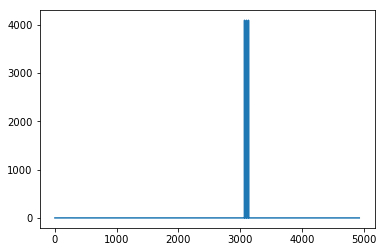

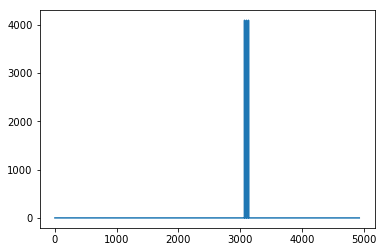

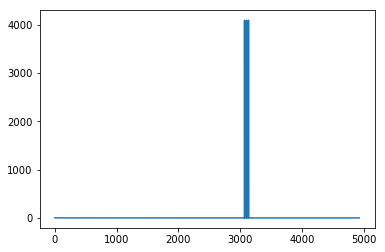

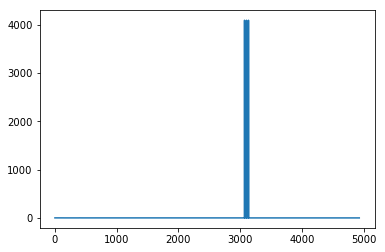

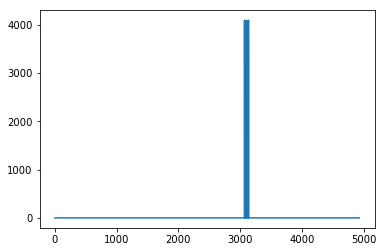

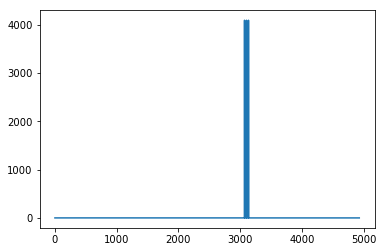

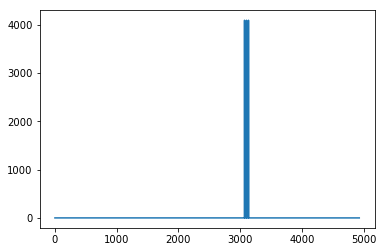

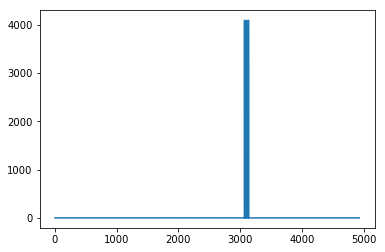

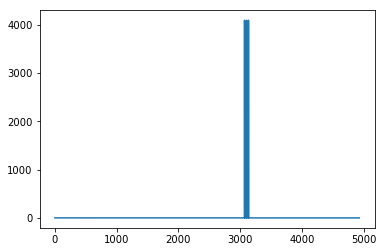

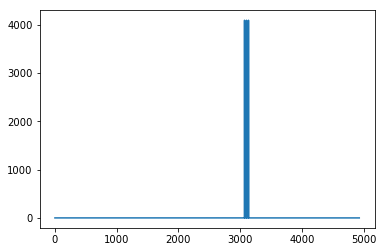

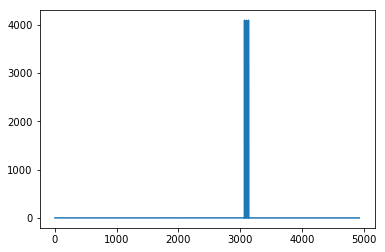

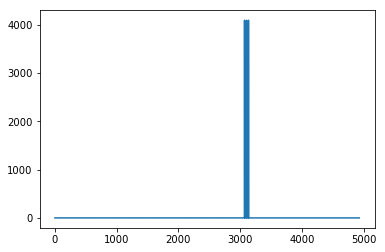

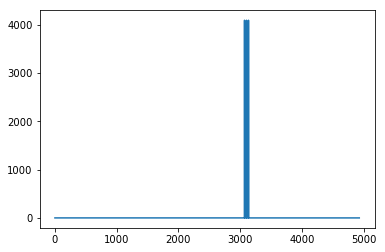

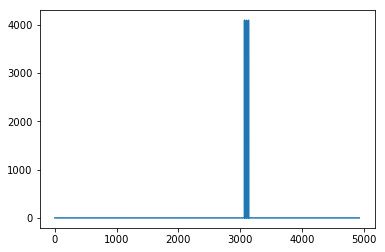

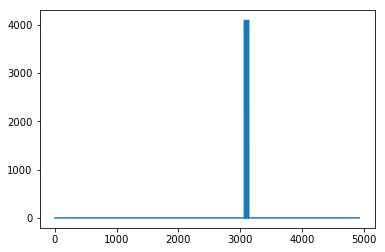

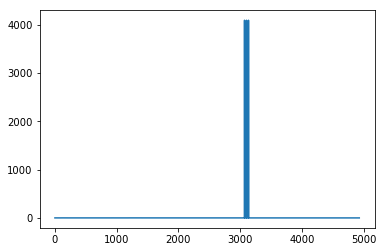

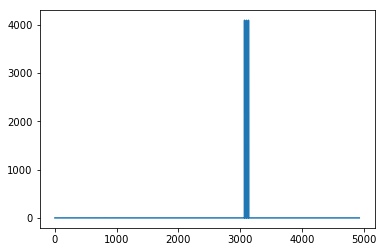

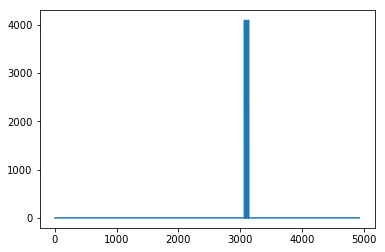

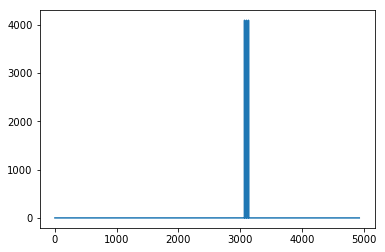

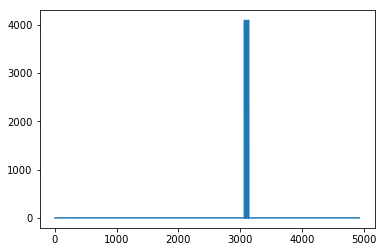

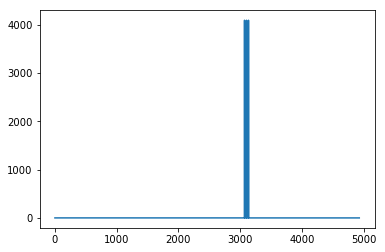

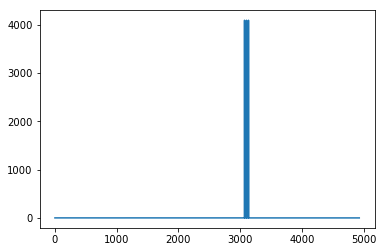

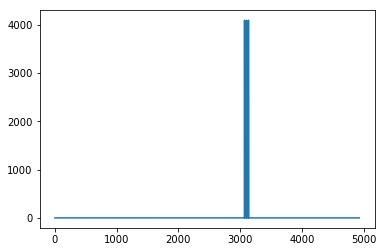

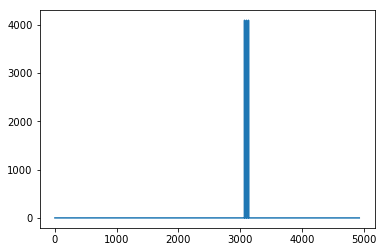

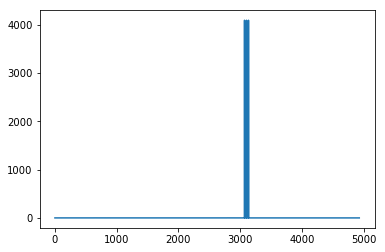

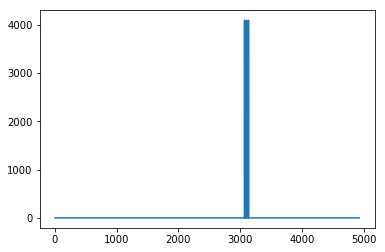

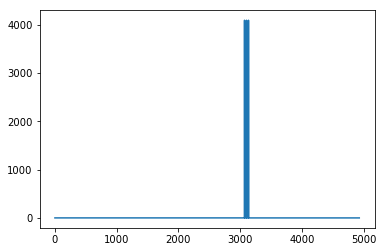

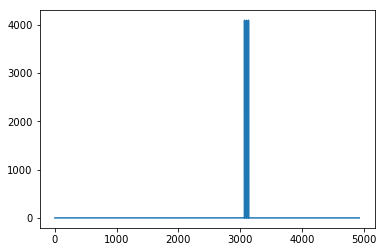

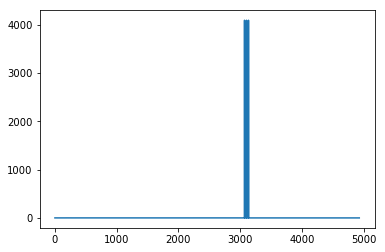

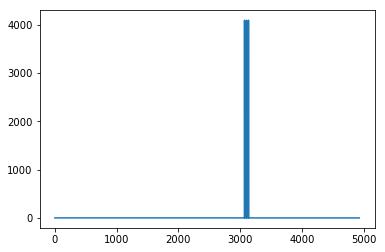

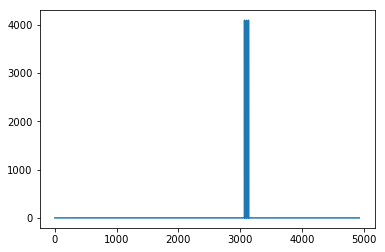

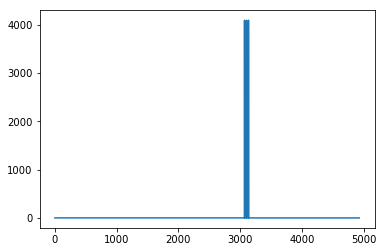

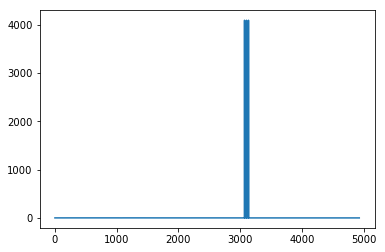

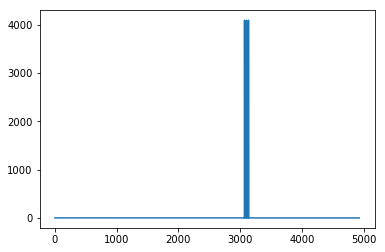

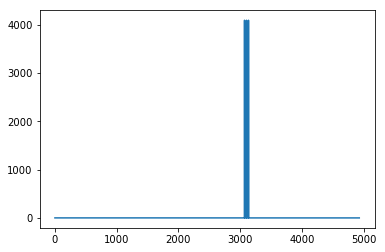

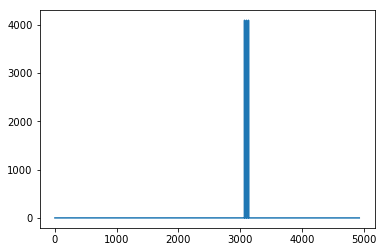

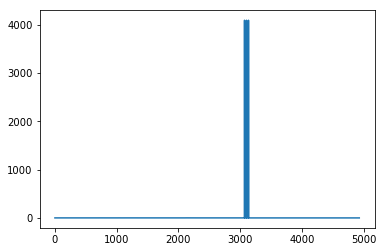

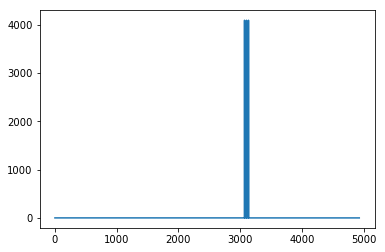

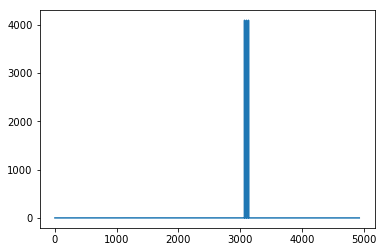

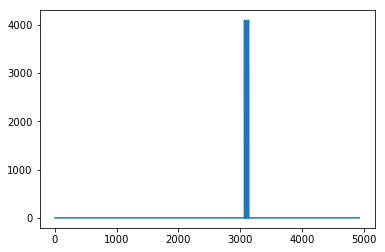

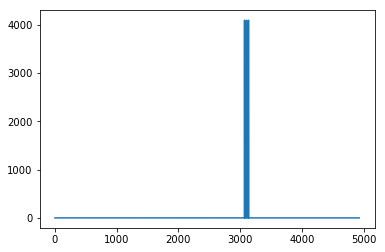

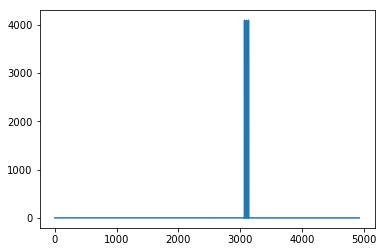

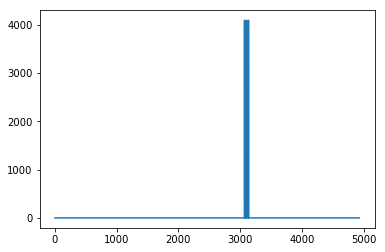

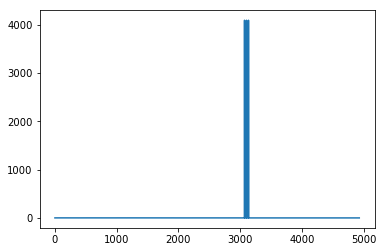

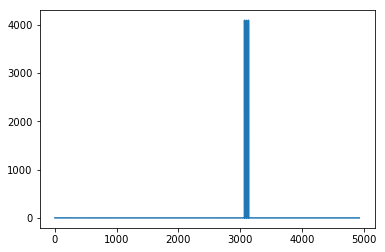

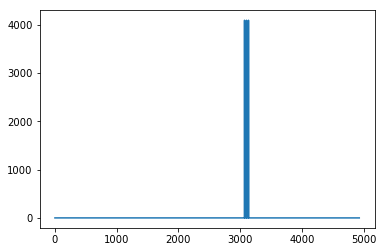

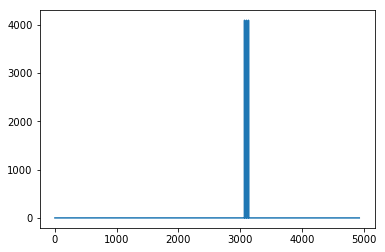

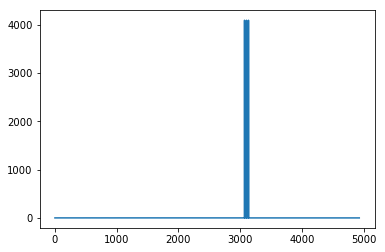

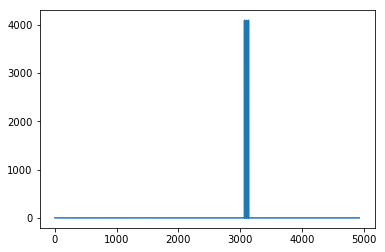

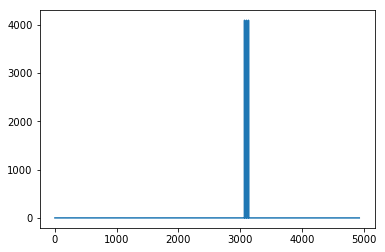

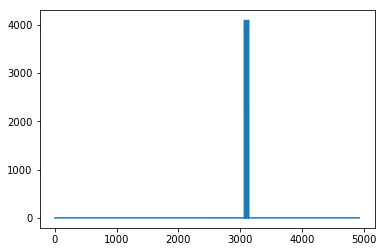

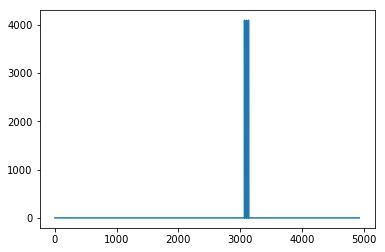

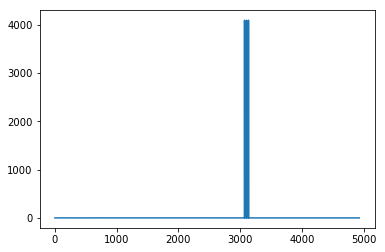

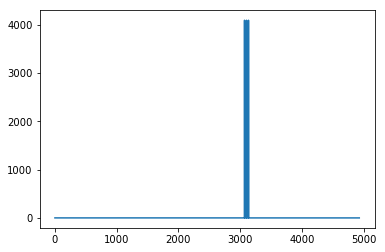

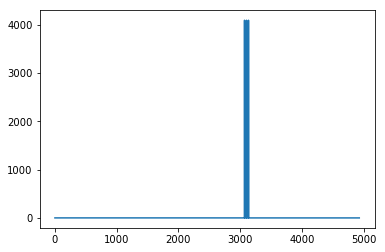

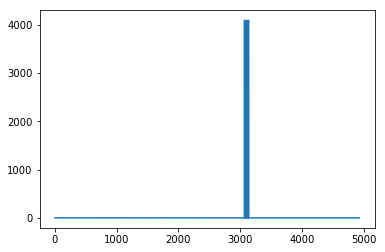

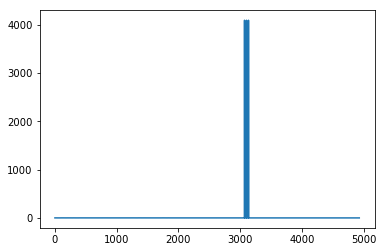

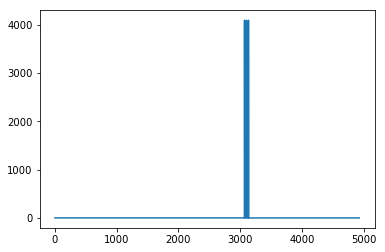

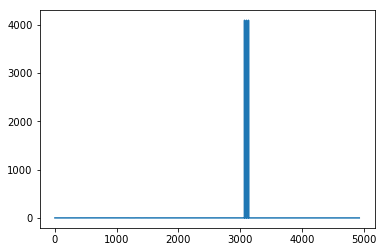

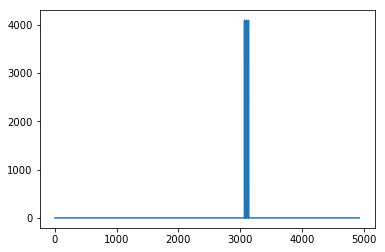

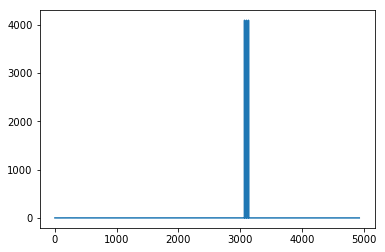

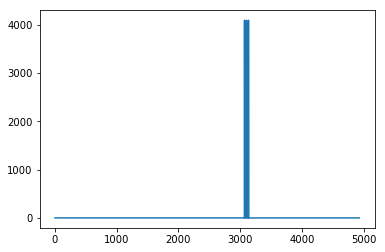

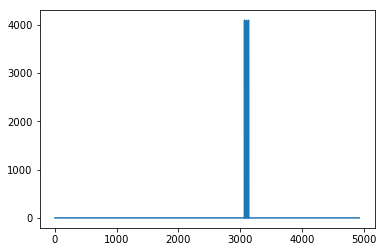

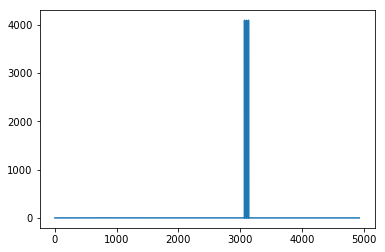

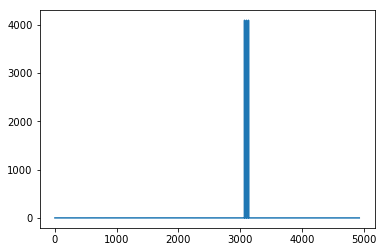

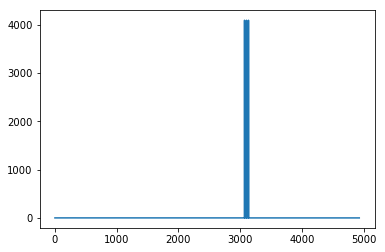

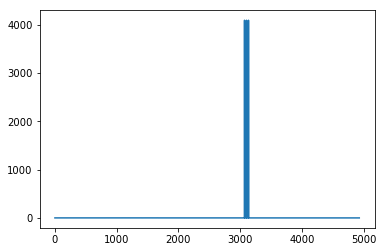

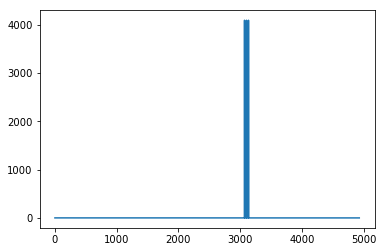

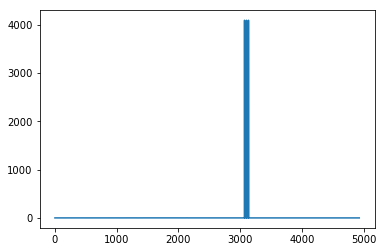

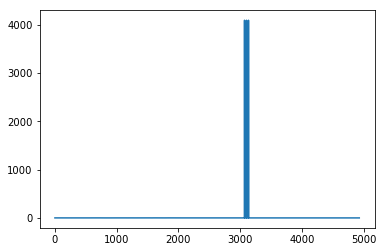

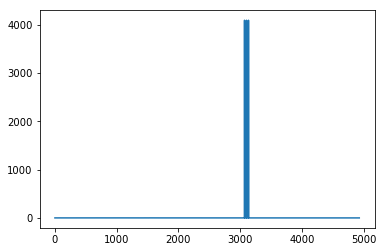

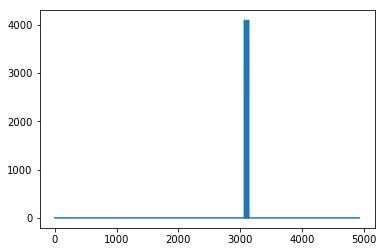

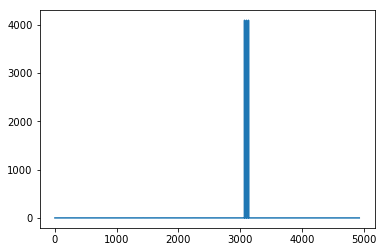

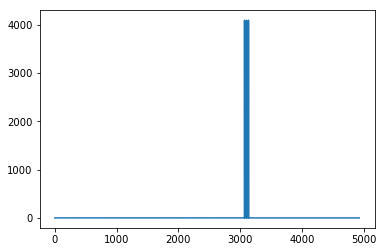

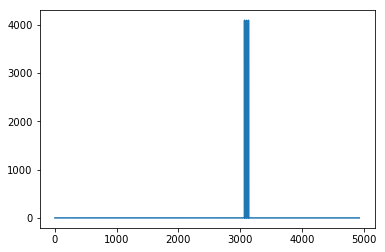

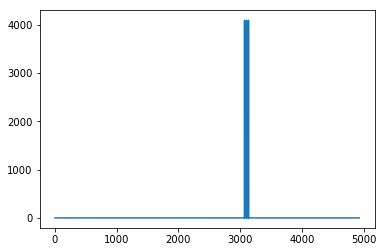

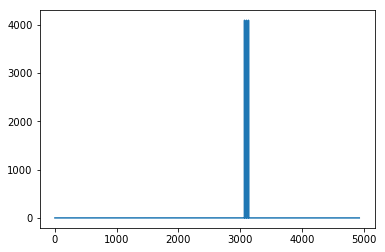

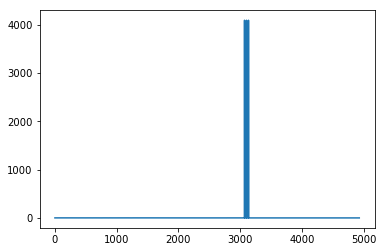

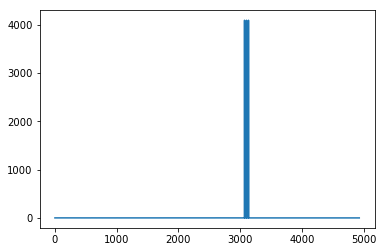

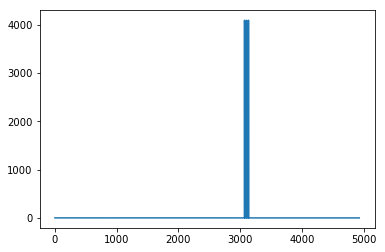

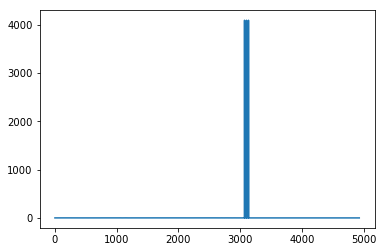

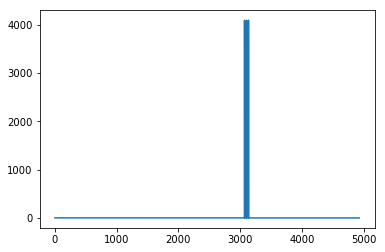

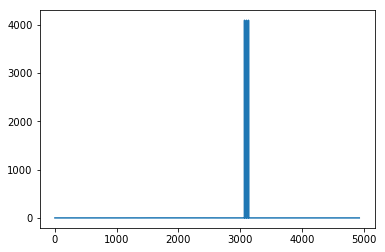

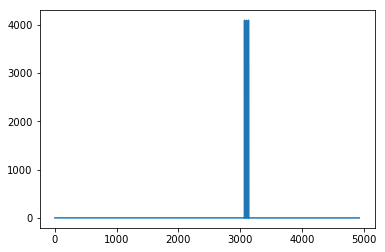

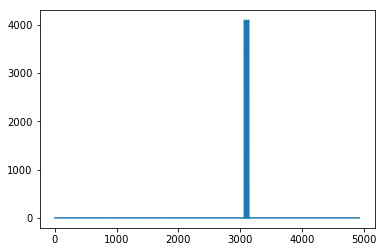

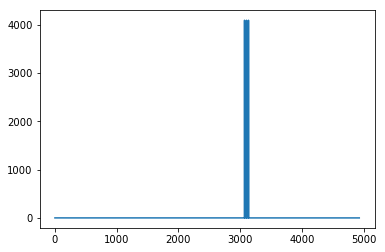

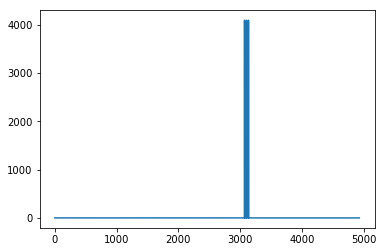

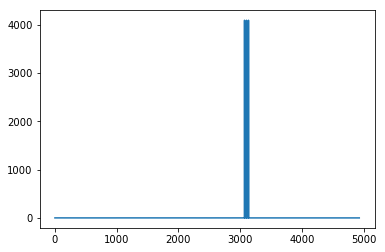

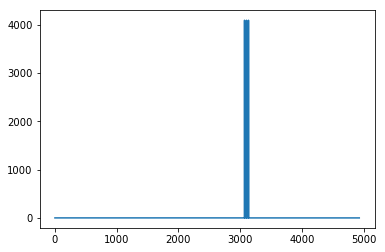

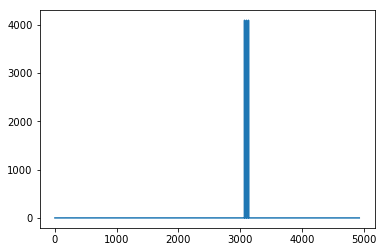

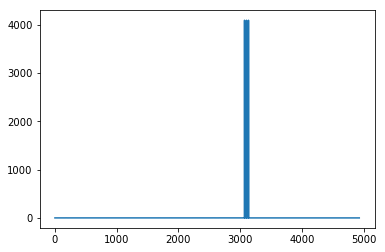

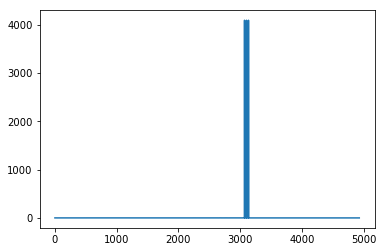

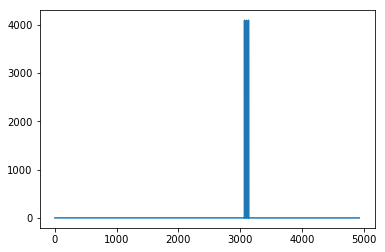

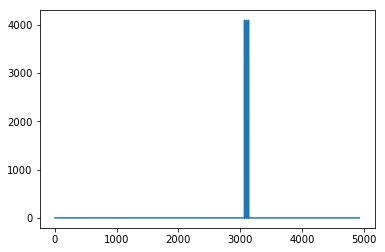

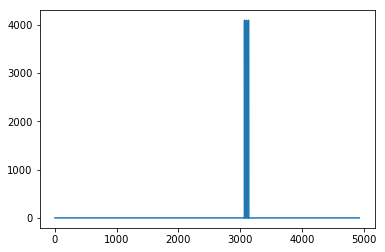

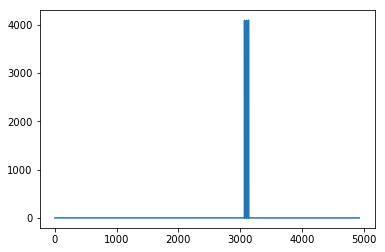

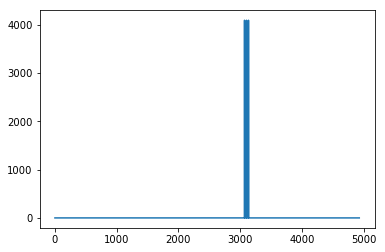

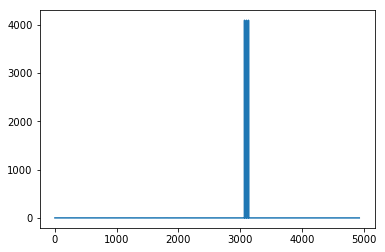

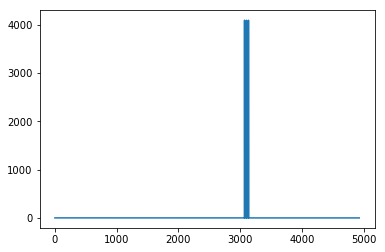

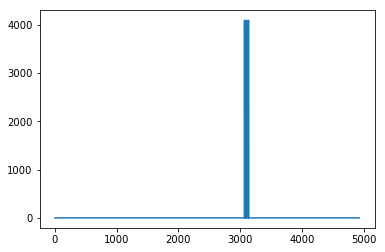

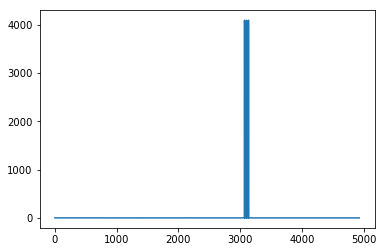

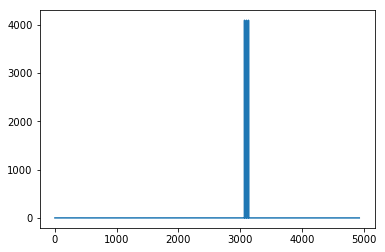

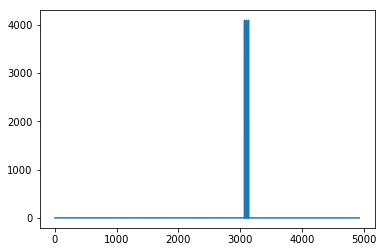

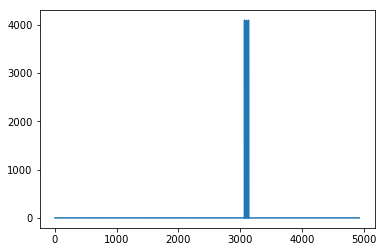

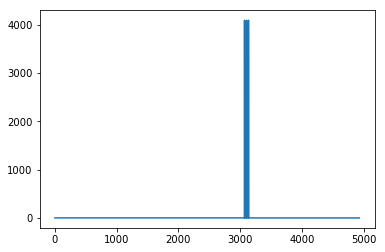

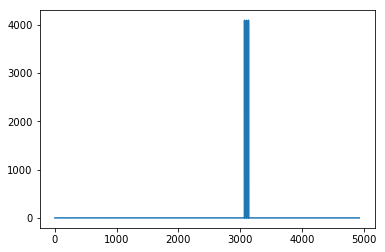

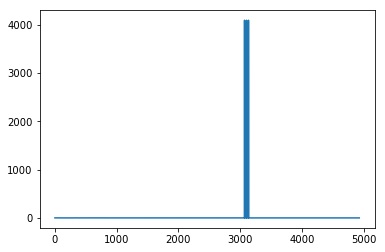

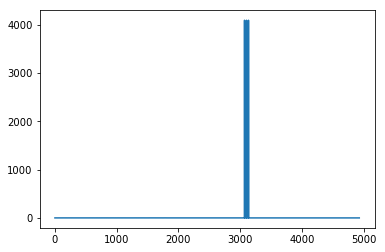

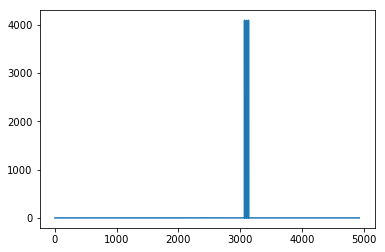

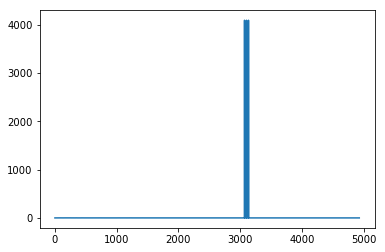

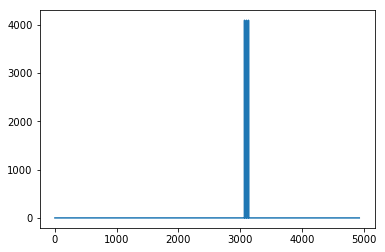

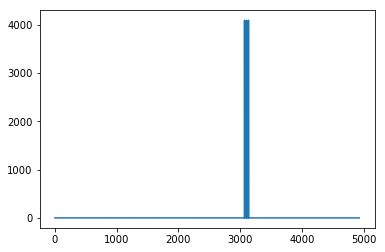

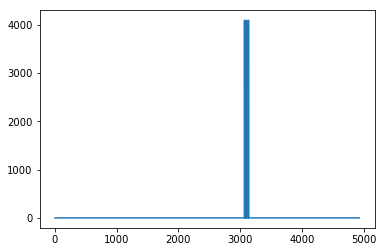

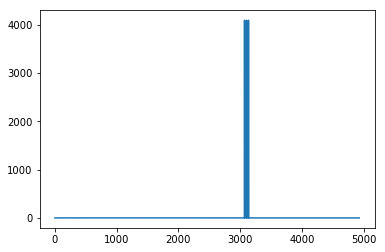

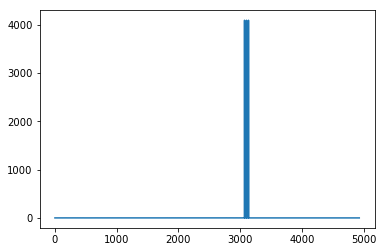

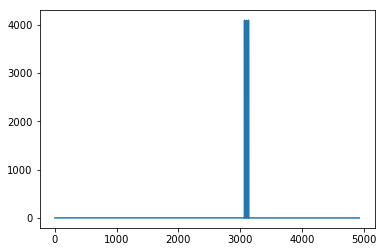

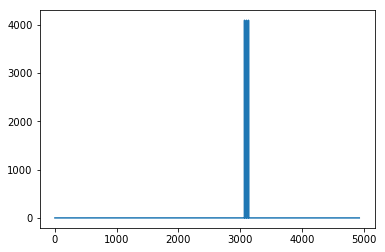

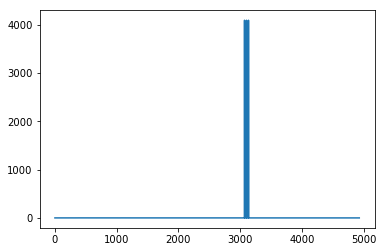

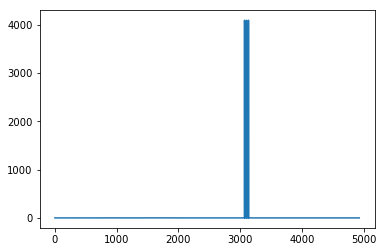

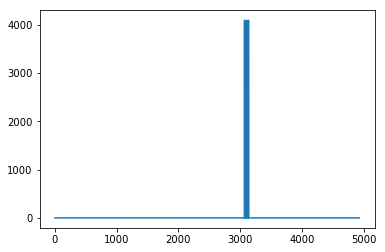

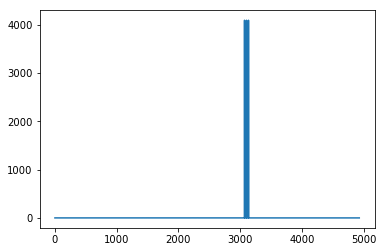

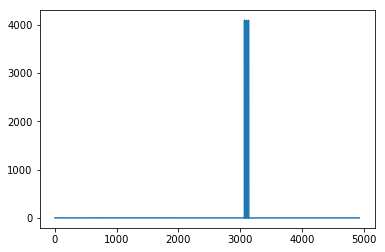

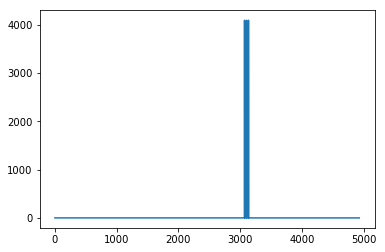

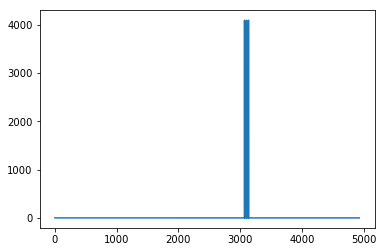

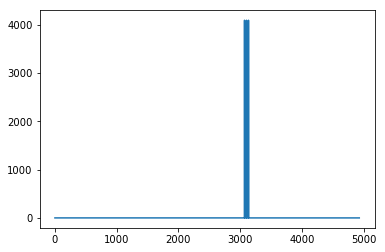

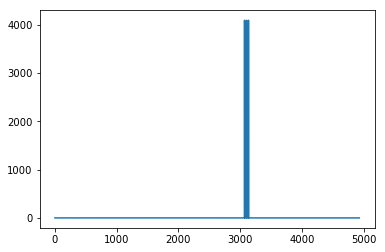

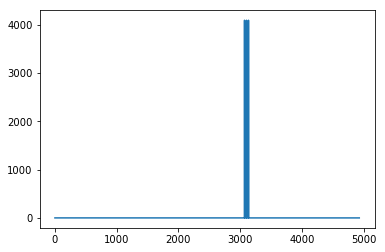

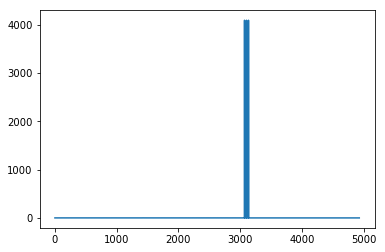

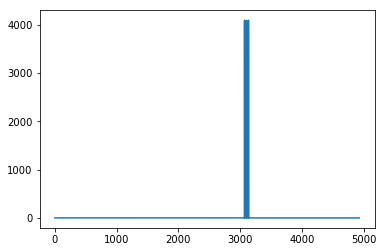

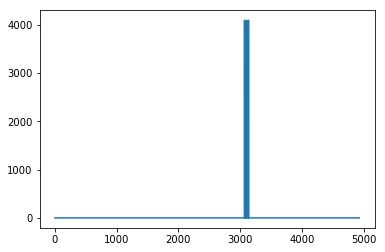

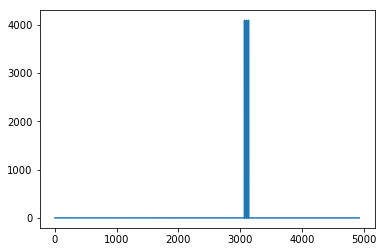

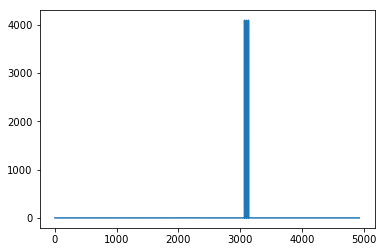

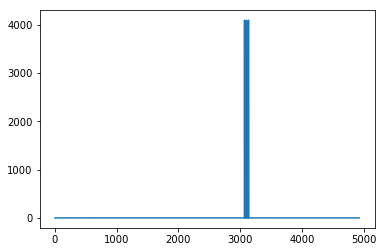

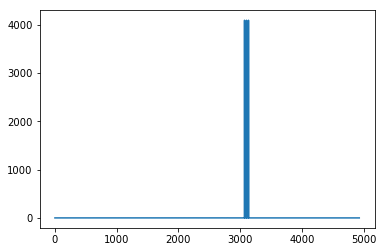

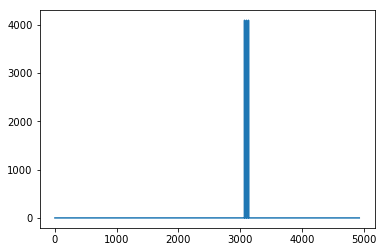

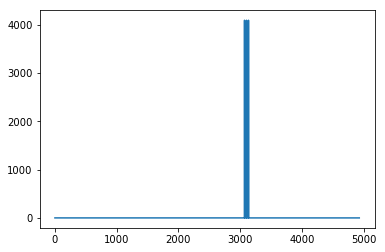

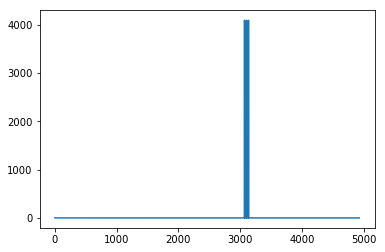

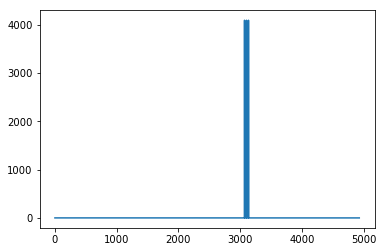

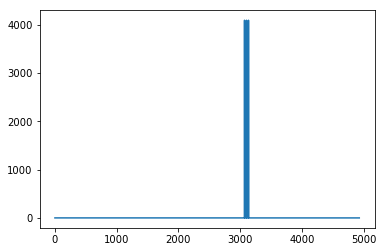

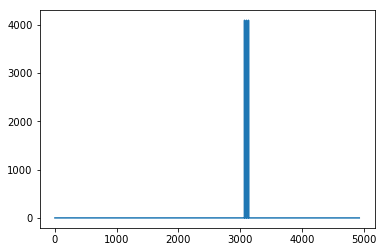

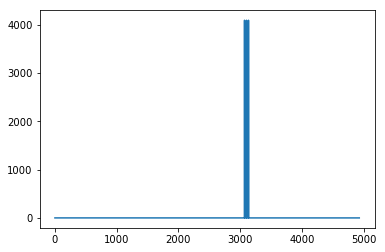

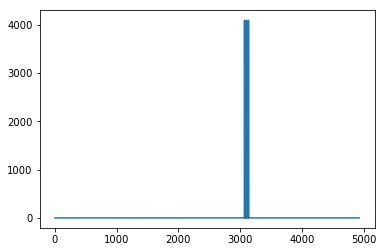

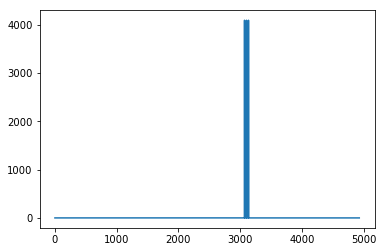

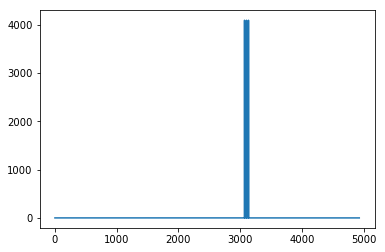

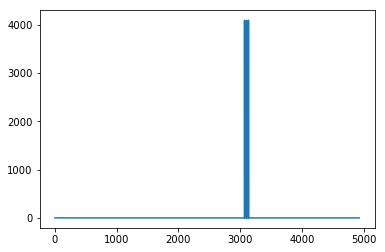

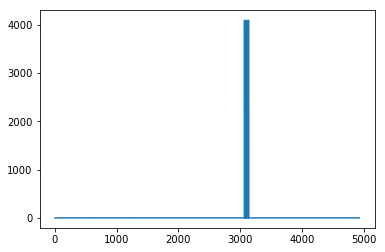

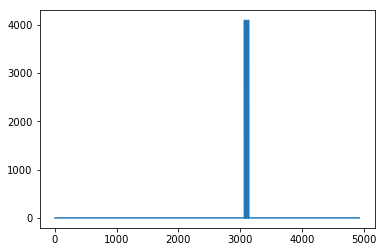

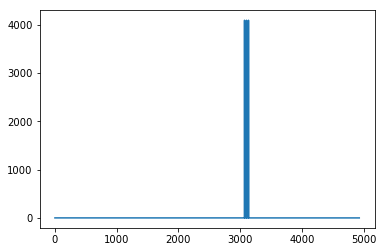

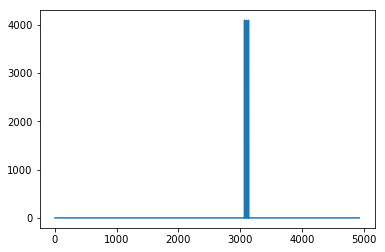

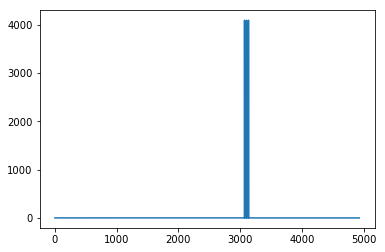

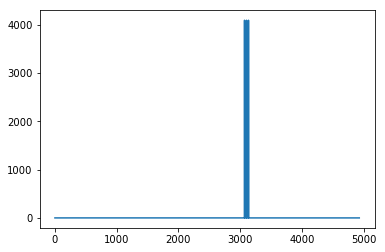

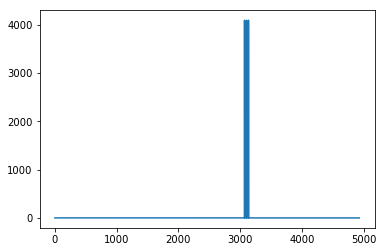

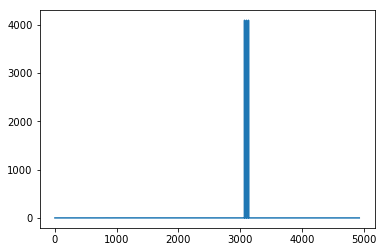

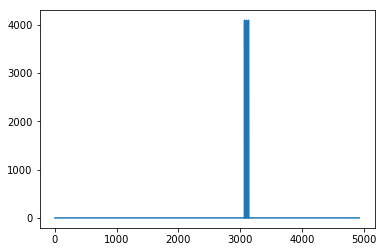

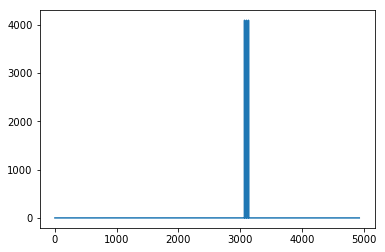

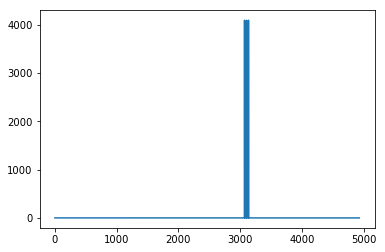

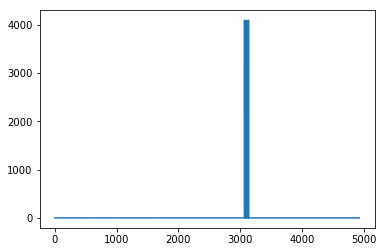

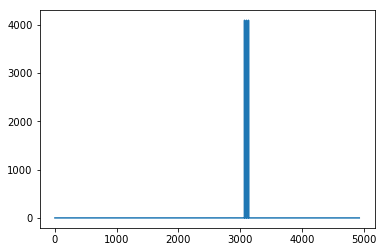

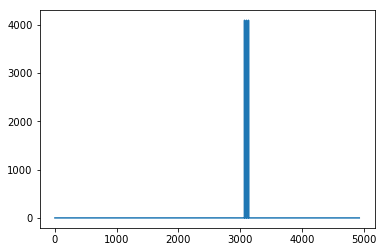

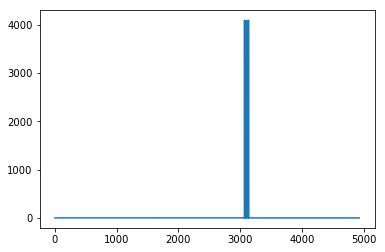

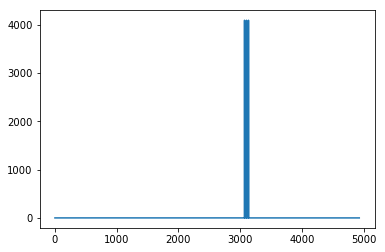

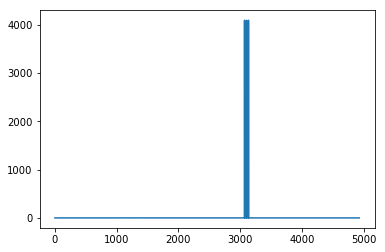

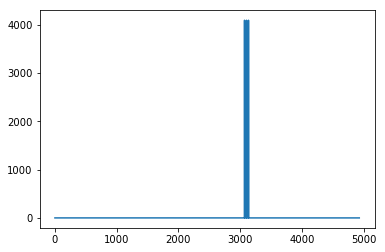

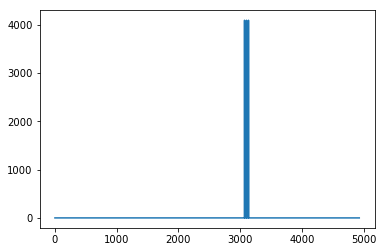

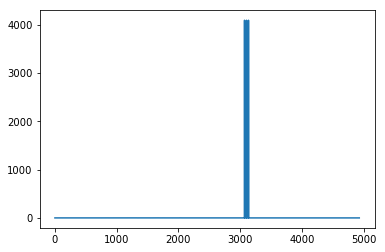

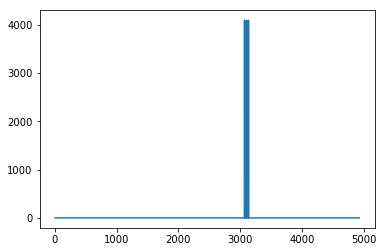

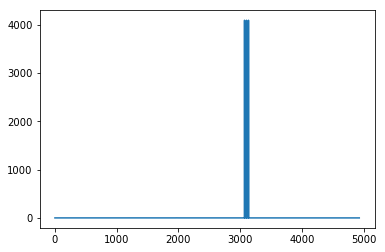

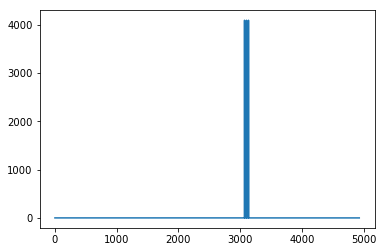

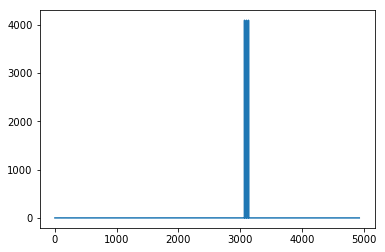

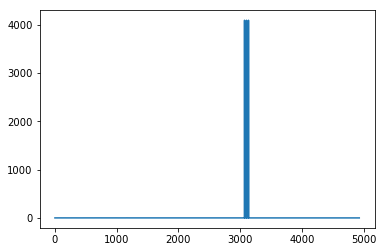

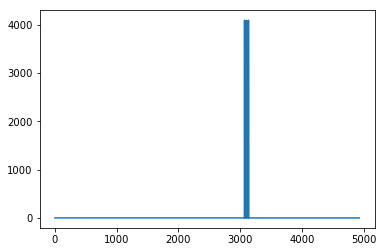

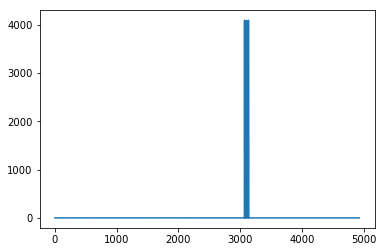

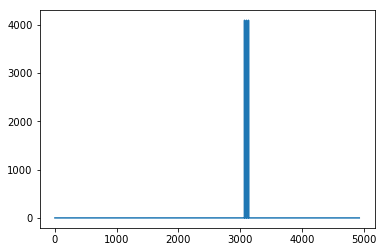

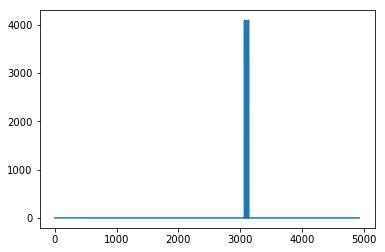

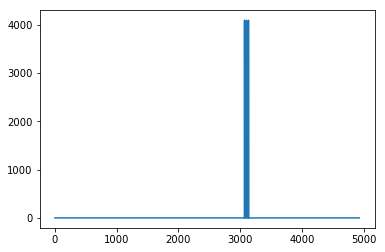

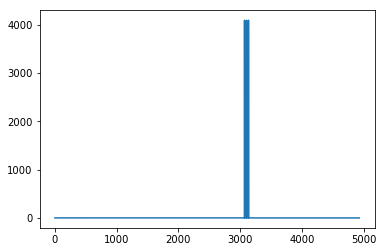

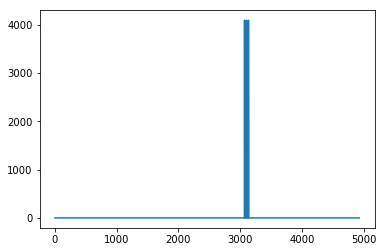

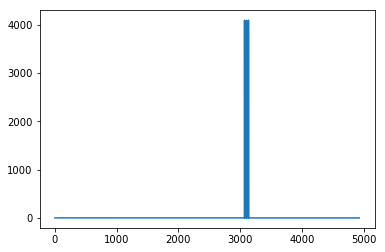

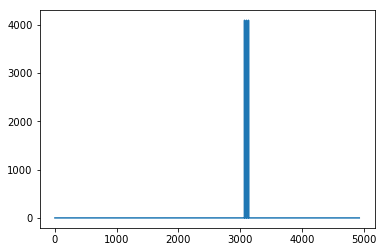

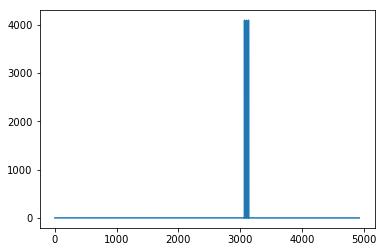

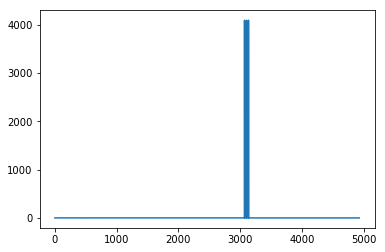

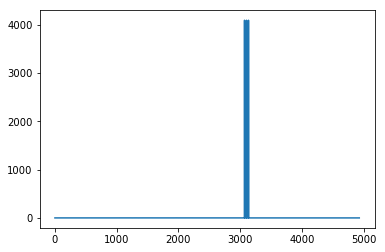

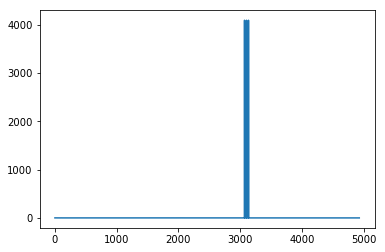

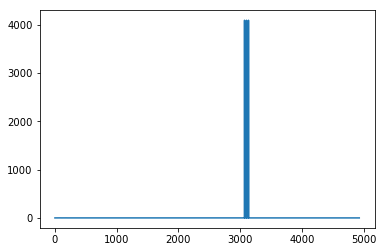

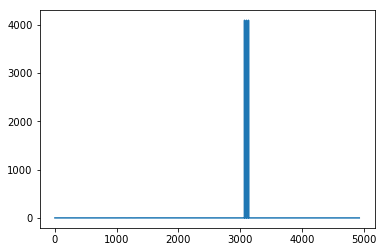

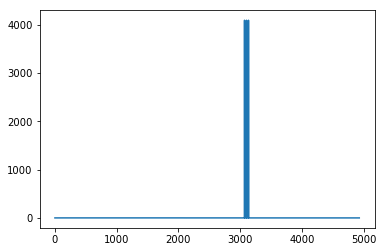

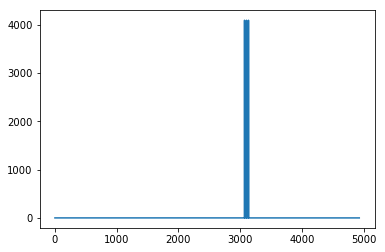

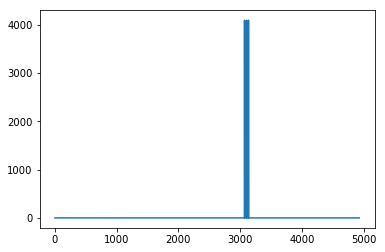

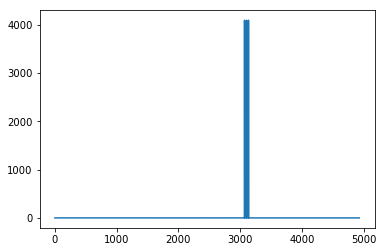

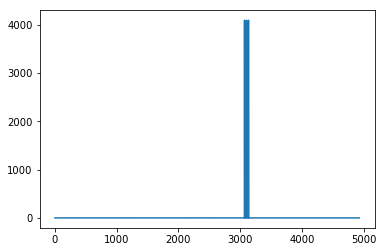

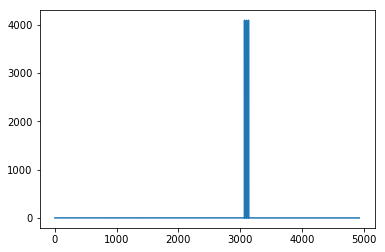

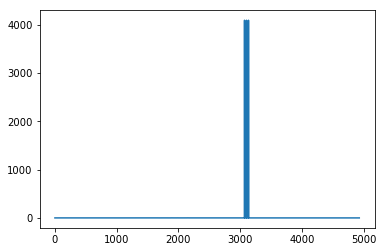

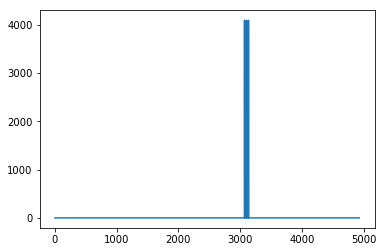

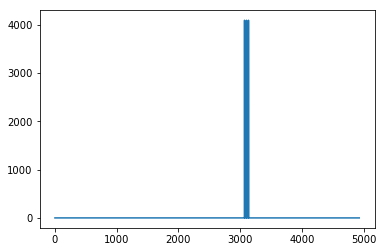

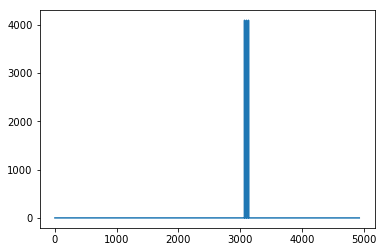

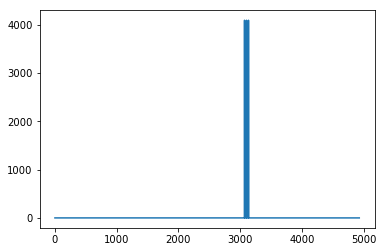

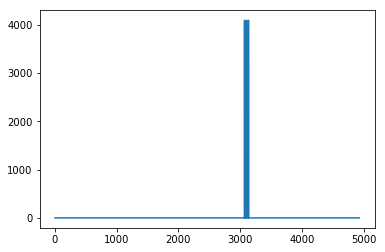

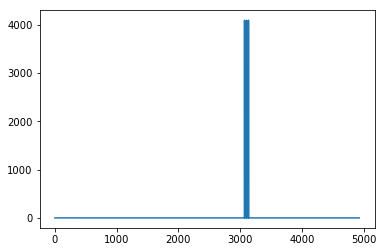

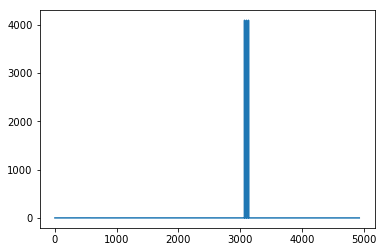

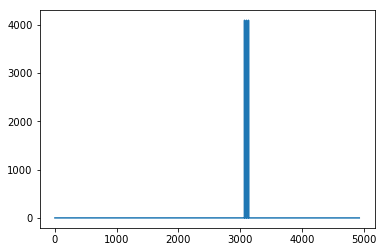

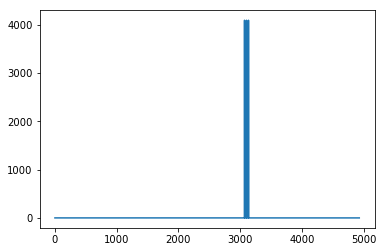

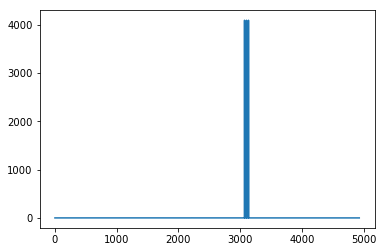

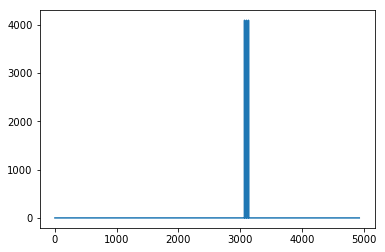

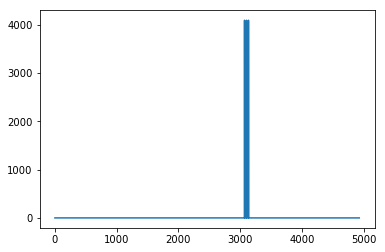

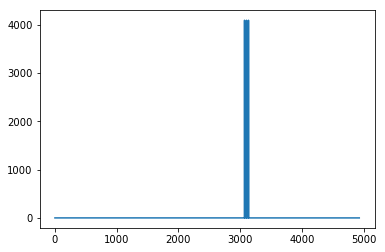

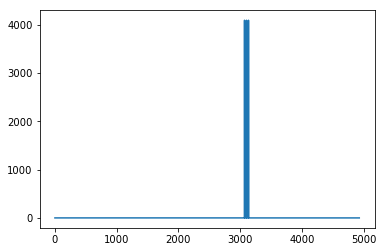

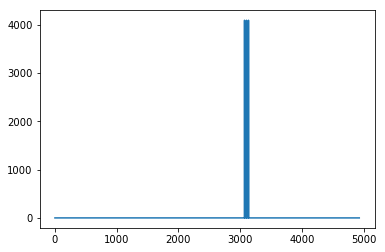

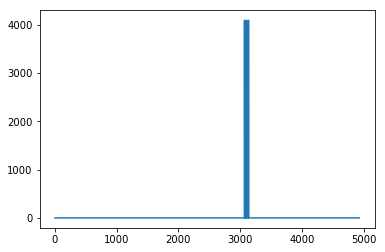

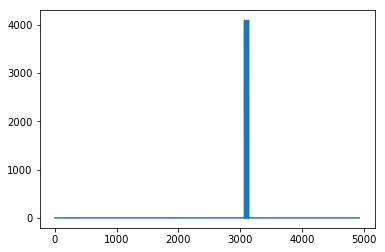

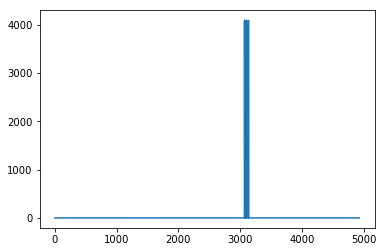

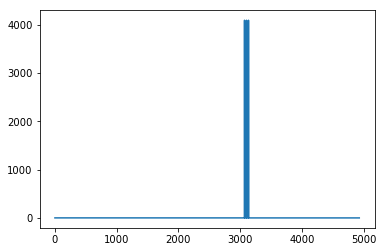

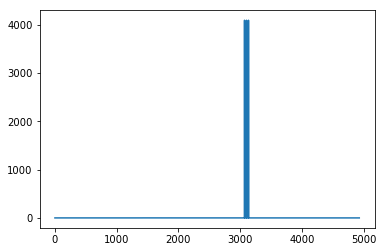

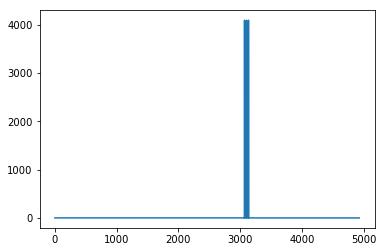

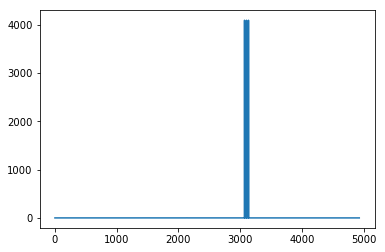

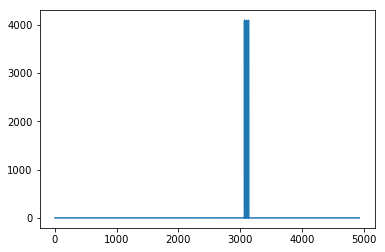

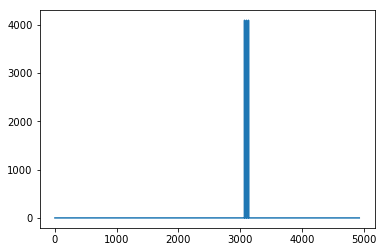

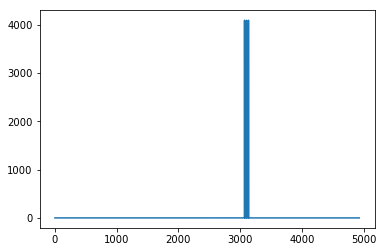

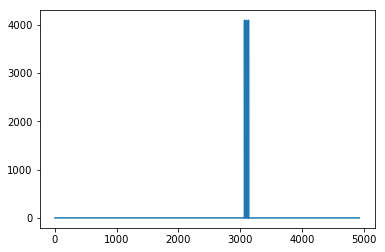

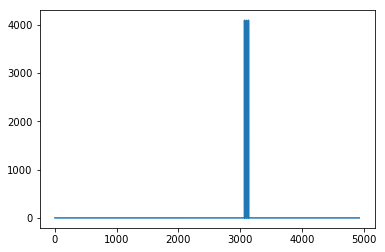

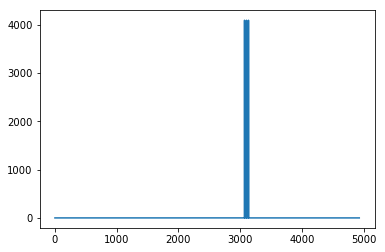

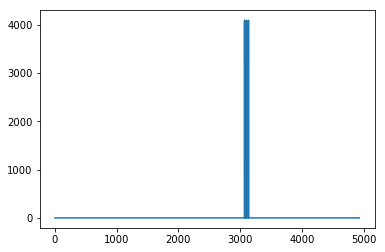

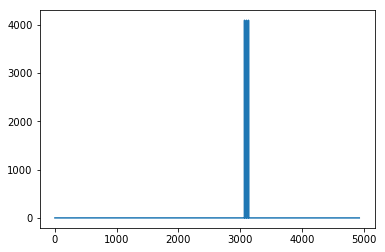

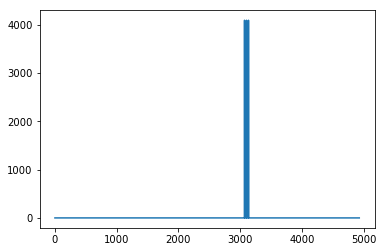

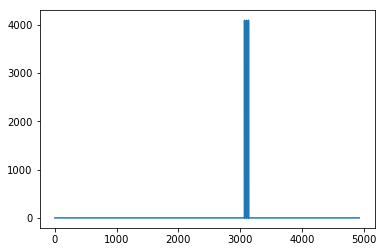

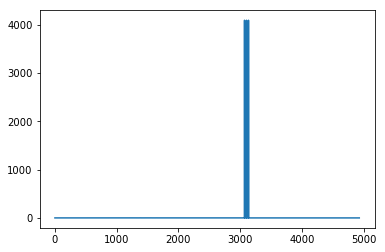

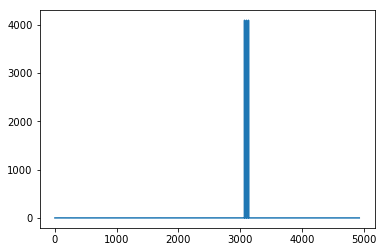

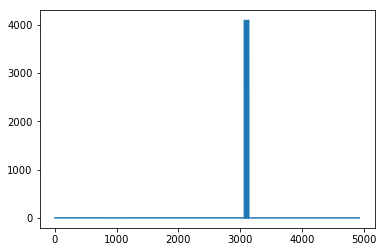

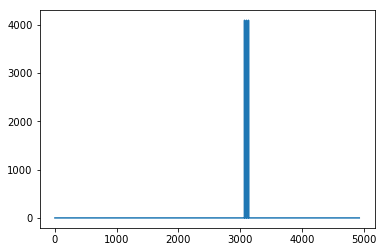

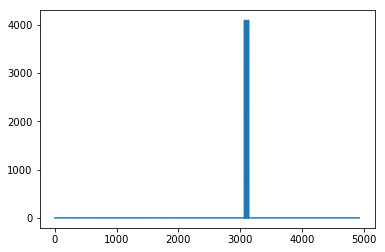

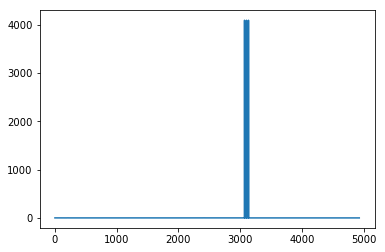

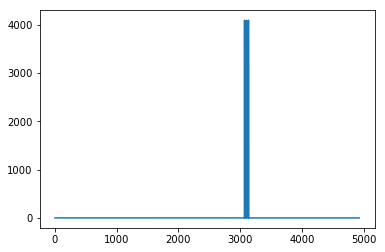

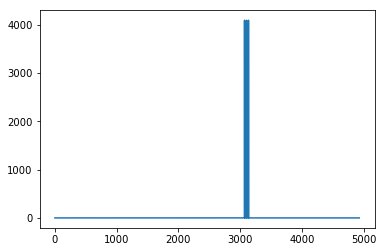

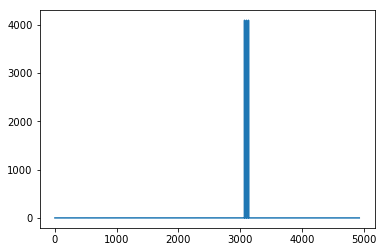

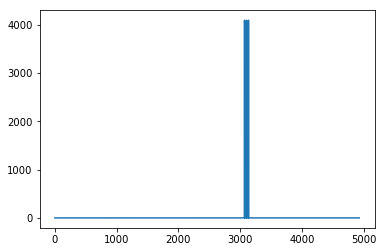

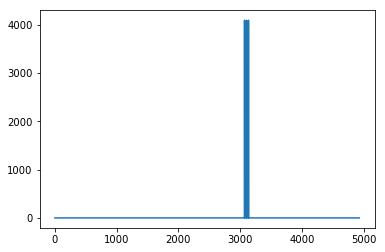

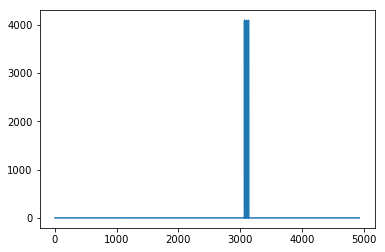

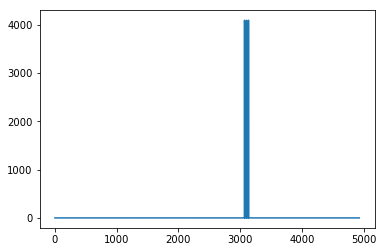

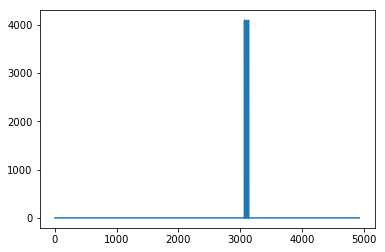

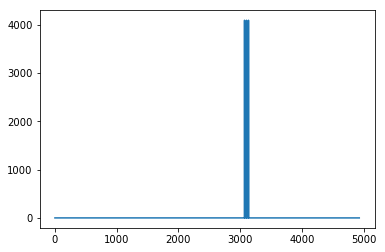

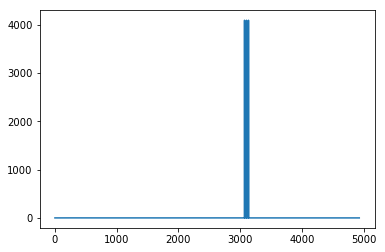

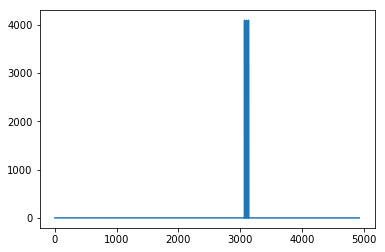

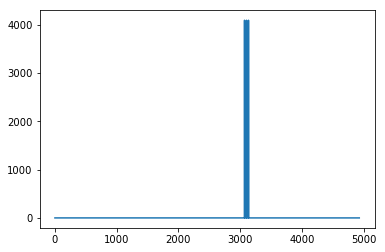

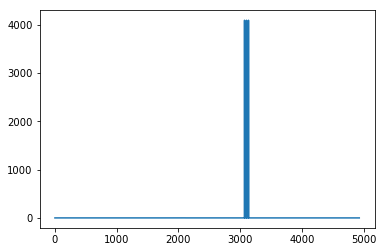

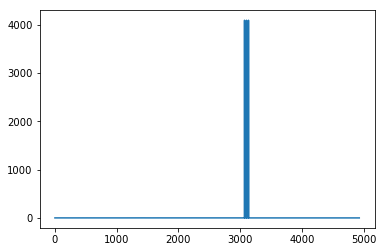

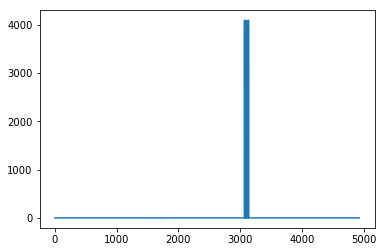

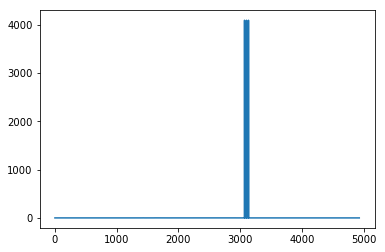

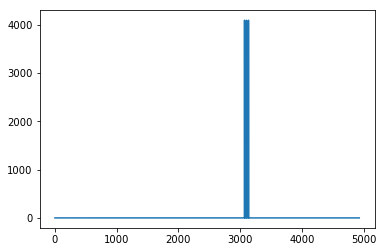

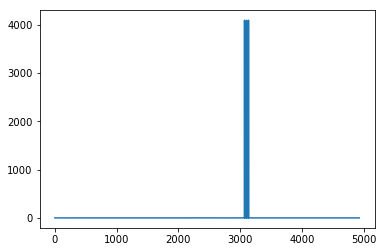

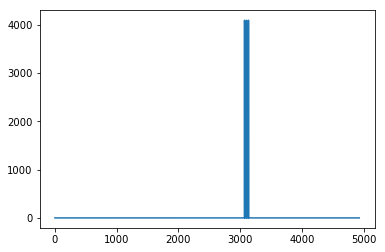

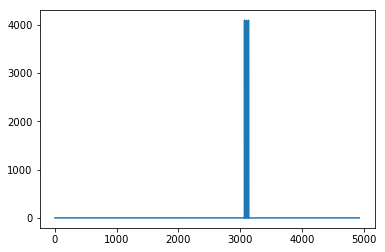

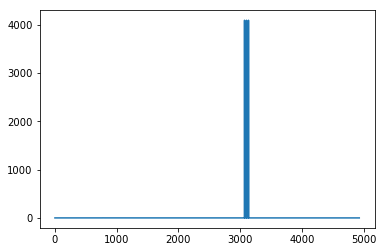

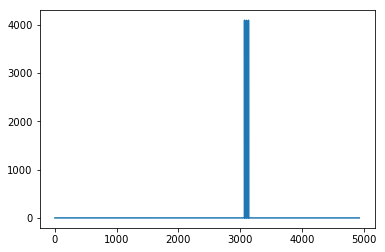

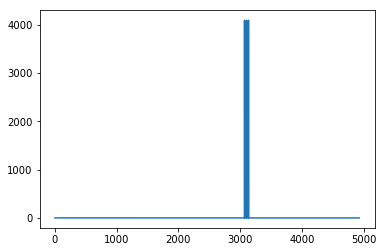

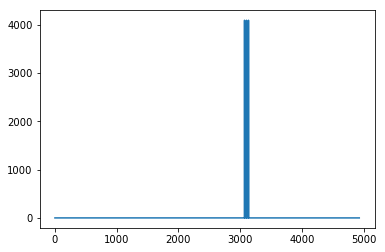

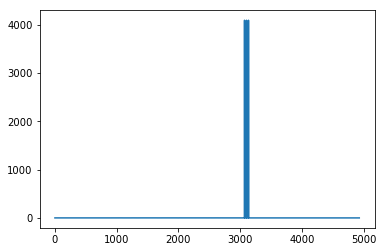

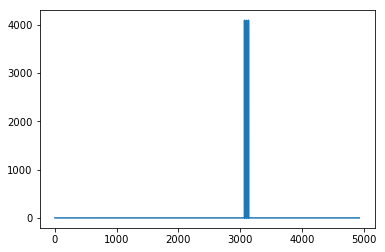

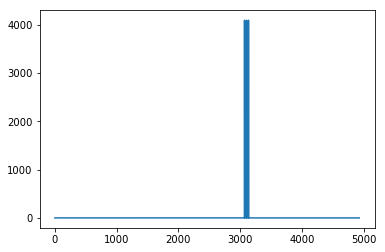

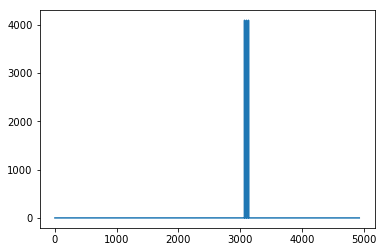

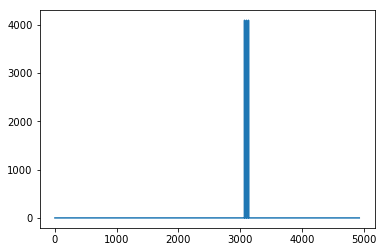

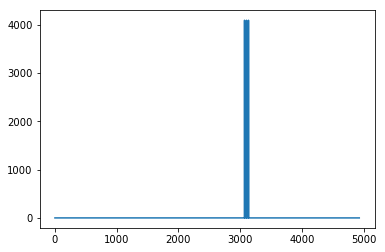

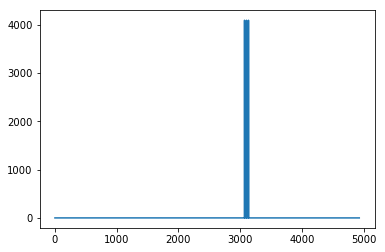

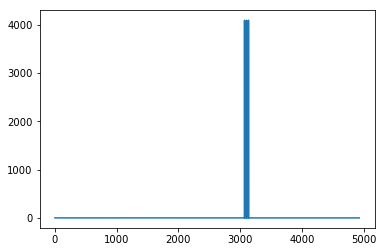

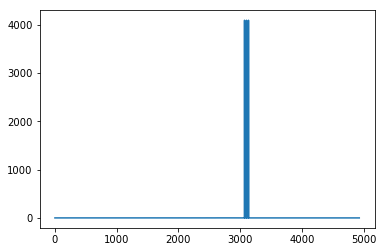

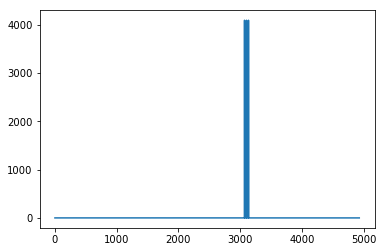

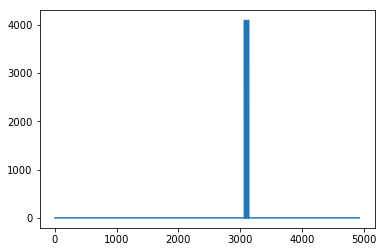

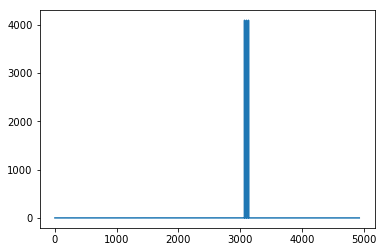

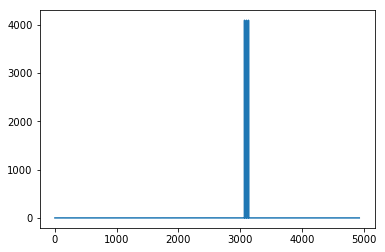

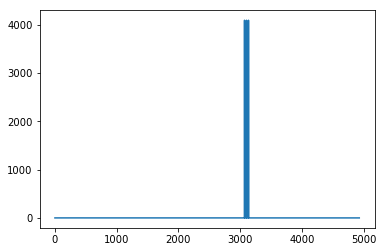

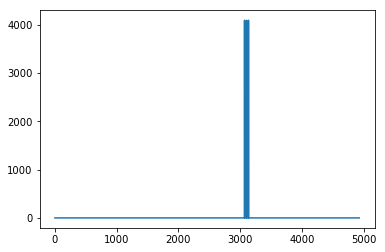

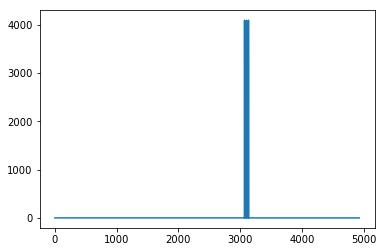

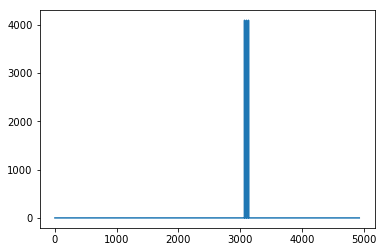

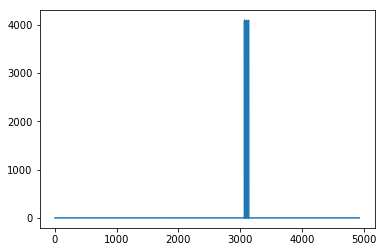

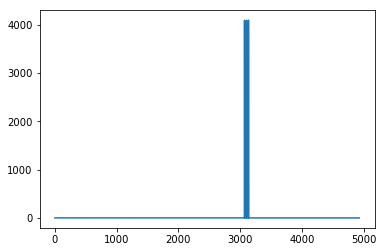

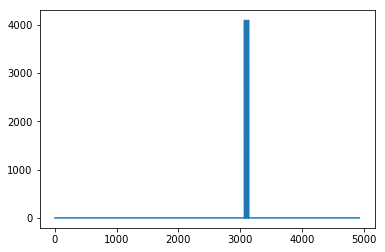

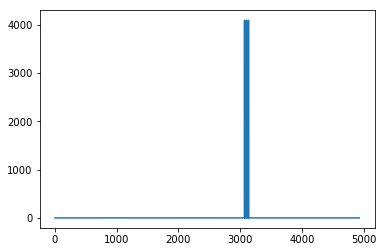

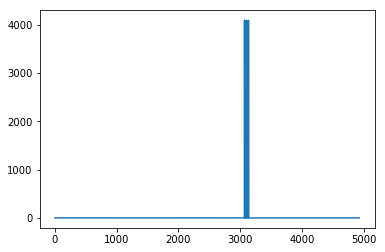

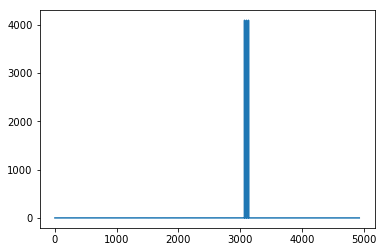

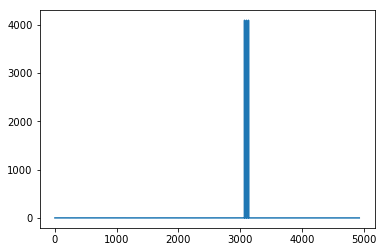

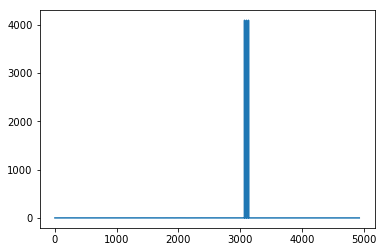

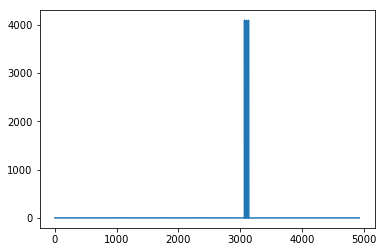

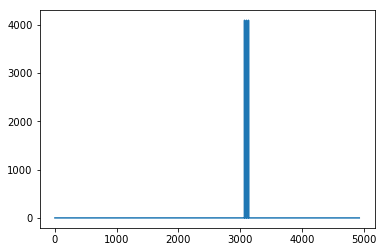

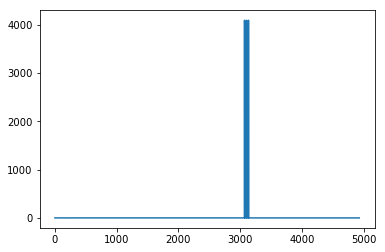

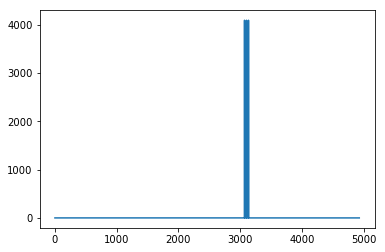

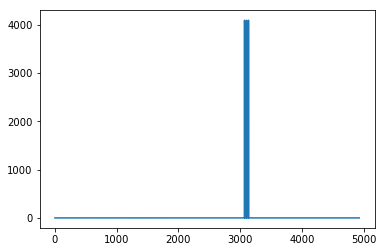

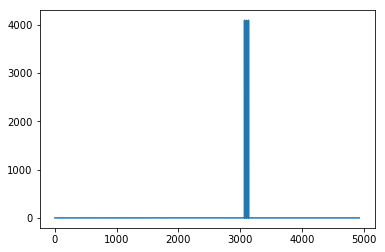

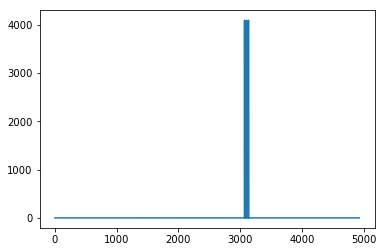

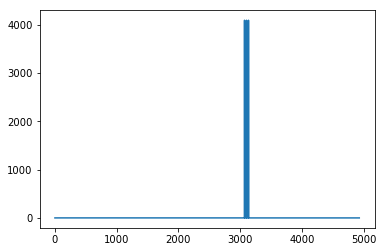

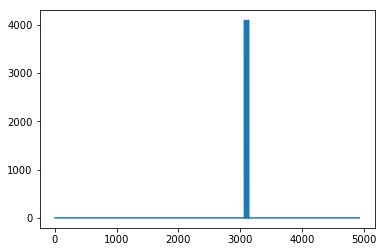

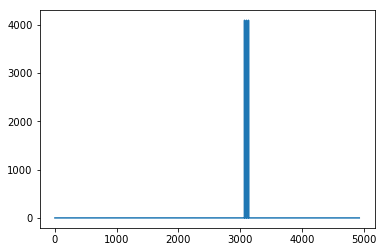

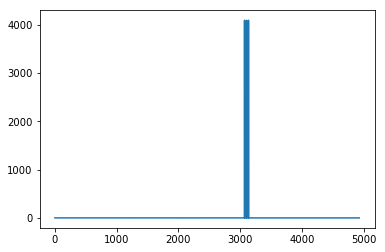

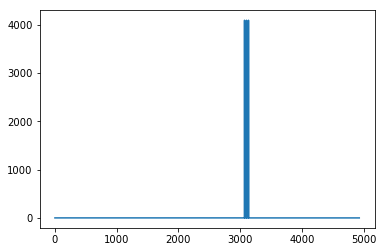

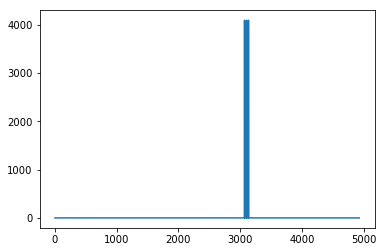

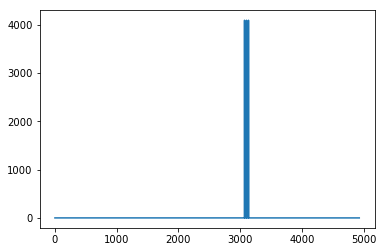

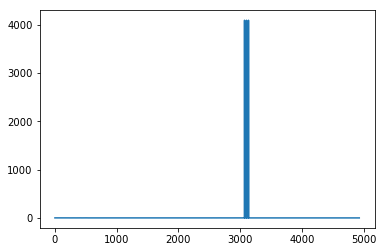

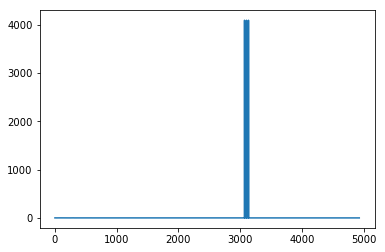

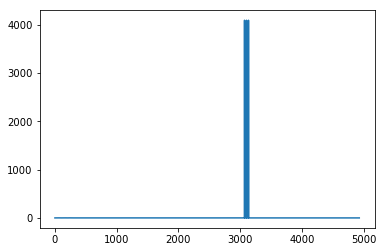

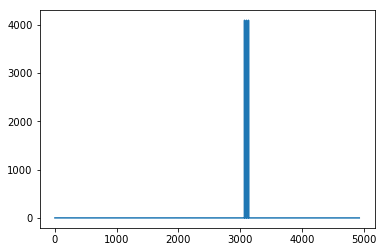

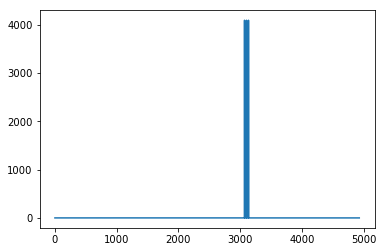

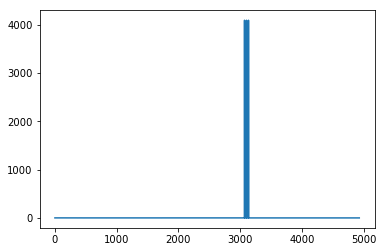

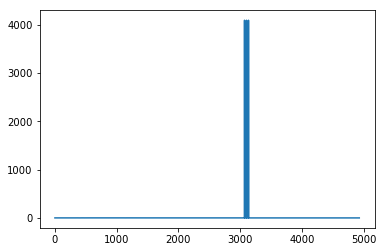

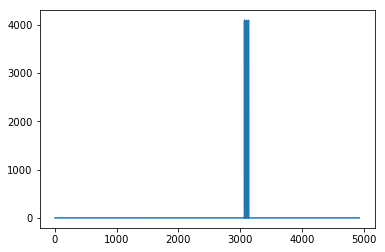

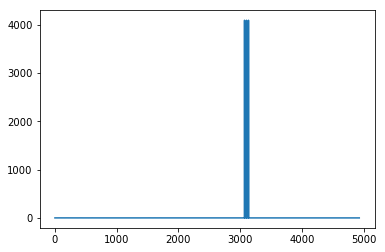

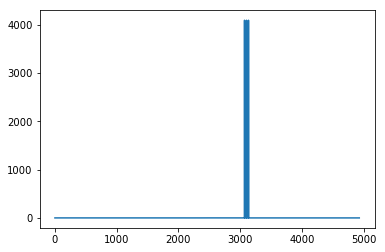

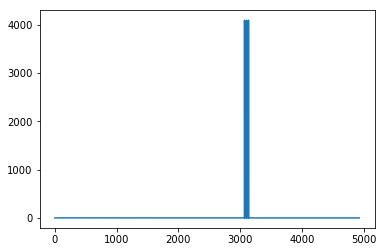

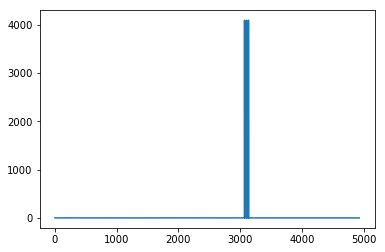

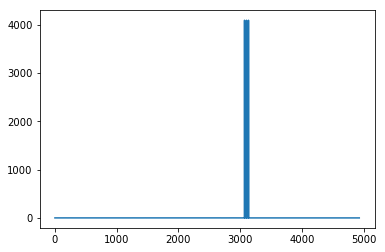

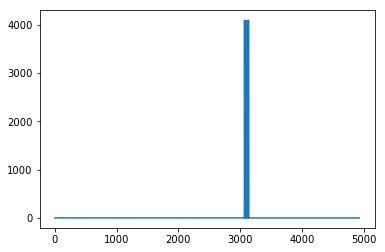

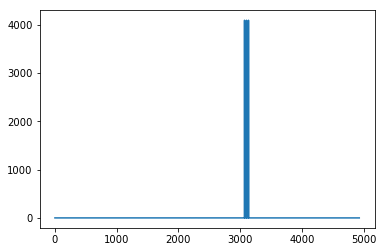

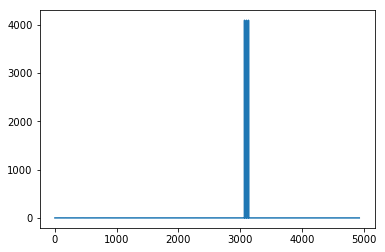

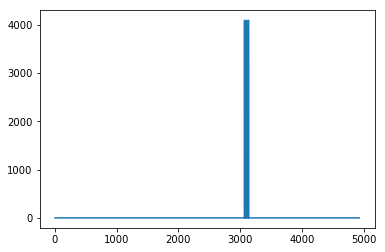

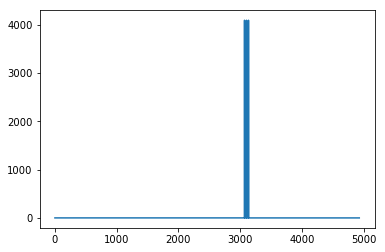

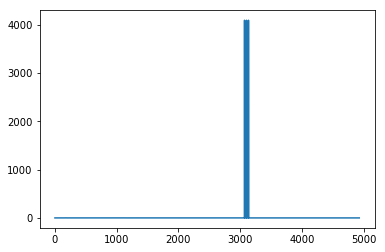

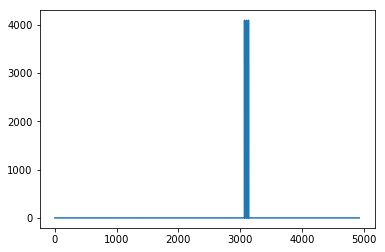

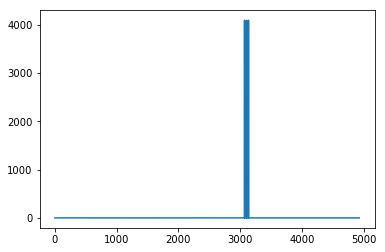

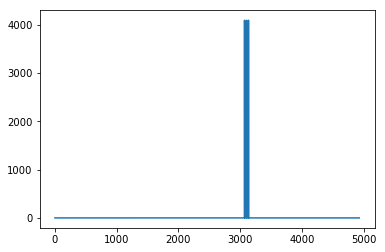

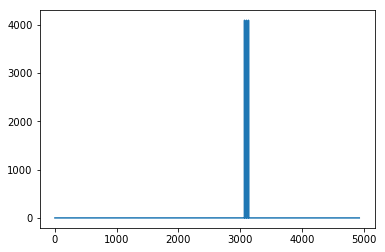

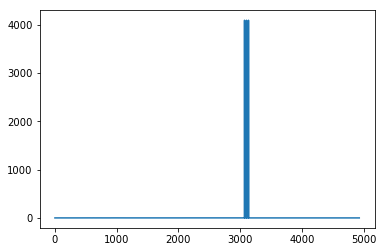

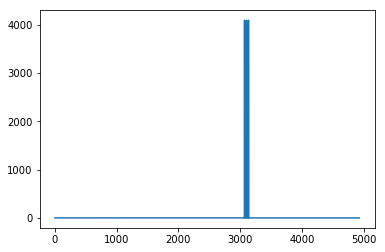

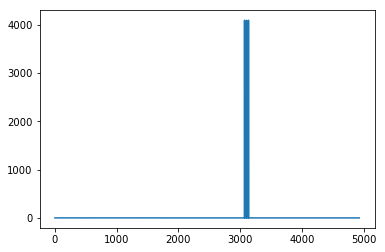

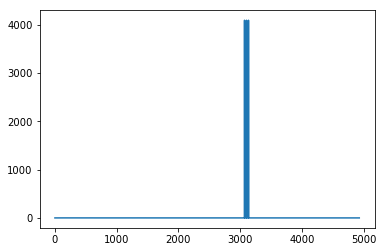

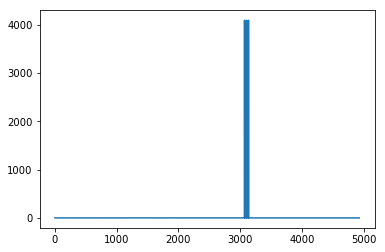

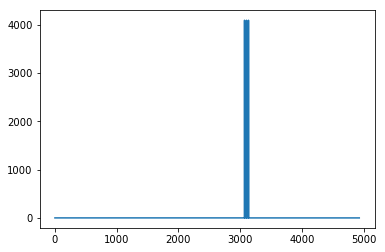

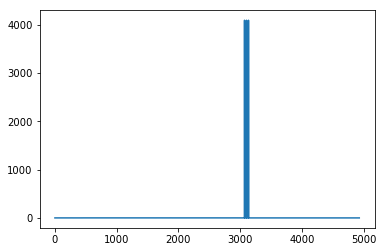

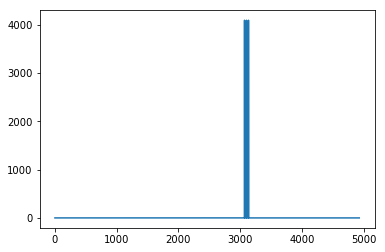

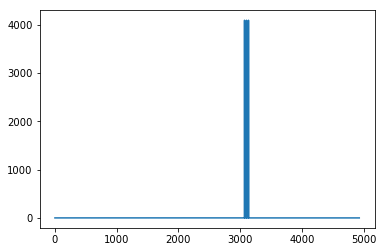

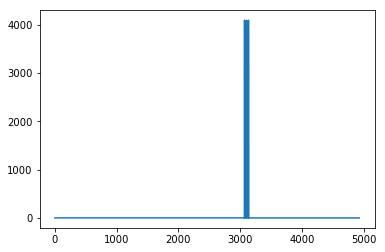

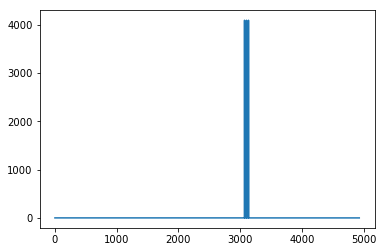

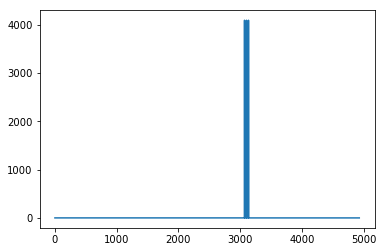

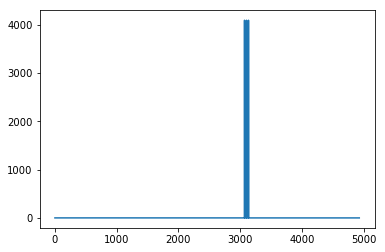

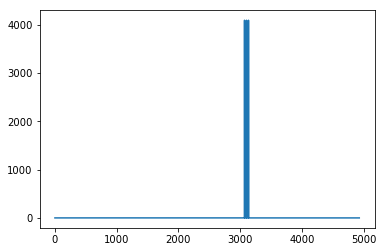

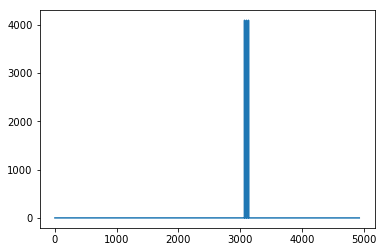

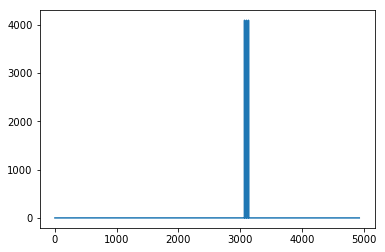

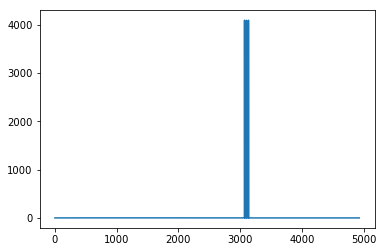

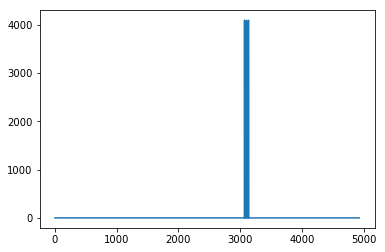

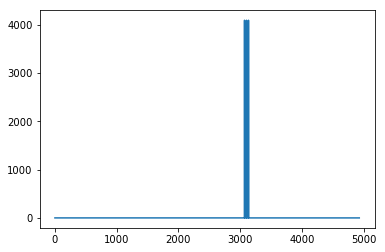

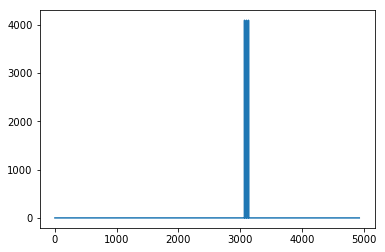

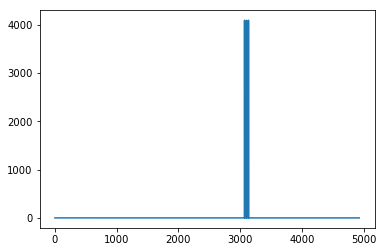

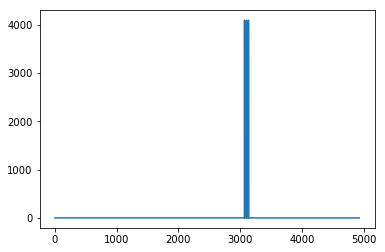

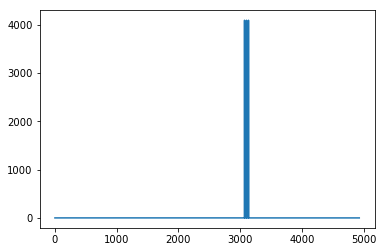

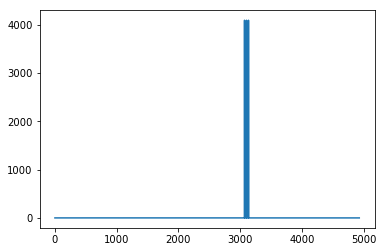

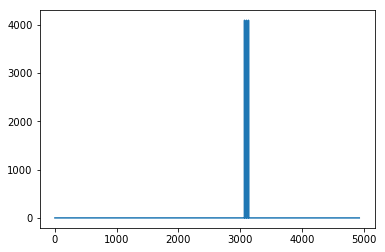

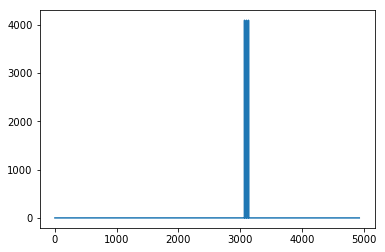

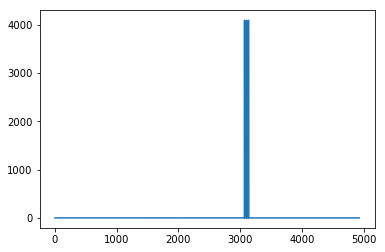

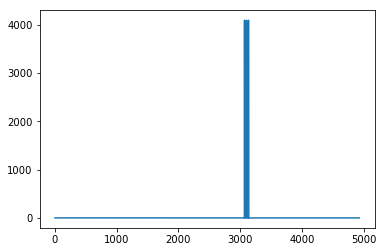

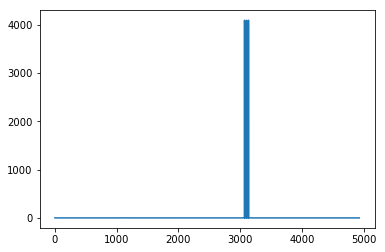

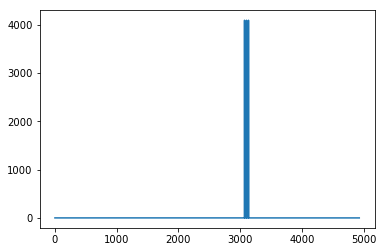

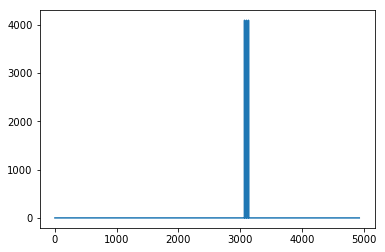

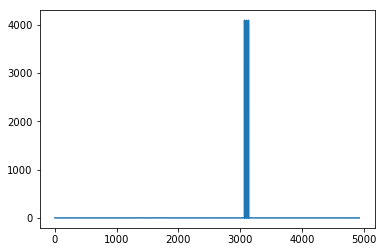

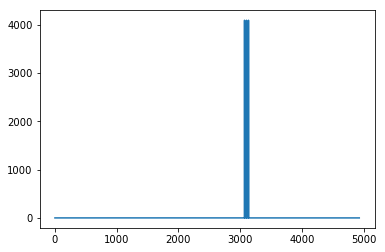

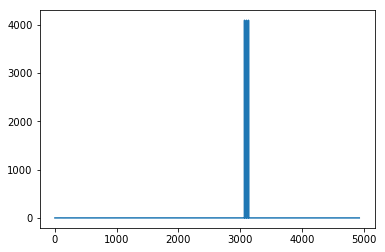

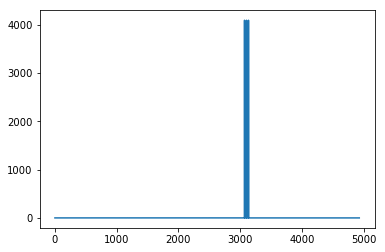

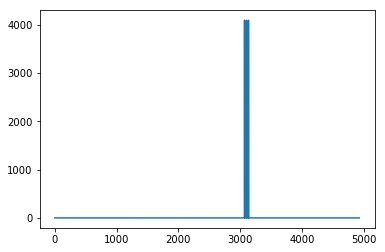

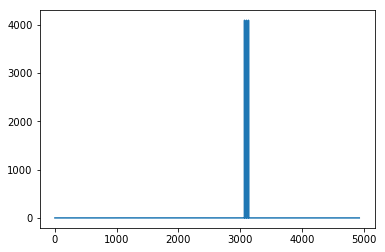

In [117]:
# extracting features for cars and not-car images
t=time.time()
car_features = extract_features_from_image_list(car_imgs, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, feature_type='all')
notcar_features = extract_features_from_image_list(non_car_imgs, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, feature_type='all')
t2 = time.time()

In [118]:
print(round(t2-t, 2), 'Seconds to extract HOG features...')

98.83 Seconds to extract HOG features...


In [119]:
# Stacking all the feature vectors for cars and non-car images.
# And then normalizing them all so that one feature doesnt become dominant in classification
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scalar = StandardScaler().fit(X)
scaled_X = X_scalar.transform(X)


# creating the labels vectors for cars and non-cars images
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [120]:
# spliting the sample data into training and testing set
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

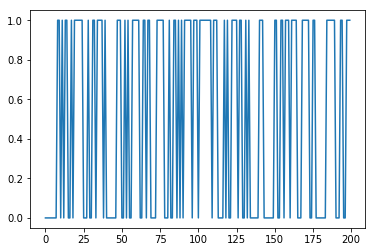

In [123]:
plt.plot(y_test)
plt.show()

In [121]:
# creating a linear SVM classifier to test the pipeline
svc = LinearSVC()
t1 = time.time() # start time
svc.fit(X_train, y_train)
t2 = time.time() # end time

print(round(t2-t, 2), 'Seconds to train SVC...')

# Checking the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Checking the prediction time for a single sample of 10 elements
t=time.time()
print('My SVC predicts: ', svc.predict(X_test))
print('For these',len(X_test), 'labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', len(X_test),'labels with SVC')

121.54 Seconds to train SVC...
Test Accuracy of SVC =  0.985
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  0.  1.
  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.  1.  1.  1.  0.  1.  1.
  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.  0.
  1.  0.  0.  1.  1.  1.  1.  1.  0.  0.  1.  1.  0.  1.  1.  0.  0.  0.
  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.
  0.  1.  1.  1.  0.  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  1.  1.  1.
  0.  1.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.
  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.
  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  1.  1.  0.  0.  0.
  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.  1.
  1.  1.]
For these 200 labels:  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  1.  1.  0.  0.  1.
  0.  1.  1.

## 2. Sliding Window Search ##

**2.a : Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?
**


In [122]:
# This function will count the total number of windows that needs to be searched for object detection.
# It will take the image, windows size and dimension of the area on the image within which object is supposed to be
# present.
# By default the overlap is taken as 50% of the window.
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [141]:
'''
This is the function which stiches together all the components. First it takes the image,
list of windows to be searched for, a classifier and different parameters for feature extraction.

It loops over all the windows, extracting feature for each and using classifier to predict if its
car or not. If the classifier predicts it to contain a car, it saves that windows in a list and
and return that list at the end.
'''
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (96, 96))      
        #4) Extract features for that window using single_img_features()
        features = extract_single_img_features(test_img, cspace=color_space, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, feature_type='all')
        print(features.shape)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(n).reshape(1, -1)
        #6 Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [125]:
# Function to draw the bounding box
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [126]:
# testing the sliding windows search
test_image_1 = mpimg.imread('test_images\\test1.jpg')
print(test_image_1.shape)

(720, 1280, 3)


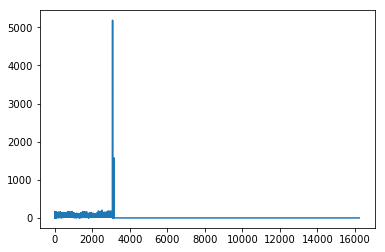

(16236,)


C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


ValueError: operands could not be broadcast together with shapes (16236,) (4932,) (16236,) 

In [142]:
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 700] # Min and max in y to search in slide_window()

draw_image = np.copy(test_image_1)
windows = slide_window(test_image_1, y_start_stop=[350, 720], xy_window=(50,50), xy_overlap=(0.5, 0.5))
car_windows = search_windows(test_image_1, windows=windows, clf=svc, scaler=X_scalar, color_space=colorspace, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

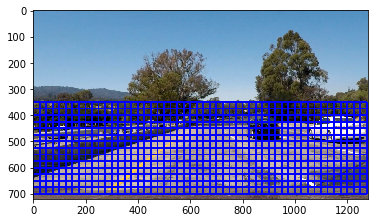

In [100]:
window_img = draw_boxes(test_image_1, car_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()